In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['targets']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b25_targets_t1t2_normalized_k5_b25_t1t2_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4629816, 1380)
(4629816, 8)
validation
(621056, 1380)
(621056, 8)
test
(624904, 1380)
(624904, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1380)]            0         


 dense (Dense)               (None, 1024)              1414144   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 2104200 (8.03 MB)


Trainable params: 2104200 (8.03 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/463 [..............................] - ETA: 10:08 - loss: 2.3832 - STD: 0.1190 - MAE: 0.2134

  4/463 [..............................] - ETA: 9s - loss: 2.1652 - STD: 0.0604 - MAE: 0.2161   

  6/463 [..............................] - ETA: 10s - loss: 2.1442 - STD: 0.0517 - MAE: 0.2168

  8/463 [..............................] - ETA: 12s - loss: 2.1334 - STD: 0.0493 - MAE: 0.2170

 10/463 [..............................] - ETA: 12s - loss: 2.1221 - STD: 0.0480 - MAE: 0.2169

 12/463 [..............................] - ETA: 12s - loss: 2.1112 - STD: 0.0475 - MAE: 0.2167

 14/463 [..............................] - ETA: 12s - loss: 2.1032 - STD: 0.0471 - MAE: 0.2166

 16/463 [>.............................] - ETA: 13s - loss: 2.0983 - STD: 0.0464 - MAE: 0.2166

 18/463 [>.............................] - ETA: 13s - loss: 2.0951 - STD: 0.0454 - MAE: 0.2166

 20/463 [>.............................] - ETA: 13s - loss: 2.0920 - STD: 0.0444 - MAE: 0.2166

 22/463 [>.............................] - ETA: 13s - loss: 2.0889 - STD: 0.0433 - MAE: 0.2167

 24/463 [>.............................] - ETA: 13s - loss: 2.0857 - STD: 0.0422 - MAE: 0.2167

 26/463 [>.............................] - ETA: 13s - loss: 2.0832 - STD: 0.0414 - MAE: 0.2167

 28/463 [>.............................] - ETA: 13s - loss: 2.0814 - STD: 0.0409 - MAE: 0.2167

 30/463 [>.............................] - ETA: 13s - loss: 2.0797 - STD: 0.0404 - MAE: 0.2167

 32/463 [=>............................] - ETA: 13s - loss: 2.0782 - STD: 0.0399 - MAE: 0.2167

 34/463 [=>............................] - ETA: 13s - loss: 2.0766 - STD: 0.0393 - MAE: 0.2167

 36/463 [=>............................] - ETA: 13s - loss: 2.0752 - STD: 0.0389 - MAE: 0.2167

 38/463 [=>............................] - ETA: 13s - loss: 2.0739 - STD: 0.0385 - MAE: 0.2167

 40/463 [=>............................] - ETA: 13s - loss: 2.0728 - STD: 0.0382 - MAE: 0.2167

 42/463 [=>............................] - ETA: 13s - loss: 2.0718 - STD: 0.0381 - MAE: 0.2167

 44/463 [=>............................] - ETA: 13s - loss: 2.0710 - STD: 0.0380 - MAE: 0.2167

 46/463 [=>............................] - ETA: 13s - loss: 2.0702 - STD: 0.0378 - MAE: 0.2167

 47/463 [==>...........................] - ETA: 19s - loss: 2.0697 - STD: 0.0376 - MAE: 0.2167

 50/463 [==>...........................] - ETA: 18s - loss: 2.0686 - STD: 0.0372 - MAE: 0.2167

 53/463 [==>...........................] - ETA: 17s - loss: 2.0675 - STD: 0.0369 - MAE: 0.2167

 55/463 [==>...........................] - ETA: 17s - loss: 2.0671 - STD: 0.0368 - MAE: 0.2167

 57/463 [==>...........................] - ETA: 17s - loss: 2.0666 - STD: 0.0366 - MAE: 0.2167

 59/463 [==>...........................] - ETA: 17s - loss: 2.0662 - STD: 0.0364 - MAE: 0.2167

 61/463 [==>...........................] - ETA: 16s - loss: 2.0657 - STD: 0.0361 - MAE: 0.2167

 63/463 [===>..........................] - ETA: 16s - loss: 2.0652 - STD: 0.0360 - MAE: 0.2167

 65/463 [===>..........................] - ETA: 16s - loss: 2.0649 - STD: 0.0359 - MAE: 0.2167

 67/463 [===>..........................] - ETA: 16s - loss: 2.0645 - STD: 0.0358 - MAE: 0.2167

 69/463 [===>..........................] - ETA: 16s - loss: 2.0641 - STD: 0.0357 - MAE: 0.2167

 71/463 [===>..........................] - ETA: 15s - loss: 2.0639 - STD: 0.0355 - MAE: 0.2167

 73/463 [===>..........................] - ETA: 15s - loss: 2.0635 - STD: 0.0354 - MAE: 0.2167

 75/463 [===>..........................] - ETA: 15s - loss: 2.0631 - STD: 0.0354 - MAE: 0.2167

 77/463 [===>..........................] - ETA: 15s - loss: 2.0628 - STD: 0.0354 - MAE: 0.2167

 79/463 [====>.........................] - ETA: 15s - loss: 2.0625 - STD: 0.0353 - MAE: 0.2167

 81/463 [====>.........................] - ETA: 15s - loss: 2.0623 - STD: 0.0352 - MAE: 0.2167

 83/463 [====>.........................] - ETA: 14s - loss: 2.0619 - STD: 0.0350 - MAE: 0.2167

 85/463 [====>.........................] - ETA: 14s - loss: 2.0616 - STD: 0.0349 - MAE: 0.2167

 87/463 [====>.........................] - ETA: 14s - loss: 2.0614 - STD: 0.0350 - MAE: 0.2167

 89/463 [====>.........................] - ETA: 14s - loss: 2.0612 - STD: 0.0350 - MAE: 0.2167

 91/463 [====>.........................] - ETA: 14s - loss: 2.0610 - STD: 0.0349 - MAE: 0.2167

 93/463 [=====>........................] - ETA: 14s - loss: 2.0608 - STD: 0.0348 - MAE: 0.2167

 95/463 [=====>........................] - ETA: 14s - loss: 2.0605 - STD: 0.0347 - MAE: 0.2167

 97/463 [=====>........................] - ETA: 13s - loss: 2.0603 - STD: 0.0347 - MAE: 0.2167

 99/463 [=====>........................] - ETA: 13s - loss: 2.0600 - STD: 0.0347 - MAE: 0.2167

101/463 [=====>........................] - ETA: 13s - loss: 2.0598 - STD: 0.0347 - MAE: 0.2167

103/463 [=====>........................] - ETA: 13s - loss: 2.0596 - STD: 0.0346 - MAE: 0.2167

105/463 [=====>........................] - ETA: 13s - loss: 2.0594 - STD: 0.0345 - MAE: 0.2167

107/463 [=====>........................] - ETA: 13s - loss: 2.0592 - STD: 0.0345 - MAE: 0.2167

109/463 [======>.......................] - ETA: 13s - loss: 2.0590 - STD: 0.0344 - MAE: 0.2167

111/463 [======>.......................] - ETA: 13s - loss: 2.0588 - STD: 0.0344 - MAE: 0.2167

113/463 [======>.......................] - ETA: 13s - loss: 2.0585 - STD: 0.0344 - MAE: 0.2167

115/463 [======>.......................] - ETA: 12s - loss: 2.0582 - STD: 0.0344 - MAE: 0.2167

117/463 [======>.......................] - ETA: 12s - loss: 2.0579 - STD: 0.0343 - MAE: 0.2167

119/463 [======>.......................] - ETA: 12s - loss: 2.0576 - STD: 0.0343 - MAE: 0.2167

121/463 [======>.......................] - ETA: 12s - loss: 2.0572 - STD: 0.0342 - MAE: 0.2167

123/463 [======>.......................] - ETA: 12s - loss: 2.0568 - STD: 0.0342 - MAE: 0.2166

125/463 [=======>......................] - ETA: 12s - loss: 2.0563 - STD: 0.0342 - MAE: 0.2166

127/463 [=======>......................] - ETA: 12s - loss: 2.0559 - STD: 0.0342 - MAE: 0.2166

129/463 [=======>......................] - ETA: 12s - loss: 2.0553 - STD: 0.0343 - MAE: 0.2166

131/463 [=======>......................] - ETA: 12s - loss: 2.0547 - STD: 0.0343 - MAE: 0.2166

133/463 [=======>......................] - ETA: 12s - loss: 2.0539 - STD: 0.0343 - MAE: 0.2165

135/463 [=======>......................] - ETA: 11s - loss: 2.0531 - STD: 0.0345 - MAE: 0.2165

137/463 [=======>......................] - ETA: 11s - loss: 2.0523 - STD: 0.0347 - MAE: 0.2165

139/463 [========>.....................] - ETA: 11s - loss: 2.0514 - STD: 0.0348 - MAE: 0.2164

141/463 [========>.....................] - ETA: 11s - loss: 2.0505 - STD: 0.0351 - MAE: 0.2164

143/463 [========>.....................] - ETA: 11s - loss: 2.0495 - STD: 0.0353 - MAE: 0.2163

145/463 [========>.....................] - ETA: 11s - loss: 2.0484 - STD: 0.0355 - MAE: 0.2163

147/463 [========>.....................] - ETA: 11s - loss: 2.0474 - STD: 0.0357 - MAE: 0.2162

149/463 [========>.....................] - ETA: 11s - loss: 2.0463 - STD: 0.0360 - MAE: 0.2162

151/463 [========>.....................] - ETA: 11s - loss: 2.0450 - STD: 0.0363 - MAE: 0.2161

153/463 [========>.....................] - ETA: 11s - loss: 2.0438 - STD: 0.0366 - MAE: 0.2161

155/463 [=========>....................] - ETA: 11s - loss: 2.0428 - STD: 0.0369 - MAE: 0.2160

157/463 [=========>....................] - ETA: 10s - loss: 2.0415 - STD: 0.0372 - MAE: 0.2159

159/463 [=========>....................] - ETA: 10s - loss: 2.0404 - STD: 0.0375 - MAE: 0.2159

161/463 [=========>....................] - ETA: 10s - loss: 2.0392 - STD: 0.0378 - MAE: 0.2158

163/463 [=========>....................] - ETA: 10s - loss: 2.0378 - STD: 0.0381 - MAE: 0.2158

165/463 [=========>....................] - ETA: 10s - loss: 2.0364 - STD: 0.0384 - MAE: 0.2157

167/463 [=========>....................] - ETA: 10s - loss: 2.0351 - STD: 0.0387 - MAE: 0.2156

169/463 [=========>....................] - ETA: 10s - loss: 2.0336 - STD: 0.0389 - MAE: 0.2156

171/463 [==========>...................] - ETA: 10s - loss: 2.0320 - STD: 0.0392 - MAE: 0.2155

173/463 [==========>...................] - ETA: 10s - loss: 2.0306 - STD: 0.0395 - MAE: 0.2154

175/463 [==========>...................] - ETA: 10s - loss: 2.0290 - STD: 0.0399 - MAE: 0.2153

177/463 [==========>...................] - ETA: 10s - loss: 2.0274 - STD: 0.0402 - MAE: 0.2153

179/463 [==========>...................] - ETA: 10s - loss: 2.0261 - STD: 0.0405 - MAE: 0.2152

181/463 [==========>...................] - ETA: 9s - loss: 2.0245 - STD: 0.0408 - MAE: 0.2151 

183/463 [==========>...................] - ETA: 9s - loss: 2.0230 - STD: 0.0411 - MAE: 0.2150

185/463 [==========>...................] - ETA: 9s - loss: 2.0212 - STD: 0.0415 - MAE: 0.2149

187/463 [===========>..................] - ETA: 9s - loss: 2.0197 - STD: 0.0418 - MAE: 0.2149

189/463 [===========>..................] - ETA: 9s - loss: 2.0179 - STD: 0.0422 - MAE: 0.2148

191/463 [===========>..................] - ETA: 9s - loss: 2.0163 - STD: 0.0425 - MAE: 0.2147

193/463 [===========>..................] - ETA: 9s - loss: 2.0146 - STD: 0.0429 - MAE: 0.2146

195/463 [===========>..................] - ETA: 9s - loss: 2.0130 - STD: 0.0432 - MAE: 0.2145

197/463 [===========>..................] - ETA: 9s - loss: 2.0113 - STD: 0.0436 - MAE: 0.2144

199/463 [===========>..................] - ETA: 9s - loss: 2.0095 - STD: 0.0439 - MAE: 0.2143

201/463 [============>.................] - ETA: 9s - loss: 2.0077 - STD: 0.0442 - MAE: 0.2143

203/463 [============>.................] - ETA: 9s - loss: 2.0060 - STD: 0.0446 - MAE: 0.2142

205/463 [============>.................] - ETA: 9s - loss: 2.0046 - STD: 0.0450 - MAE: 0.2141

207/463 [============>.................] - ETA: 8s - loss: 2.0034 - STD: 0.0453 - MAE: 0.2140

209/463 [============>.................] - ETA: 8s - loss: 2.0020 - STD: 0.0457 - MAE: 0.2139

211/463 [============>.................] - ETA: 8s - loss: 2.0004 - STD: 0.0460 - MAE: 0.2138

213/463 [============>.................] - ETA: 8s - loss: 1.9991 - STD: 0.0463 - MAE: 0.2138

215/463 [============>.................] - ETA: 8s - loss: 1.9975 - STD: 0.0467 - MAE: 0.2137

217/463 [=============>................] - ETA: 8s - loss: 1.9960 - STD: 0.0470 - MAE: 0.2136

219/463 [=============>................] - ETA: 8s - loss: 1.9944 - STD: 0.0473 - MAE: 0.2135

221/463 [=============>................] - ETA: 8s - loss: 1.9930 - STD: 0.0476 - MAE: 0.2134

223/463 [=============>................] - ETA: 8s - loss: 1.9914 - STD: 0.0479 - MAE: 0.2133

225/463 [=============>................] - ETA: 8s - loss: 1.9899 - STD: 0.0482 - MAE: 0.2133

227/463 [=============>................] - ETA: 8s - loss: 1.9884 - STD: 0.0485 - MAE: 0.2132

229/463 [=============>................] - ETA: 8s - loss: 1.9869 - STD: 0.0488 - MAE: 0.2131

231/463 [=============>................] - ETA: 8s - loss: 1.9854 - STD: 0.0491 - MAE: 0.2130

233/463 [==============>...............] - ETA: 7s - loss: 1.9839 - STD: 0.0494 - MAE: 0.2129

235/463 [==============>...............] - ETA: 7s - loss: 1.9824 - STD: 0.0497 - MAE: 0.2129

237/463 [==============>...............] - ETA: 7s - loss: 1.9808 - STD: 0.0500 - MAE: 0.2128

239/463 [==============>...............] - ETA: 7s - loss: 1.9793 - STD: 0.0503 - MAE: 0.2127

241/463 [==============>...............] - ETA: 7s - loss: 1.9778 - STD: 0.0506 - MAE: 0.2126

243/463 [==============>...............] - ETA: 7s - loss: 1.9763 - STD: 0.0509 - MAE: 0.2125

245/463 [==============>...............] - ETA: 7s - loss: 1.9748 - STD: 0.0512 - MAE: 0.2124

247/463 [===============>..............] - ETA: 7s - loss: 1.9734 - STD: 0.0515 - MAE: 0.2124

249/463 [===============>..............] - ETA: 7s - loss: 1.9719 - STD: 0.0517 - MAE: 0.2123

251/463 [===============>..............] - ETA: 7s - loss: 1.9705 - STD: 0.0520 - MAE: 0.2122

253/463 [===============>..............] - ETA: 7s - loss: 1.9690 - STD: 0.0523 - MAE: 0.2121

255/463 [===============>..............] - ETA: 7s - loss: 1.9676 - STD: 0.0526 - MAE: 0.2120

257/463 [===============>..............] - ETA: 7s - loss: 1.9662 - STD: 0.0529 - MAE: 0.2119

259/463 [===============>..............] - ETA: 7s - loss: 1.9649 - STD: 0.0532 - MAE: 0.2119

261/463 [===============>..............] - ETA: 6s - loss: 1.9635 - STD: 0.0535 - MAE: 0.2118

263/463 [================>.............] - ETA: 6s - loss: 1.9623 - STD: 0.0538 - MAE: 0.2117

265/463 [================>.............] - ETA: 6s - loss: 1.9610 - STD: 0.0541 - MAE: 0.2116

267/463 [================>.............] - ETA: 6s - loss: 1.9599 - STD: 0.0544 - MAE: 0.2115

269/463 [================>.............] - ETA: 6s - loss: 1.9586 - STD: 0.0547 - MAE: 0.2114

271/463 [================>.............] - ETA: 6s - loss: 1.9573 - STD: 0.0549 - MAE: 0.2114

273/463 [================>.............] - ETA: 6s - loss: 1.9561 - STD: 0.0552 - MAE: 0.2113

275/463 [================>.............] - ETA: 6s - loss: 1.9547 - STD: 0.0555 - MAE: 0.2112

277/463 [================>.............] - ETA: 6s - loss: 1.9535 - STD: 0.0558 - MAE: 0.2111

279/463 [=================>............] - ETA: 6s - loss: 1.9523 - STD: 0.0560 - MAE: 0.2111

281/463 [=================>............] - ETA: 6s - loss: 1.9510 - STD: 0.0563 - MAE: 0.2110

283/463 [=================>............] - ETA: 6s - loss: 1.9498 - STD: 0.0565 - MAE: 0.2109

285/463 [=================>............] - ETA: 6s - loss: 1.9485 - STD: 0.0568 - MAE: 0.2108

287/463 [=================>............] - ETA: 6s - loss: 1.9473 - STD: 0.0571 - MAE: 0.2107

289/463 [=================>............] - ETA: 5s - loss: 1.9460 - STD: 0.0573 - MAE: 0.2107

291/463 [=================>............] - ETA: 5s - loss: 1.9447 - STD: 0.0576 - MAE: 0.2106

293/463 [=================>............] - ETA: 5s - loss: 1.9435 - STD: 0.0579 - MAE: 0.2105

295/463 [==================>...........] - ETA: 5s - loss: 1.9423 - STD: 0.0581 - MAE: 0.2104

297/463 [==================>...........] - ETA: 5s - loss: 1.9411 - STD: 0.0583 - MAE: 0.2104

299/463 [==================>...........] - ETA: 5s - loss: 1.9400 - STD: 0.0586 - MAE: 0.2103

301/463 [==================>...........] - ETA: 5s - loss: 1.9388 - STD: 0.0589 - MAE: 0.2102

303/463 [==================>...........] - ETA: 5s - loss: 1.9376 - STD: 0.0591 - MAE: 0.2101

305/463 [==================>...........] - ETA: 5s - loss: 1.9365 - STD: 0.0594 - MAE: 0.2101

307/463 [==================>...........] - ETA: 5s - loss: 1.9353 - STD: 0.0596 - MAE: 0.2100

309/463 [===================>..........] - ETA: 5s - loss: 1.9342 - STD: 0.0598 - MAE: 0.2099

311/463 [===================>..........] - ETA: 5s - loss: 1.9331 - STD: 0.0601 - MAE: 0.2098

313/463 [===================>..........] - ETA: 5s - loss: 1.9319 - STD: 0.0603 - MAE: 0.2098

315/463 [===================>..........] - ETA: 5s - loss: 1.9308 - STD: 0.0606 - MAE: 0.2097

317/463 [===================>..........] - ETA: 4s - loss: 1.9297 - STD: 0.0608 - MAE: 0.2096

319/463 [===================>..........] - ETA: 4s - loss: 1.9286 - STD: 0.0611 - MAE: 0.2096

321/463 [===================>..........] - ETA: 4s - loss: 1.9275 - STD: 0.0613 - MAE: 0.2095

323/463 [===================>..........] - ETA: 4s - loss: 1.9265 - STD: 0.0615 - MAE: 0.2094

325/463 [====================>.........] - ETA: 4s - loss: 1.9254 - STD: 0.0617 - MAE: 0.2094

327/463 [====================>.........] - ETA: 4s - loss: 1.9244 - STD: 0.0620 - MAE: 0.2093

329/463 [====================>.........] - ETA: 4s - loss: 1.9235 - STD: 0.0622 - MAE: 0.2092

331/463 [====================>.........] - ETA: 4s - loss: 1.9225 - STD: 0.0624 - MAE: 0.2092

333/463 [====================>.........] - ETA: 4s - loss: 1.9214 - STD: 0.0626 - MAE: 0.2091

335/463 [====================>.........] - ETA: 4s - loss: 1.9204 - STD: 0.0629 - MAE: 0.2090

337/463 [====================>.........] - ETA: 4s - loss: 1.9194 - STD: 0.0631 - MAE: 0.2090

339/463 [====================>.........] - ETA: 4s - loss: 1.9184 - STD: 0.0633 - MAE: 0.2089

341/463 [=====================>........] - ETA: 4s - loss: 1.9174 - STD: 0.0635 - MAE: 0.2088

343/463 [=====================>........] - ETA: 4s - loss: 1.9164 - STD: 0.0637 - MAE: 0.2088

345/463 [=====================>........] - ETA: 3s - loss: 1.9154 - STD: 0.0639 - MAE: 0.2087

347/463 [=====================>........] - ETA: 3s - loss: 1.9144 - STD: 0.0641 - MAE: 0.2086

349/463 [=====================>........] - ETA: 3s - loss: 1.9134 - STD: 0.0644 - MAE: 0.2086

351/463 [=====================>........] - ETA: 3s - loss: 1.9125 - STD: 0.0646 - MAE: 0.2085

353/463 [=====================>........] - ETA: 3s - loss: 1.9115 - STD: 0.0648 - MAE: 0.2085

355/463 [======================>.......] - ETA: 3s - loss: 1.9106 - STD: 0.0650 - MAE: 0.2084

357/463 [======================>.......] - ETA: 3s - loss: 1.9097 - STD: 0.0652 - MAE: 0.2083

359/463 [======================>.......] - ETA: 3s - loss: 1.9088 - STD: 0.0654 - MAE: 0.2083

361/463 [======================>.......] - ETA: 3s - loss: 1.9079 - STD: 0.0656 - MAE: 0.2082

363/463 [======================>.......] - ETA: 3s - loss: 1.9070 - STD: 0.0658 - MAE: 0.2082

365/463 [======================>.......] - ETA: 3s - loss: 1.9061 - STD: 0.0660 - MAE: 0.2081

367/463 [======================>.......] - ETA: 3s - loss: 1.9052 - STD: 0.0662 - MAE: 0.2080

369/463 [======================>.......] - ETA: 3s - loss: 1.9042 - STD: 0.0664 - MAE: 0.2080

371/463 [=======================>......] - ETA: 3s - loss: 1.9033 - STD: 0.0666 - MAE: 0.2079

373/463 [=======================>......] - ETA: 3s - loss: 1.9024 - STD: 0.0668 - MAE: 0.2079

375/463 [=======================>......] - ETA: 2s - loss: 1.9016 - STD: 0.0669 - MAE: 0.2078

377/463 [=======================>......] - ETA: 2s - loss: 1.9007 - STD: 0.0671 - MAE: 0.2077

379/463 [=======================>......] - ETA: 2s - loss: 1.8998 - STD: 0.0673 - MAE: 0.2077

381/463 [=======================>......] - ETA: 2s - loss: 1.8990 - STD: 0.0675 - MAE: 0.2076

383/463 [=======================>......] - ETA: 2s - loss: 1.8981 - STD: 0.0677 - MAE: 0.2076

385/463 [=======================>......] - ETA: 2s - loss: 1.8972 - STD: 0.0679 - MAE: 0.2075

387/463 [========================>.....] - ETA: 2s - loss: 1.8964 - STD: 0.0681 - MAE: 0.2075

389/463 [========================>.....] - ETA: 2s - loss: 1.8955 - STD: 0.0682 - MAE: 0.2074

391/463 [========================>.....] - ETA: 2s - loss: 1.8947 - STD: 0.0684 - MAE: 0.2074

393/463 [========================>.....] - ETA: 2s - loss: 1.8938 - STD: 0.0686 - MAE: 0.2073

395/463 [========================>.....] - ETA: 2s - loss: 1.8929 - STD: 0.0688 - MAE: 0.2072

397/463 [========================>.....] - ETA: 2s - loss: 1.8921 - STD: 0.0690 - MAE: 0.2072

399/463 [========================>.....] - ETA: 2s - loss: 1.8912 - STD: 0.0691 - MAE: 0.2071

401/463 [========================>.....] - ETA: 2s - loss: 1.8905 - STD: 0.0693 - MAE: 0.2071

403/463 [=========================>....] - ETA: 2s - loss: 1.8897 - STD: 0.0695 - MAE: 0.2070

405/463 [=========================>....] - ETA: 1s - loss: 1.8888 - STD: 0.0697 - MAE: 0.2070

407/463 [=========================>....] - ETA: 1s - loss: 1.8881 - STD: 0.0698 - MAE: 0.2069

409/463 [=========================>....] - ETA: 1s - loss: 1.8873 - STD: 0.0700 - MAE: 0.2069

411/463 [=========================>....] - ETA: 1s - loss: 1.8865 - STD: 0.0702 - MAE: 0.2068

413/463 [=========================>....] - ETA: 1s - loss: 1.8858 - STD: 0.0703 - MAE: 0.2068

415/463 [=========================>....] - ETA: 1s - loss: 1.8851 - STD: 0.0705 - MAE: 0.2067

417/463 [==========================>...] - ETA: 1s - loss: 1.8844 - STD: 0.0707 - MAE: 0.2067

419/463 [==========================>...] - ETA: 1s - loss: 1.8837 - STD: 0.0708 - MAE: 0.2066

421/463 [==========================>...] - ETA: 1s - loss: 1.8829 - STD: 0.0710 - MAE: 0.2066

423/463 [==========================>...] - ETA: 1s - loss: 1.8821 - STD: 0.0712 - MAE: 0.2065

425/463 [==========================>...] - ETA: 1s - loss: 1.8814 - STD: 0.0713 - MAE: 0.2065

427/463 [==========================>...] - ETA: 1s - loss: 1.8807 - STD: 0.0715 - MAE: 0.2064

429/463 [==========================>...] - ETA: 1s - loss: 1.8799 - STD: 0.0716 - MAE: 0.2064

431/463 [==========================>...] - ETA: 1s - loss: 1.8792 - STD: 0.0718 - MAE: 0.2063

433/463 [===========================>..] - ETA: 1s - loss: 1.8784 - STD: 0.0720 - MAE: 0.2063

435/463 [===========================>..] - ETA: 0s - loss: 1.8776 - STD: 0.0721 - MAE: 0.2062

437/463 [===========================>..] - ETA: 0s - loss: 1.8769 - STD: 0.0723 - MAE: 0.2062

439/463 [===========================>..] - ETA: 0s - loss: 1.8762 - STD: 0.0724 - MAE: 0.2061

441/463 [===========================>..] - ETA: 0s - loss: 1.8754 - STD: 0.0726 - MAE: 0.2061

443/463 [===========================>..] - ETA: 0s - loss: 1.8747 - STD: 0.0727 - MAE: 0.2060

445/463 [===========================>..] - ETA: 0s - loss: 1.8740 - STD: 0.0729 - MAE: 0.2060

447/463 [===========================>..] - ETA: 0s - loss: 1.8733 - STD: 0.0730 - MAE: 0.2059

449/463 [============================>.] - ETA: 0s - loss: 1.8726 - STD: 0.0732 - MAE: 0.2059

451/463 [============================>.] - ETA: 0s - loss: 1.8719 - STD: 0.0733 - MAE: 0.2058

453/463 [============================>.] - ETA: 0s - loss: 1.8712 - STD: 0.0735 - MAE: 0.2058

455/463 [============================>.] - ETA: 0s - loss: 1.8704 - STD: 0.0736 - MAE: 0.2058

457/463 [============================>.] - ETA: 0s - loss: 1.8697 - STD: 0.0738 - MAE: 0.2057

459/463 [============================>.] - ETA: 0s - loss: 1.8690 - STD: 0.0739 - MAE: 0.2057

461/463 [============================>.] - ETA: 0s - loss: 1.8683 - STD: 0.0741 - MAE: 0.2056

463/463 [==============================] - ETA: 0s - loss: 1.8676 - STD: 0.0742 - MAE: 0.2056

463/463 [==============================] - 19s 39ms/step - loss: 1.8676 - STD: 0.0742 - MAE: 0.2056 - val_loss: 2.0064 - val_STD: 0.1229 - val_MAE: 0.1991


Epoch 2/10000


  1/463 [..............................] - ETA: 31s - loss: 1.7173 - STD: 0.1116 - MAE: 0.1945

  3/463 [..............................] - ETA: 14s - loss: 1.7064 - STD: 0.1065 - MAE: 0.1951

  5/463 [..............................] - ETA: 14s - loss: 1.7055 - STD: 0.1076 - MAE: 0.1948

  7/463 [..............................] - ETA: 14s - loss: 1.7052 - STD: 0.1075 - MAE: 0.1948

  9/463 [..............................] - ETA: 14s - loss: 1.7028 - STD: 0.1082 - MAE: 0.1946

 11/463 [..............................] - ETA: 14s - loss: 1.7003 - STD: 0.1082 - MAE: 0.1945

 13/463 [..............................] - ETA: 14s - loss: 1.7007 - STD: 0.1086 - MAE: 0.1944

 15/463 [..............................] - ETA: 14s - loss: 1.7026 - STD: 0.1089 - MAE: 0.1944

 17/463 [>.............................] - ETA: 14s - loss: 1.7020 - STD: 0.1086 - MAE: 0.1945

 19/463 [>.............................] - ETA: 14s - loss: 1.7024 - STD: 0.1091 - MAE: 0.1944

 21/463 [>.............................] - ETA: 14s - loss: 1.7018 - STD: 0.1090 - MAE: 0.1944

 23/463 [>.............................] - ETA: 14s - loss: 1.7011 - STD: 0.1092 - MAE: 0.1943

 25/463 [>.............................] - ETA: 13s - loss: 1.7008 - STD: 0.1095 - MAE: 0.1942

 27/463 [>.............................] - ETA: 13s - loss: 1.7005 - STD: 0.1096 - MAE: 0.1942

 29/463 [>.............................] - ETA: 13s - loss: 1.7006 - STD: 0.1094 - MAE: 0.1943

 31/463 [=>............................] - ETA: 13s - loss: 1.7003 - STD: 0.1096 - MAE: 0.1942

 33/463 [=>............................] - ETA: 13s - loss: 1.7004 - STD: 0.1097 - MAE: 0.1942

 35/463 [=>............................] - ETA: 13s - loss: 1.6994 - STD: 0.1097 - MAE: 0.1942

 37/463 [=>............................] - ETA: 13s - loss: 1.6999 - STD: 0.1097 - MAE: 0.1942

 39/463 [=>............................] - ETA: 13s - loss: 1.6996 - STD: 0.1098 - MAE: 0.1941

 41/463 [=>............................] - ETA: 13s - loss: 1.6989 - STD: 0.1097 - MAE: 0.1941

 43/463 [=>............................] - ETA: 13s - loss: 1.6981 - STD: 0.1098 - MAE: 0.1941

 45/463 [=>............................] - ETA: 13s - loss: 1.6974 - STD: 0.1098 - MAE: 0.1941

 47/463 [==>...........................] - ETA: 13s - loss: 1.6964 - STD: 0.1099 - MAE: 0.1940

 49/463 [==>...........................] - ETA: 13s - loss: 1.6958 - STD: 0.1099 - MAE: 0.1940

 51/463 [==>...........................] - ETA: 13s - loss: 1.6950 - STD: 0.1100 - MAE: 0.1939

 53/463 [==>...........................] - ETA: 12s - loss: 1.6943 - STD: 0.1101 - MAE: 0.1939

 55/463 [==>...........................] - ETA: 12s - loss: 1.6937 - STD: 0.1103 - MAE: 0.1938

 57/463 [==>...........................] - ETA: 12s - loss: 1.6936 - STD: 0.1104 - MAE: 0.1938

 59/463 [==>...........................] - ETA: 12s - loss: 1.6935 - STD: 0.1104 - MAE: 0.1938

 61/463 [==>...........................] - ETA: 12s - loss: 1.6931 - STD: 0.1106 - MAE: 0.1937

 63/463 [===>..........................] - ETA: 12s - loss: 1.6925 - STD: 0.1107 - MAE: 0.1937

 65/463 [===>..........................] - ETA: 12s - loss: 1.6924 - STD: 0.1107 - MAE: 0.1937

 67/463 [===>..........................] - ETA: 12s - loss: 1.6923 - STD: 0.1107 - MAE: 0.1937

 69/463 [===>..........................] - ETA: 12s - loss: 1.6917 - STD: 0.1108 - MAE: 0.1936

 71/463 [===>..........................] - ETA: 12s - loss: 1.6913 - STD: 0.1109 - MAE: 0.1936

 73/463 [===>..........................] - ETA: 12s - loss: 1.6907 - STD: 0.1109 - MAE: 0.1936

 75/463 [===>..........................] - ETA: 12s - loss: 1.6906 - STD: 0.1110 - MAE: 0.1935

 77/463 [===>..........................] - ETA: 12s - loss: 1.6905 - STD: 0.1111 - MAE: 0.1935

 79/463 [====>.........................] - ETA: 12s - loss: 1.6901 - STD: 0.1112 - MAE: 0.1935

 81/463 [====>.........................] - ETA: 12s - loss: 1.6898 - STD: 0.1112 - MAE: 0.1935

 83/463 [====>.........................] - ETA: 12s - loss: 1.6896 - STD: 0.1113 - MAE: 0.1934

 85/463 [====>.........................] - ETA: 11s - loss: 1.6891 - STD: 0.1114 - MAE: 0.1934

 87/463 [====>.........................] - ETA: 11s - loss: 1.6887 - STD: 0.1115 - MAE: 0.1934

 89/463 [====>.........................] - ETA: 11s - loss: 1.6883 - STD: 0.1116 - MAE: 0.1933

 91/463 [====>.........................] - ETA: 11s - loss: 1.6880 - STD: 0.1116 - MAE: 0.1933

 93/463 [=====>........................] - ETA: 11s - loss: 1.6873 - STD: 0.1117 - MAE: 0.1933

 95/463 [=====>........................] - ETA: 11s - loss: 1.6872 - STD: 0.1117 - MAE: 0.1933

 97/463 [=====>........................] - ETA: 11s - loss: 1.6869 - STD: 0.1118 - MAE: 0.1932

 99/463 [=====>........................] - ETA: 11s - loss: 1.6864 - STD: 0.1119 - MAE: 0.1932

101/463 [=====>........................] - ETA: 11s - loss: 1.6860 - STD: 0.1119 - MAE: 0.1932

103/463 [=====>........................] - ETA: 11s - loss: 1.6857 - STD: 0.1119 - MAE: 0.1932

105/463 [=====>........................] - ETA: 11s - loss: 1.6857 - STD: 0.1120 - MAE: 0.1931

107/463 [=====>........................] - ETA: 11s - loss: 1.6858 - STD: 0.1120 - MAE: 0.1932

109/463 [======>.......................] - ETA: 11s - loss: 1.6854 - STD: 0.1121 - MAE: 0.1931

111/463 [======>.......................] - ETA: 11s - loss: 1.6851 - STD: 0.1121 - MAE: 0.1931

113/463 [======>.......................] - ETA: 11s - loss: 1.6846 - STD: 0.1121 - MAE: 0.1931

115/463 [======>.......................] - ETA: 11s - loss: 1.6842 - STD: 0.1122 - MAE: 0.1930

117/463 [======>.......................] - ETA: 10s - loss: 1.6841 - STD: 0.1122 - MAE: 0.1930

119/463 [======>.......................] - ETA: 10s - loss: 1.6838 - STD: 0.1123 - MAE: 0.1930

121/463 [======>.......................] - ETA: 10s - loss: 1.6833 - STD: 0.1124 - MAE: 0.1930

123/463 [======>.......................] - ETA: 10s - loss: 1.6830 - STD: 0.1124 - MAE: 0.1929

125/463 [=======>......................] - ETA: 10s - loss: 1.6827 - STD: 0.1125 - MAE: 0.1929

127/463 [=======>......................] - ETA: 10s - loss: 1.6826 - STD: 0.1125 - MAE: 0.1929

129/463 [=======>......................] - ETA: 10s - loss: 1.6822 - STD: 0.1126 - MAE: 0.1929

131/463 [=======>......................] - ETA: 10s - loss: 1.6820 - STD: 0.1126 - MAE: 0.1929

133/463 [=======>......................] - ETA: 10s - loss: 1.6817 - STD: 0.1126 - MAE: 0.1929

135/463 [=======>......................] - ETA: 10s - loss: 1.6817 - STD: 0.1127 - MAE: 0.1928

137/463 [=======>......................] - ETA: 10s - loss: 1.6815 - STD: 0.1128 - MAE: 0.1928

139/463 [========>.....................] - ETA: 10s - loss: 1.6814 - STD: 0.1128 - MAE: 0.1928

141/463 [========>.....................] - ETA: 10s - loss: 1.6811 - STD: 0.1128 - MAE: 0.1928

143/463 [========>.....................] - ETA: 10s - loss: 1.6812 - STD: 0.1129 - MAE: 0.1928

145/463 [========>.....................] - ETA: 10s - loss: 1.6809 - STD: 0.1129 - MAE: 0.1927

147/463 [========>.....................] - ETA: 10s - loss: 1.6810 - STD: 0.1130 - MAE: 0.1927

149/463 [========>.....................] - ETA: 9s - loss: 1.6809 - STD: 0.1130 - MAE: 0.1927 

151/463 [========>.....................] - ETA: 9s - loss: 1.6810 - STD: 0.1130 - MAE: 0.1927

153/463 [========>.....................] - ETA: 9s - loss: 1.6810 - STD: 0.1131 - MAE: 0.1927

155/463 [=========>....................] - ETA: 9s - loss: 1.6809 - STD: 0.1131 - MAE: 0.1927

157/463 [=========>....................] - ETA: 9s - loss: 1.6809 - STD: 0.1131 - MAE: 0.1927

159/463 [=========>....................] - ETA: 9s - loss: 1.6808 - STD: 0.1131 - MAE: 0.1927

161/463 [=========>....................] - ETA: 9s - loss: 1.6807 - STD: 0.1131 - MAE: 0.1927

163/463 [=========>....................] - ETA: 9s - loss: 1.6805 - STD: 0.1132 - MAE: 0.1927

165/463 [=========>....................] - ETA: 9s - loss: 1.6803 - STD: 0.1132 - MAE: 0.1927

167/463 [=========>....................] - ETA: 9s - loss: 1.6802 - STD: 0.1132 - MAE: 0.1927

169/463 [=========>....................] - ETA: 9s - loss: 1.6799 - STD: 0.1132 - MAE: 0.1927

171/463 [==========>...................] - ETA: 9s - loss: 1.6797 - STD: 0.1132 - MAE: 0.1926

173/463 [==========>...................] - ETA: 9s - loss: 1.6795 - STD: 0.1133 - MAE: 0.1926

175/463 [==========>...................] - ETA: 9s - loss: 1.6793 - STD: 0.1133 - MAE: 0.1926

177/463 [==========>...................] - ETA: 9s - loss: 1.6791 - STD: 0.1133 - MAE: 0.1926

179/463 [==========>...................] - ETA: 8s - loss: 1.6788 - STD: 0.1133 - MAE: 0.1926

181/463 [==========>...................] - ETA: 8s - loss: 1.6788 - STD: 0.1133 - MAE: 0.1926

183/463 [==========>...................] - ETA: 8s - loss: 1.6788 - STD: 0.1134 - MAE: 0.1926

185/463 [==========>...................] - ETA: 8s - loss: 1.6786 - STD: 0.1134 - MAE: 0.1926

187/463 [===========>..................] - ETA: 8s - loss: 1.6787 - STD: 0.1135 - MAE: 0.1925

189/463 [===========>..................] - ETA: 8s - loss: 1.6784 - STD: 0.1135 - MAE: 0.1925

191/463 [===========>..................] - ETA: 8s - loss: 1.6782 - STD: 0.1135 - MAE: 0.1925

193/463 [===========>..................] - ETA: 8s - loss: 1.6780 - STD: 0.1136 - MAE: 0.1925

195/463 [===========>..................] - ETA: 8s - loss: 1.6779 - STD: 0.1136 - MAE: 0.1925

197/463 [===========>..................] - ETA: 8s - loss: 1.6776 - STD: 0.1136 - MAE: 0.1925

199/463 [===========>..................] - ETA: 8s - loss: 1.6773 - STD: 0.1136 - MAE: 0.1925

201/463 [============>.................] - ETA: 8s - loss: 1.6770 - STD: 0.1137 - MAE: 0.1924

203/463 [============>.................] - ETA: 8s - loss: 1.6768 - STD: 0.1137 - MAE: 0.1924

205/463 [============>.................] - ETA: 8s - loss: 1.6765 - STD: 0.1137 - MAE: 0.1924

207/463 [============>.................] - ETA: 8s - loss: 1.6763 - STD: 0.1138 - MAE: 0.1924

209/463 [============>.................] - ETA: 8s - loss: 1.6761 - STD: 0.1138 - MAE: 0.1924

211/463 [============>.................] - ETA: 7s - loss: 1.6759 - STD: 0.1138 - MAE: 0.1924

213/463 [============>.................] - ETA: 7s - loss: 1.6756 - STD: 0.1138 - MAE: 0.1924

215/463 [============>.................] - ETA: 7s - loss: 1.6754 - STD: 0.1139 - MAE: 0.1923

217/463 [=============>................] - ETA: 7s - loss: 1.6753 - STD: 0.1139 - MAE: 0.1923

219/463 [=============>................] - ETA: 7s - loss: 1.6751 - STD: 0.1139 - MAE: 0.1923

221/463 [=============>................] - ETA: 7s - loss: 1.6748 - STD: 0.1139 - MAE: 0.1923

223/463 [=============>................] - ETA: 7s - loss: 1.6746 - STD: 0.1140 - MAE: 0.1923

225/463 [=============>................] - ETA: 7s - loss: 1.6744 - STD: 0.1140 - MAE: 0.1923

227/463 [=============>................] - ETA: 7s - loss: 1.6741 - STD: 0.1140 - MAE: 0.1923

229/463 [=============>................] - ETA: 7s - loss: 1.6739 - STD: 0.1141 - MAE: 0.1922

231/463 [=============>................] - ETA: 7s - loss: 1.6736 - STD: 0.1141 - MAE: 0.1922

233/463 [==============>...............] - ETA: 7s - loss: 1.6734 - STD: 0.1142 - MAE: 0.1922

235/463 [==============>...............] - ETA: 7s - loss: 1.6732 - STD: 0.1142 - MAE: 0.1922

237/463 [==============>...............] - ETA: 7s - loss: 1.6731 - STD: 0.1142 - MAE: 0.1922

239/463 [==============>...............] - ETA: 7s - loss: 1.6730 - STD: 0.1143 - MAE: 0.1922

241/463 [==============>...............] - ETA: 7s - loss: 1.6728 - STD: 0.1143 - MAE: 0.1922

243/463 [==============>...............] - ETA: 6s - loss: 1.6727 - STD: 0.1143 - MAE: 0.1921

245/463 [==============>...............] - ETA: 6s - loss: 1.6725 - STD: 0.1143 - MAE: 0.1921

247/463 [===============>..............] - ETA: 6s - loss: 1.6724 - STD: 0.1144 - MAE: 0.1921

249/463 [===============>..............] - ETA: 6s - loss: 1.6722 - STD: 0.1144 - MAE: 0.1921

251/463 [===============>..............] - ETA: 6s - loss: 1.6721 - STD: 0.1144 - MAE: 0.1921

253/463 [===============>..............] - ETA: 6s - loss: 1.6720 - STD: 0.1145 - MAE: 0.1921

255/463 [===============>..............] - ETA: 6s - loss: 1.6720 - STD: 0.1145 - MAE: 0.1921

257/463 [===============>..............] - ETA: 6s - loss: 1.6719 - STD: 0.1145 - MAE: 0.1921

259/463 [===============>..............] - ETA: 6s - loss: 1.6717 - STD: 0.1145 - MAE: 0.1921

261/463 [===============>..............] - ETA: 6s - loss: 1.6717 - STD: 0.1145 - MAE: 0.1921

263/463 [================>.............] - ETA: 6s - loss: 1.6716 - STD: 0.1145 - MAE: 0.1921

265/463 [================>.............] - ETA: 6s - loss: 1.6714 - STD: 0.1146 - MAE: 0.1920

267/463 [================>.............] - ETA: 6s - loss: 1.6713 - STD: 0.1146 - MAE: 0.1920

269/463 [================>.............] - ETA: 6s - loss: 1.6712 - STD: 0.1146 - MAE: 0.1920

271/463 [================>.............] - ETA: 6s - loss: 1.6710 - STD: 0.1146 - MAE: 0.1920

273/463 [================>.............] - ETA: 6s - loss: 1.6709 - STD: 0.1146 - MAE: 0.1920

275/463 [================>.............] - ETA: 5s - loss: 1.6709 - STD: 0.1147 - MAE: 0.1920

277/463 [================>.............] - ETA: 5s - loss: 1.6707 - STD: 0.1147 - MAE: 0.1920

279/463 [=================>............] - ETA: 5s - loss: 1.6706 - STD: 0.1147 - MAE: 0.1920

281/463 [=================>............] - ETA: 5s - loss: 1.6705 - STD: 0.1147 - MAE: 0.1920

283/463 [=================>............] - ETA: 5s - loss: 1.6704 - STD: 0.1147 - MAE: 0.1920

285/463 [=================>............] - ETA: 5s - loss: 1.6703 - STD: 0.1147 - MAE: 0.1920

287/463 [=================>............] - ETA: 5s - loss: 1.6701 - STD: 0.1148 - MAE: 0.1919

289/463 [=================>............] - ETA: 5s - loss: 1.6699 - STD: 0.1148 - MAE: 0.1919

291/463 [=================>............] - ETA: 5s - loss: 1.6697 - STD: 0.1148 - MAE: 0.1919

293/463 [=================>............] - ETA: 5s - loss: 1.6696 - STD: 0.1148 - MAE: 0.1919

295/463 [==================>...........] - ETA: 5s - loss: 1.6694 - STD: 0.1148 - MAE: 0.1919

297/463 [==================>...........] - ETA: 5s - loss: 1.6693 - STD: 0.1149 - MAE: 0.1919

299/463 [==================>...........] - ETA: 5s - loss: 1.6691 - STD: 0.1149 - MAE: 0.1919

301/463 [==================>...........] - ETA: 5s - loss: 1.6689 - STD: 0.1149 - MAE: 0.1919

303/463 [==================>...........] - ETA: 5s - loss: 1.6688 - STD: 0.1149 - MAE: 0.1919

305/463 [==================>...........] - ETA: 5s - loss: 1.6686 - STD: 0.1150 - MAE: 0.1918

307/463 [==================>...........] - ETA: 4s - loss: 1.6684 - STD: 0.1150 - MAE: 0.1918

309/463 [===================>..........] - ETA: 4s - loss: 1.6681 - STD: 0.1150 - MAE: 0.1918

311/463 [===================>..........] - ETA: 4s - loss: 1.6680 - STD: 0.1150 - MAE: 0.1918

313/463 [===================>..........] - ETA: 4s - loss: 1.6677 - STD: 0.1151 - MAE: 0.1918

315/463 [===================>..........] - ETA: 4s - loss: 1.6675 - STD: 0.1151 - MAE: 0.1918

317/463 [===================>..........] - ETA: 4s - loss: 1.6673 - STD: 0.1151 - MAE: 0.1918

319/463 [===================>..........] - ETA: 4s - loss: 1.6671 - STD: 0.1151 - MAE: 0.1917

321/463 [===================>..........] - ETA: 4s - loss: 1.6669 - STD: 0.1152 - MAE: 0.1917

323/463 [===================>..........] - ETA: 4s - loss: 1.6667 - STD: 0.1152 - MAE: 0.1917

325/463 [====================>.........] - ETA: 4s - loss: 1.6665 - STD: 0.1152 - MAE: 0.1917

327/463 [====================>.........] - ETA: 4s - loss: 1.6664 - STD: 0.1153 - MAE: 0.1917

329/463 [====================>.........] - ETA: 4s - loss: 1.6663 - STD: 0.1153 - MAE: 0.1917

331/463 [====================>.........] - ETA: 4s - loss: 1.6661 - STD: 0.1153 - MAE: 0.1917

333/463 [====================>.........] - ETA: 4s - loss: 1.6660 - STD: 0.1153 - MAE: 0.1917

335/463 [====================>.........] - ETA: 4s - loss: 1.6658 - STD: 0.1154 - MAE: 0.1917

337/463 [====================>.........] - ETA: 3s - loss: 1.6657 - STD: 0.1154 - MAE: 0.1916

339/463 [====================>.........] - ETA: 3s - loss: 1.6655 - STD: 0.1154 - MAE: 0.1916

341/463 [=====================>........] - ETA: 3s - loss: 1.6653 - STD: 0.1154 - MAE: 0.1916

343/463 [=====================>........] - ETA: 3s - loss: 1.6651 - STD: 0.1154 - MAE: 0.1916

345/463 [=====================>........] - ETA: 3s - loss: 1.6650 - STD: 0.1155 - MAE: 0.1916

347/463 [=====================>........] - ETA: 3s - loss: 1.6648 - STD: 0.1155 - MAE: 0.1916

349/463 [=====================>........] - ETA: 3s - loss: 1.6647 - STD: 0.1155 - MAE: 0.1916

351/463 [=====================>........] - ETA: 3s - loss: 1.6645 - STD: 0.1155 - MAE: 0.1916

353/463 [=====================>........] - ETA: 3s - loss: 1.6644 - STD: 0.1156 - MAE: 0.1916

355/463 [======================>.......] - ETA: 3s - loss: 1.6642 - STD: 0.1156 - MAE: 0.1915

357/463 [======================>.......] - ETA: 3s - loss: 1.6641 - STD: 0.1156 - MAE: 0.1915

359/463 [======================>.......] - ETA: 3s - loss: 1.6639 - STD: 0.1156 - MAE: 0.1915

361/463 [======================>.......] - ETA: 3s - loss: 1.6638 - STD: 0.1157 - MAE: 0.1915

363/463 [======================>.......] - ETA: 3s - loss: 1.6637 - STD: 0.1157 - MAE: 0.1915

365/463 [======================>.......] - ETA: 3s - loss: 1.6634 - STD: 0.1157 - MAE: 0.1915

367/463 [======================>.......] - ETA: 3s - loss: 1.6633 - STD: 0.1157 - MAE: 0.1915

369/463 [======================>.......] - ETA: 2s - loss: 1.6632 - STD: 0.1157 - MAE: 0.1915

371/463 [=======================>......] - ETA: 2s - loss: 1.6631 - STD: 0.1157 - MAE: 0.1915

373/463 [=======================>......] - ETA: 2s - loss: 1.6629 - STD: 0.1158 - MAE: 0.1915

375/463 [=======================>......] - ETA: 2s - loss: 1.6627 - STD: 0.1158 - MAE: 0.1914

377/463 [=======================>......] - ETA: 2s - loss: 1.6626 - STD: 0.1158 - MAE: 0.1914

379/463 [=======================>......] - ETA: 2s - loss: 1.6624 - STD: 0.1158 - MAE: 0.1914

381/463 [=======================>......] - ETA: 2s - loss: 1.6623 - STD: 0.1158 - MAE: 0.1914

383/463 [=======================>......] - ETA: 2s - loss: 1.6622 - STD: 0.1159 - MAE: 0.1914

385/463 [=======================>......] - ETA: 2s - loss: 1.6621 - STD: 0.1159 - MAE: 0.1914

387/463 [========================>.....] - ETA: 2s - loss: 1.6620 - STD: 0.1159 - MAE: 0.1914

389/463 [========================>.....] - ETA: 2s - loss: 1.6619 - STD: 0.1159 - MAE: 0.1914

391/463 [========================>.....] - ETA: 2s - loss: 1.6617 - STD: 0.1160 - MAE: 0.1914

393/463 [========================>.....] - ETA: 2s - loss: 1.6616 - STD: 0.1160 - MAE: 0.1914

395/463 [========================>.....] - ETA: 2s - loss: 1.6614 - STD: 0.1160 - MAE: 0.1913

397/463 [========================>.....] - ETA: 2s - loss: 1.6612 - STD: 0.1160 - MAE: 0.1913

399/463 [========================>.....] - ETA: 2s - loss: 1.6611 - STD: 0.1160 - MAE: 0.1913

401/463 [========================>.....] - ETA: 1s - loss: 1.6609 - STD: 0.1160 - MAE: 0.1913

403/463 [=========================>....] - ETA: 1s - loss: 1.6608 - STD: 0.1161 - MAE: 0.1913

405/463 [=========================>....] - ETA: 1s - loss: 1.6607 - STD: 0.1161 - MAE: 0.1913

407/463 [=========================>....] - ETA: 1s - loss: 1.6605 - STD: 0.1161 - MAE: 0.1913

409/463 [=========================>....] - ETA: 1s - loss: 1.6603 - STD: 0.1161 - MAE: 0.1913

411/463 [=========================>....] - ETA: 1s - loss: 1.6602 - STD: 0.1161 - MAE: 0.1913

413/463 [=========================>....] - ETA: 1s - loss: 1.6601 - STD: 0.1162 - MAE: 0.1912

415/463 [=========================>....] - ETA: 1s - loss: 1.6599 - STD: 0.1162 - MAE: 0.1912

417/463 [==========================>...] - ETA: 1s - loss: 1.6597 - STD: 0.1162 - MAE: 0.1912

419/463 [==========================>...] - ETA: 1s - loss: 1.6596 - STD: 0.1162 - MAE: 0.1912

421/463 [==========================>...] - ETA: 1s - loss: 1.6594 - STD: 0.1163 - MAE: 0.1912

423/463 [==========================>...] - ETA: 1s - loss: 1.6593 - STD: 0.1163 - MAE: 0.1912

425/463 [==========================>...] - ETA: 1s - loss: 1.6593 - STD: 0.1163 - MAE: 0.1912

427/463 [==========================>...] - ETA: 1s - loss: 1.6592 - STD: 0.1163 - MAE: 0.1912

429/463 [==========================>...] - ETA: 1s - loss: 1.6591 - STD: 0.1163 - MAE: 0.1912

431/463 [==========================>...] - ETA: 1s - loss: 1.6590 - STD: 0.1163 - MAE: 0.1912

433/463 [===========================>..] - ETA: 0s - loss: 1.6589 - STD: 0.1163 - MAE: 0.1912

435/463 [===========================>..] - ETA: 0s - loss: 1.6588 - STD: 0.1164 - MAE: 0.1912

437/463 [===========================>..] - ETA: 0s - loss: 1.6587 - STD: 0.1164 - MAE: 0.1912

439/463 [===========================>..] - ETA: 0s - loss: 1.6585 - STD: 0.1164 - MAE: 0.1911

441/463 [===========================>..] - ETA: 0s - loss: 1.6583 - STD: 0.1164 - MAE: 0.1911

443/463 [===========================>..] - ETA: 0s - loss: 1.6581 - STD: 0.1164 - MAE: 0.1911

445/463 [===========================>..] - ETA: 0s - loss: 1.6580 - STD: 0.1165 - MAE: 0.1911

447/463 [===========================>..] - ETA: 0s - loss: 1.6578 - STD: 0.1165 - MAE: 0.1911

449/463 [============================>.] - ETA: 0s - loss: 1.6578 - STD: 0.1165 - MAE: 0.1911

451/463 [============================>.] - ETA: 0s - loss: 1.6576 - STD: 0.1165 - MAE: 0.1911

453/463 [============================>.] - ETA: 0s - loss: 1.6576 - STD: 0.1165 - MAE: 0.1911

455/463 [============================>.] - ETA: 0s - loss: 1.6574 - STD: 0.1166 - MAE: 0.1911

457/463 [============================>.] - ETA: 0s - loss: 1.6574 - STD: 0.1166 - MAE: 0.1911

459/463 [============================>.] - ETA: 0s - loss: 1.6572 - STD: 0.1166 - MAE: 0.1910

461/463 [============================>.] - ETA: 0s - loss: 1.6571 - STD: 0.1166 - MAE: 0.1910

463/463 [==============================] - ETA: 0s - loss: 1.6570 - STD: 0.1166 - MAE: 0.1910

463/463 [==============================] - 17s 36ms/step - loss: 1.6570 - STD: 0.1166 - MAE: 0.1910 - val_loss: 1.9129 - val_STD: 0.1263 - val_MAE: 0.1947


Epoch 3/10000


  1/463 [..............................] - ETA: 30s - loss: 1.6314 - STD: 0.1209 - MAE: 0.1889

  3/463 [..............................] - ETA: 14s - loss: 1.6215 - STD: 0.1214 - MAE: 0.1886

  5/463 [..............................] - ETA: 15s - loss: 1.6232 - STD: 0.1206 - MAE: 0.1888

  7/463 [..............................] - ETA: 15s - loss: 1.6247 - STD: 0.1205 - MAE: 0.1889

  9/463 [..............................] - ETA: 14s - loss: 1.6248 - STD: 0.1204 - MAE: 0.1889

 11/463 [..............................] - ETA: 14s - loss: 1.6255 - STD: 0.1208 - MAE: 0.1888

 13/463 [..............................] - ETA: 14s - loss: 1.6262 - STD: 0.1208 - MAE: 0.1889

 15/463 [..............................] - ETA: 14s - loss: 1.6260 - STD: 0.1208 - MAE: 0.1889

 17/463 [>.............................] - ETA: 14s - loss: 1.6265 - STD: 0.1209 - MAE: 0.1889

 19/463 [>.............................] - ETA: 14s - loss: 1.6265 - STD: 0.1208 - MAE: 0.1889

 21/463 [>.............................] - ETA: 13s - loss: 1.6272 - STD: 0.1208 - MAE: 0.1889

 23/463 [>.............................] - ETA: 13s - loss: 1.6273 - STD: 0.1211 - MAE: 0.1889

 25/463 [>.............................] - ETA: 13s - loss: 1.6278 - STD: 0.1208 - MAE: 0.1889

 27/463 [>.............................] - ETA: 13s - loss: 1.6280 - STD: 0.1210 - MAE: 0.1889

 29/463 [>.............................] - ETA: 13s - loss: 1.6275 - STD: 0.1210 - MAE: 0.1889

 31/463 [=>............................] - ETA: 13s - loss: 1.6277 - STD: 0.1210 - MAE: 0.1889

 33/463 [=>............................] - ETA: 13s - loss: 1.6275 - STD: 0.1211 - MAE: 0.1889

 35/463 [=>............................] - ETA: 13s - loss: 1.6281 - STD: 0.1211 - MAE: 0.1889

 37/463 [=>............................] - ETA: 13s - loss: 1.6281 - STD: 0.1212 - MAE: 0.1889

 39/463 [=>............................] - ETA: 13s - loss: 1.6277 - STD: 0.1211 - MAE: 0.1888

 41/463 [=>............................] - ETA: 13s - loss: 1.6276 - STD: 0.1213 - MAE: 0.1888

 43/463 [=>............................] - ETA: 13s - loss: 1.6279 - STD: 0.1212 - MAE: 0.1888

 45/463 [=>............................] - ETA: 13s - loss: 1.6276 - STD: 0.1212 - MAE: 0.1888

 47/463 [==>...........................] - ETA: 13s - loss: 1.6271 - STD: 0.1211 - MAE: 0.1888

 49/463 [==>...........................] - ETA: 13s - loss: 1.6269 - STD: 0.1212 - MAE: 0.1888

 51/463 [==>...........................] - ETA: 12s - loss: 1.6259 - STD: 0.1211 - MAE: 0.1888

 53/463 [==>...........................] - ETA: 12s - loss: 1.6258 - STD: 0.1212 - MAE: 0.1888

 55/463 [==>...........................] - ETA: 12s - loss: 1.6259 - STD: 0.1212 - MAE: 0.1888

 57/463 [==>...........................] - ETA: 12s - loss: 1.6257 - STD: 0.1211 - MAE: 0.1888

 59/463 [==>...........................] - ETA: 12s - loss: 1.6254 - STD: 0.1212 - MAE: 0.1887

 61/463 [==>...........................] - ETA: 12s - loss: 1.6256 - STD: 0.1212 - MAE: 0.1888

 63/463 [===>..........................] - ETA: 12s - loss: 1.6257 - STD: 0.1212 - MAE: 0.1888

 65/463 [===>..........................] - ETA: 12s - loss: 1.6253 - STD: 0.1213 - MAE: 0.1887

 67/463 [===>..........................] - ETA: 12s - loss: 1.6252 - STD: 0.1213 - MAE: 0.1887

 69/463 [===>..........................] - ETA: 12s - loss: 1.6250 - STD: 0.1213 - MAE: 0.1887

 71/463 [===>..........................] - ETA: 12s - loss: 1.6250 - STD: 0.1213 - MAE: 0.1887

 73/463 [===>..........................] - ETA: 12s - loss: 1.6249 - STD: 0.1213 - MAE: 0.1887

 75/463 [===>..........................] - ETA: 12s - loss: 1.6243 - STD: 0.1213 - MAE: 0.1887

 77/463 [===>..........................] - ETA: 12s - loss: 1.6242 - STD: 0.1214 - MAE: 0.1886

 79/463 [====>.........................] - ETA: 12s - loss: 1.6238 - STD: 0.1214 - MAE: 0.1886

 81/463 [====>.........................] - ETA: 12s - loss: 1.6235 - STD: 0.1214 - MAE: 0.1886

 83/463 [====>.........................] - ETA: 11s - loss: 1.6229 - STD: 0.1215 - MAE: 0.1886

 85/463 [====>.........................] - ETA: 11s - loss: 1.6233 - STD: 0.1215 - MAE: 0.1886

 87/463 [====>.........................] - ETA: 11s - loss: 1.6231 - STD: 0.1215 - MAE: 0.1886

 89/463 [====>.........................] - ETA: 11s - loss: 1.6230 - STD: 0.1216 - MAE: 0.1886

 91/463 [====>.........................] - ETA: 11s - loss: 1.6230 - STD: 0.1216 - MAE: 0.1886

 93/463 [=====>........................] - ETA: 11s - loss: 1.6230 - STD: 0.1216 - MAE: 0.1886

 95/463 [=====>........................] - ETA: 11s - loss: 1.6233 - STD: 0.1216 - MAE: 0.1886

 97/463 [=====>........................] - ETA: 11s - loss: 1.6231 - STD: 0.1216 - MAE: 0.1886

 99/463 [=====>........................] - ETA: 11s - loss: 1.6228 - STD: 0.1217 - MAE: 0.1885

101/463 [=====>........................] - ETA: 11s - loss: 1.6227 - STD: 0.1217 - MAE: 0.1885

103/463 [=====>........................] - ETA: 11s - loss: 1.6226 - STD: 0.1217 - MAE: 0.1885

105/463 [=====>........................] - ETA: 11s - loss: 1.6224 - STD: 0.1217 - MAE: 0.1885

107/463 [=====>........................] - ETA: 11s - loss: 1.6221 - STD: 0.1218 - MAE: 0.1885

109/463 [======>.......................] - ETA: 11s - loss: 1.6219 - STD: 0.1218 - MAE: 0.1885

111/463 [======>.......................] - ETA: 11s - loss: 1.6220 - STD: 0.1218 - MAE: 0.1885

113/463 [======>.......................] - ETA: 11s - loss: 1.6221 - STD: 0.1218 - MAE: 0.1885

115/463 [======>.......................] - ETA: 10s - loss: 1.6226 - STD: 0.1219 - MAE: 0.1885

117/463 [======>.......................] - ETA: 10s - loss: 1.6231 - STD: 0.1219 - MAE: 0.1885

119/463 [======>.......................] - ETA: 10s - loss: 1.6233 - STD: 0.1219 - MAE: 0.1885

121/463 [======>.......................] - ETA: 10s - loss: 1.6239 - STD: 0.1219 - MAE: 0.1885

123/463 [======>.......................] - ETA: 10s - loss: 1.6244 - STD: 0.1219 - MAE: 0.1885

125/463 [=======>......................] - ETA: 10s - loss: 1.6248 - STD: 0.1218 - MAE: 0.1886

127/463 [=======>......................] - ETA: 10s - loss: 1.6250 - STD: 0.1218 - MAE: 0.1886

129/463 [=======>......................] - ETA: 10s - loss: 1.6250 - STD: 0.1218 - MAE: 0.1886

131/463 [=======>......................] - ETA: 10s - loss: 1.6249 - STD: 0.1218 - MAE: 0.1886

133/463 [=======>......................] - ETA: 10s - loss: 1.6247 - STD: 0.1218 - MAE: 0.1886

135/463 [=======>......................] - ETA: 10s - loss: 1.6246 - STD: 0.1218 - MAE: 0.1886

137/463 [=======>......................] - ETA: 10s - loss: 1.6244 - STD: 0.1218 - MAE: 0.1886

139/463 [========>.....................] - ETA: 10s - loss: 1.6242 - STD: 0.1218 - MAE: 0.1886

141/463 [========>.....................] - ETA: 10s - loss: 1.6239 - STD: 0.1218 - MAE: 0.1886

143/463 [========>.....................] - ETA: 10s - loss: 1.6236 - STD: 0.1218 - MAE: 0.1885

145/463 [========>.....................] - ETA: 10s - loss: 1.6235 - STD: 0.1218 - MAE: 0.1885

147/463 [========>.....................] - ETA: 9s - loss: 1.6234 - STD: 0.1218 - MAE: 0.1885 

149/463 [========>.....................] - ETA: 9s - loss: 1.6233 - STD: 0.1218 - MAE: 0.1885

151/463 [========>.....................] - ETA: 9s - loss: 1.6231 - STD: 0.1218 - MAE: 0.1885

153/463 [========>.....................] - ETA: 9s - loss: 1.6229 - STD: 0.1218 - MAE: 0.1885

155/463 [=========>....................] - ETA: 9s - loss: 1.6228 - STD: 0.1219 - MAE: 0.1885

157/463 [=========>....................] - ETA: 9s - loss: 1.6227 - STD: 0.1219 - MAE: 0.1885

159/463 [=========>....................] - ETA: 9s - loss: 1.6224 - STD: 0.1219 - MAE: 0.1885

161/463 [=========>....................] - ETA: 9s - loss: 1.6223 - STD: 0.1220 - MAE: 0.1884

163/463 [=========>....................] - ETA: 9s - loss: 1.6222 - STD: 0.1220 - MAE: 0.1884

165/463 [=========>....................] - ETA: 9s - loss: 1.6220 - STD: 0.1220 - MAE: 0.1884

167/463 [=========>....................] - ETA: 9s - loss: 1.6219 - STD: 0.1220 - MAE: 0.1884

169/463 [=========>....................] - ETA: 9s - loss: 1.6218 - STD: 0.1220 - MAE: 0.1884

171/463 [==========>...................] - ETA: 9s - loss: 1.6217 - STD: 0.1220 - MAE: 0.1884

173/463 [==========>...................] - ETA: 9s - loss: 1.6215 - STD: 0.1220 - MAE: 0.1884

175/463 [==========>...................] - ETA: 9s - loss: 1.6213 - STD: 0.1220 - MAE: 0.1884

177/463 [==========>...................] - ETA: 9s - loss: 1.6211 - STD: 0.1221 - MAE: 0.1884

179/463 [==========>...................] - ETA: 8s - loss: 1.6210 - STD: 0.1221 - MAE: 0.1884

181/463 [==========>...................] - ETA: 8s - loss: 1.6210 - STD: 0.1221 - MAE: 0.1883

183/463 [==========>...................] - ETA: 8s - loss: 1.6208 - STD: 0.1221 - MAE: 0.1883

185/463 [==========>...................] - ETA: 8s - loss: 1.6207 - STD: 0.1221 - MAE: 0.1883

187/463 [===========>..................] - ETA: 8s - loss: 1.6205 - STD: 0.1222 - MAE: 0.1883

189/463 [===========>..................] - ETA: 8s - loss: 1.6203 - STD: 0.1222 - MAE: 0.1883

191/463 [===========>..................] - ETA: 8s - loss: 1.6201 - STD: 0.1222 - MAE: 0.1883

193/463 [===========>..................] - ETA: 8s - loss: 1.6198 - STD: 0.1223 - MAE: 0.1883

195/463 [===========>..................] - ETA: 8s - loss: 1.6198 - STD: 0.1223 - MAE: 0.1883

197/463 [===========>..................] - ETA: 8s - loss: 1.6196 - STD: 0.1223 - MAE: 0.1883

199/463 [===========>..................] - ETA: 8s - loss: 1.6196 - STD: 0.1223 - MAE: 0.1882

201/463 [============>.................] - ETA: 8s - loss: 1.6195 - STD: 0.1223 - MAE: 0.1882

203/463 [============>.................] - ETA: 8s - loss: 1.6193 - STD: 0.1223 - MAE: 0.1882

205/463 [============>.................] - ETA: 8s - loss: 1.6192 - STD: 0.1223 - MAE: 0.1882

207/463 [============>.................] - ETA: 8s - loss: 1.6190 - STD: 0.1224 - MAE: 0.1882

209/463 [============>.................] - ETA: 8s - loss: 1.6189 - STD: 0.1224 - MAE: 0.1882

211/463 [============>.................] - ETA: 7s - loss: 1.6188 - STD: 0.1224 - MAE: 0.1882

213/463 [============>.................] - ETA: 7s - loss: 1.6186 - STD: 0.1224 - MAE: 0.1882

215/463 [============>.................] - ETA: 7s - loss: 1.6184 - STD: 0.1224 - MAE: 0.1882

217/463 [=============>................] - ETA: 7s - loss: 1.6185 - STD: 0.1225 - MAE: 0.1882

219/463 [=============>................] - ETA: 7s - loss: 1.6185 - STD: 0.1225 - MAE: 0.1882

221/463 [=============>................] - ETA: 7s - loss: 1.6186 - STD: 0.1224 - MAE: 0.1882

223/463 [=============>................] - ETA: 7s - loss: 1.6185 - STD: 0.1225 - MAE: 0.1882

225/463 [=============>................] - ETA: 7s - loss: 1.6185 - STD: 0.1225 - MAE: 0.1882

227/463 [=============>................] - ETA: 7s - loss: 1.6186 - STD: 0.1225 - MAE: 0.1882

229/463 [=============>................] - ETA: 7s - loss: 1.6184 - STD: 0.1225 - MAE: 0.1882

231/463 [=============>................] - ETA: 7s - loss: 1.6184 - STD: 0.1225 - MAE: 0.1882

233/463 [==============>...............] - ETA: 7s - loss: 1.6182 - STD: 0.1225 - MAE: 0.1881

235/463 [==============>...............] - ETA: 7s - loss: 1.6181 - STD: 0.1225 - MAE: 0.1881

237/463 [==============>...............] - ETA: 7s - loss: 1.6180 - STD: 0.1226 - MAE: 0.1881

239/463 [==============>...............] - ETA: 7s - loss: 1.6178 - STD: 0.1226 - MAE: 0.1881

241/463 [==============>...............] - ETA: 7s - loss: 1.6179 - STD: 0.1226 - MAE: 0.1881

243/463 [==============>...............] - ETA: 6s - loss: 1.6177 - STD: 0.1226 - MAE: 0.1881

245/463 [==============>...............] - ETA: 6s - loss: 1.6175 - STD: 0.1226 - MAE: 0.1881

247/463 [===============>..............] - ETA: 6s - loss: 1.6173 - STD: 0.1226 - MAE: 0.1881

249/463 [===============>..............] - ETA: 6s - loss: 1.6172 - STD: 0.1226 - MAE: 0.1881

251/463 [===============>..............] - ETA: 6s - loss: 1.6171 - STD: 0.1227 - MAE: 0.1881

253/463 [===============>..............] - ETA: 6s - loss: 1.6169 - STD: 0.1227 - MAE: 0.1880

255/463 [===============>..............] - ETA: 6s - loss: 1.6168 - STD: 0.1227 - MAE: 0.1880

257/463 [===============>..............] - ETA: 6s - loss: 1.6167 - STD: 0.1227 - MAE: 0.1880

259/463 [===============>..............] - ETA: 6s - loss: 1.6165 - STD: 0.1227 - MAE: 0.1880

261/463 [===============>..............] - ETA: 6s - loss: 1.6163 - STD: 0.1228 - MAE: 0.1880

263/463 [================>.............] - ETA: 6s - loss: 1.6161 - STD: 0.1228 - MAE: 0.1880

265/463 [================>.............] - ETA: 6s - loss: 1.6160 - STD: 0.1228 - MAE: 0.1880

267/463 [================>.............] - ETA: 6s - loss: 1.6158 - STD: 0.1228 - MAE: 0.1880

269/463 [================>.............] - ETA: 6s - loss: 1.6157 - STD: 0.1228 - MAE: 0.1880

271/463 [================>.............] - ETA: 6s - loss: 1.6155 - STD: 0.1228 - MAE: 0.1879

273/463 [================>.............] - ETA: 5s - loss: 1.6153 - STD: 0.1229 - MAE: 0.1879

275/463 [================>.............] - ETA: 5s - loss: 1.6152 - STD: 0.1229 - MAE: 0.1879

277/463 [================>.............] - ETA: 5s - loss: 1.6151 - STD: 0.1229 - MAE: 0.1879

279/463 [=================>............] - ETA: 5s - loss: 1.6151 - STD: 0.1229 - MAE: 0.1879

281/463 [=================>............] - ETA: 5s - loss: 1.6150 - STD: 0.1230 - MAE: 0.1879

283/463 [=================>............] - ETA: 5s - loss: 1.6148 - STD: 0.1230 - MAE: 0.1879

285/463 [=================>............] - ETA: 5s - loss: 1.6146 - STD: 0.1230 - MAE: 0.1879

287/463 [=================>............] - ETA: 5s - loss: 1.6145 - STD: 0.1230 - MAE: 0.1879

289/463 [=================>............] - ETA: 5s - loss: 1.6143 - STD: 0.1230 - MAE: 0.1879

291/463 [=================>............] - ETA: 5s - loss: 1.6143 - STD: 0.1231 - MAE: 0.1878

293/463 [=================>............] - ETA: 5s - loss: 1.6142 - STD: 0.1231 - MAE: 0.1878

295/463 [==================>...........] - ETA: 5s - loss: 1.6142 - STD: 0.1231 - MAE: 0.1878

297/463 [==================>...........] - ETA: 5s - loss: 1.6142 - STD: 0.1231 - MAE: 0.1878

299/463 [==================>...........] - ETA: 5s - loss: 1.6141 - STD: 0.1231 - MAE: 0.1878

301/463 [==================>...........] - ETA: 5s - loss: 1.6141 - STD: 0.1231 - MAE: 0.1878

303/463 [==================>...........] - ETA: 5s - loss: 1.6140 - STD: 0.1232 - MAE: 0.1878

305/463 [==================>...........] - ETA: 4s - loss: 1.6139 - STD: 0.1232 - MAE: 0.1878

307/463 [==================>...........] - ETA: 4s - loss: 1.6139 - STD: 0.1232 - MAE: 0.1878

309/463 [===================>..........] - ETA: 4s - loss: 1.6138 - STD: 0.1232 - MAE: 0.1878

311/463 [===================>..........] - ETA: 4s - loss: 1.6136 - STD: 0.1232 - MAE: 0.1878

313/463 [===================>..........] - ETA: 4s - loss: 1.6136 - STD: 0.1232 - MAE: 0.1878

315/463 [===================>..........] - ETA: 4s - loss: 1.6134 - STD: 0.1232 - MAE: 0.1878

317/463 [===================>..........] - ETA: 4s - loss: 1.6133 - STD: 0.1232 - MAE: 0.1878

319/463 [===================>..........] - ETA: 4s - loss: 1.6131 - STD: 0.1232 - MAE: 0.1878

321/463 [===================>..........] - ETA: 4s - loss: 1.6130 - STD: 0.1233 - MAE: 0.1877

323/463 [===================>..........] - ETA: 4s - loss: 1.6129 - STD: 0.1233 - MAE: 0.1877

325/463 [====================>.........] - ETA: 4s - loss: 1.6127 - STD: 0.1233 - MAE: 0.1877

327/463 [====================>.........] - ETA: 4s - loss: 1.6127 - STD: 0.1233 - MAE: 0.1877

329/463 [====================>.........] - ETA: 4s - loss: 1.6127 - STD: 0.1233 - MAE: 0.1877

331/463 [====================>.........] - ETA: 4s - loss: 1.6126 - STD: 0.1233 - MAE: 0.1877

333/463 [====================>.........] - ETA: 4s - loss: 1.6125 - STD: 0.1234 - MAE: 0.1877

335/463 [====================>.........] - ETA: 4s - loss: 1.6123 - STD: 0.1234 - MAE: 0.1877

337/463 [====================>.........] - ETA: 3s - loss: 1.6122 - STD: 0.1234 - MAE: 0.1877

339/463 [====================>.........] - ETA: 3s - loss: 1.6121 - STD: 0.1234 - MAE: 0.1877

341/463 [=====================>........] - ETA: 3s - loss: 1.6120 - STD: 0.1234 - MAE: 0.1877

343/463 [=====================>........] - ETA: 3s - loss: 1.6118 - STD: 0.1234 - MAE: 0.1877

345/463 [=====================>........] - ETA: 3s - loss: 1.6116 - STD: 0.1235 - MAE: 0.1876

347/463 [=====================>........] - ETA: 3s - loss: 1.6115 - STD: 0.1235 - MAE: 0.1876

349/463 [=====================>........] - ETA: 3s - loss: 1.6114 - STD: 0.1235 - MAE: 0.1876

351/463 [=====================>........] - ETA: 3s - loss: 1.6113 - STD: 0.1235 - MAE: 0.1876

353/463 [=====================>........] - ETA: 3s - loss: 1.6112 - STD: 0.1235 - MAE: 0.1876

355/463 [======================>.......] - ETA: 3s - loss: 1.6111 - STD: 0.1235 - MAE: 0.1876

357/463 [======================>.......] - ETA: 3s - loss: 1.6110 - STD: 0.1236 - MAE: 0.1876

359/463 [======================>.......] - ETA: 3s - loss: 1.6109 - STD: 0.1236 - MAE: 0.1876

361/463 [======================>.......] - ETA: 3s - loss: 1.6108 - STD: 0.1236 - MAE: 0.1876

363/463 [======================>.......] - ETA: 3s - loss: 1.6107 - STD: 0.1236 - MAE: 0.1876

365/463 [======================>.......] - ETA: 3s - loss: 1.6105 - STD: 0.1236 - MAE: 0.1876

367/463 [======================>.......] - ETA: 3s - loss: 1.6105 - STD: 0.1236 - MAE: 0.1876

369/463 [======================>.......] - ETA: 2s - loss: 1.6103 - STD: 0.1236 - MAE: 0.1875

371/463 [=======================>......] - ETA: 2s - loss: 1.6102 - STD: 0.1237 - MAE: 0.1875

373/463 [=======================>......] - ETA: 2s - loss: 1.6100 - STD: 0.1237 - MAE: 0.1875

375/463 [=======================>......] - ETA: 2s - loss: 1.6100 - STD: 0.1237 - MAE: 0.1875

377/463 [=======================>......] - ETA: 2s - loss: 1.6098 - STD: 0.1237 - MAE: 0.1875

379/463 [=======================>......] - ETA: 2s - loss: 1.6096 - STD: 0.1237 - MAE: 0.1875

381/463 [=======================>......] - ETA: 2s - loss: 1.6096 - STD: 0.1238 - MAE: 0.1875

383/463 [=======================>......] - ETA: 2s - loss: 1.6095 - STD: 0.1238 - MAE: 0.1875

385/463 [=======================>......] - ETA: 2s - loss: 1.6094 - STD: 0.1238 - MAE: 0.1875

387/463 [========================>.....] - ETA: 2s - loss: 1.6093 - STD: 0.1238 - MAE: 0.1875

389/463 [========================>.....] - ETA: 2s - loss: 1.6092 - STD: 0.1238 - MAE: 0.1875

391/463 [========================>.....] - ETA: 2s - loss: 1.6091 - STD: 0.1238 - MAE: 0.1874

393/463 [========================>.....] - ETA: 2s - loss: 1.6091 - STD: 0.1238 - MAE: 0.1874

395/463 [========================>.....] - ETA: 2s - loss: 1.6091 - STD: 0.1239 - MAE: 0.1874

397/463 [========================>.....] - ETA: 2s - loss: 1.6093 - STD: 0.1239 - MAE: 0.1874

399/463 [========================>.....] - ETA: 2s - loss: 1.6094 - STD: 0.1239 - MAE: 0.1874

401/463 [========================>.....] - ETA: 1s - loss: 1.6095 - STD: 0.1239 - MAE: 0.1875

403/463 [=========================>....] - ETA: 1s - loss: 1.6098 - STD: 0.1239 - MAE: 0.1875

405/463 [=========================>....] - ETA: 1s - loss: 1.6100 - STD: 0.1239 - MAE: 0.1875

407/463 [=========================>....] - ETA: 1s - loss: 1.6101 - STD: 0.1239 - MAE: 0.1875

409/463 [=========================>....] - ETA: 1s - loss: 1.6103 - STD: 0.1239 - MAE: 0.1875

411/463 [=========================>....] - ETA: 1s - loss: 1.6105 - STD: 0.1239 - MAE: 0.1875

413/463 [=========================>....] - ETA: 1s - loss: 1.6105 - STD: 0.1239 - MAE: 0.1875

415/463 [=========================>....] - ETA: 1s - loss: 1.6105 - STD: 0.1239 - MAE: 0.1875

417/463 [==========================>...] - ETA: 1s - loss: 1.6105 - STD: 0.1239 - MAE: 0.1875

419/463 [==========================>...] - ETA: 1s - loss: 1.6105 - STD: 0.1239 - MAE: 0.1875

421/463 [==========================>...] - ETA: 1s - loss: 1.6105 - STD: 0.1239 - MAE: 0.1875

423/463 [==========================>...] - ETA: 1s - loss: 1.6104 - STD: 0.1239 - MAE: 0.1875

425/463 [==========================>...] - ETA: 1s - loss: 1.6104 - STD: 0.1239 - MAE: 0.1875

427/463 [==========================>...] - ETA: 1s - loss: 1.6103 - STD: 0.1239 - MAE: 0.1875

429/463 [==========================>...] - ETA: 1s - loss: 1.6102 - STD: 0.1239 - MAE: 0.1875

431/463 [==========================>...] - ETA: 1s - loss: 1.6101 - STD: 0.1239 - MAE: 0.1875

433/463 [===========================>..] - ETA: 0s - loss: 1.6100 - STD: 0.1239 - MAE: 0.1875

435/463 [===========================>..] - ETA: 0s - loss: 1.6099 - STD: 0.1239 - MAE: 0.1875

437/463 [===========================>..] - ETA: 0s - loss: 1.6097 - STD: 0.1239 - MAE: 0.1874

439/463 [===========================>..] - ETA: 0s - loss: 1.6096 - STD: 0.1239 - MAE: 0.1874

441/463 [===========================>..] - ETA: 0s - loss: 1.6094 - STD: 0.1240 - MAE: 0.1874

443/463 [===========================>..] - ETA: 0s - loss: 1.6092 - STD: 0.1240 - MAE: 0.1874

445/463 [===========================>..] - ETA: 0s - loss: 1.6091 - STD: 0.1240 - MAE: 0.1874

447/463 [===========================>..] - ETA: 0s - loss: 1.6090 - STD: 0.1240 - MAE: 0.1874

449/463 [============================>.] - ETA: 0s - loss: 1.6088 - STD: 0.1240 - MAE: 0.1874

451/463 [============================>.] - ETA: 0s - loss: 1.6087 - STD: 0.1240 - MAE: 0.1874

453/463 [============================>.] - ETA: 0s - loss: 1.6086 - STD: 0.1240 - MAE: 0.1874

455/463 [============================>.] - ETA: 0s - loss: 1.6085 - STD: 0.1241 - MAE: 0.1874

457/463 [============================>.] - ETA: 0s - loss: 1.6083 - STD: 0.1241 - MAE: 0.1874

459/463 [============================>.] - ETA: 0s - loss: 1.6082 - STD: 0.1241 - MAE: 0.1873

461/463 [============================>.] - ETA: 0s - loss: 1.6080 - STD: 0.1241 - MAE: 0.1873

463/463 [==============================] - ETA: 0s - loss: 1.6079 - STD: 0.1241 - MAE: 0.1873

463/463 [==============================] - 17s 36ms/step - loss: 1.6079 - STD: 0.1241 - MAE: 0.1873 - val_loss: 1.9384 - val_STD: 0.1302 - val_MAE: 0.1943


Epoch 4/10000


  1/463 [..............................] - ETA: 28s - loss: 1.5637 - STD: 0.1250 - MAE: 0.1855

  3/463 [..............................] - ETA: 16s - loss: 1.5799 - STD: 0.1281 - MAE: 0.1852

  5/463 [..............................] - ETA: 15s - loss: 1.5824 - STD: 0.1279 - MAE: 0.1854

  7/463 [..............................] - ETA: 14s - loss: 1.5832 - STD: 0.1275 - MAE: 0.1855

  9/463 [..............................] - ETA: 14s - loss: 1.5831 - STD: 0.1277 - MAE: 0.1855

 11/463 [..............................] - ETA: 14s - loss: 1.5830 - STD: 0.1274 - MAE: 0.1855

 13/463 [..............................] - ETA: 14s - loss: 1.5818 - STD: 0.1275 - MAE: 0.1854

 15/463 [..............................] - ETA: 14s - loss: 1.5815 - STD: 0.1273 - MAE: 0.1855

 17/463 [>.............................] - ETA: 14s - loss: 1.5810 - STD: 0.1277 - MAE: 0.1853

 19/463 [>.............................] - ETA: 14s - loss: 1.5807 - STD: 0.1276 - MAE: 0.1854

 21/463 [>.............................] - ETA: 14s - loss: 1.5806 - STD: 0.1277 - MAE: 0.1853

 23/463 [>.............................] - ETA: 13s - loss: 1.5800 - STD: 0.1277 - MAE: 0.1853

 25/463 [>.............................] - ETA: 13s - loss: 1.5808 - STD: 0.1277 - MAE: 0.1854

 27/463 [>.............................] - ETA: 13s - loss: 1.5802 - STD: 0.1279 - MAE: 0.1853

 29/463 [>.............................] - ETA: 13s - loss: 1.5802 - STD: 0.1279 - MAE: 0.1853

 31/463 [=>............................] - ETA: 13s - loss: 1.5810 - STD: 0.1281 - MAE: 0.1853

 33/463 [=>............................] - ETA: 13s - loss: 1.5813 - STD: 0.1280 - MAE: 0.1853

 35/463 [=>............................] - ETA: 13s - loss: 1.5811 - STD: 0.1279 - MAE: 0.1853

 37/463 [=>............................] - ETA: 13s - loss: 1.5804 - STD: 0.1279 - MAE: 0.1853

 39/463 [=>............................] - ETA: 13s - loss: 1.5806 - STD: 0.1279 - MAE: 0.1853

 41/463 [=>............................] - ETA: 13s - loss: 1.5800 - STD: 0.1280 - MAE: 0.1852

 43/463 [=>............................] - ETA: 13s - loss: 1.5798 - STD: 0.1280 - MAE: 0.1852

 45/463 [=>............................] - ETA: 13s - loss: 1.5798 - STD: 0.1280 - MAE: 0.1852

 47/463 [==>...........................] - ETA: 13s - loss: 1.5794 - STD: 0.1280 - MAE: 0.1852

 49/463 [==>...........................] - ETA: 13s - loss: 1.5796 - STD: 0.1280 - MAE: 0.1852

 51/463 [==>...........................] - ETA: 13s - loss: 1.5794 - STD: 0.1281 - MAE: 0.1852

 53/463 [==>...........................] - ETA: 12s - loss: 1.5792 - STD: 0.1281 - MAE: 0.1852

 55/463 [==>...........................] - ETA: 12s - loss: 1.5792 - STD: 0.1281 - MAE: 0.1851

 57/463 [==>...........................] - ETA: 12s - loss: 1.5792 - STD: 0.1282 - MAE: 0.1851

 59/463 [==>...........................] - ETA: 12s - loss: 1.5789 - STD: 0.1282 - MAE: 0.1851

 61/463 [==>...........................] - ETA: 12s - loss: 1.5785 - STD: 0.1283 - MAE: 0.1851

 63/463 [===>..........................] - ETA: 12s - loss: 1.5784 - STD: 0.1282 - MAE: 0.1851

 65/463 [===>..........................] - ETA: 12s - loss: 1.5784 - STD: 0.1283 - MAE: 0.1851

 67/463 [===>..........................] - ETA: 12s - loss: 1.5784 - STD: 0.1283 - MAE: 0.1851

 69/463 [===>..........................] - ETA: 12s - loss: 1.5785 - STD: 0.1283 - MAE: 0.1851

 71/463 [===>..........................] - ETA: 12s - loss: 1.5785 - STD: 0.1283 - MAE: 0.1851

 73/463 [===>..........................] - ETA: 12s - loss: 1.5785 - STD: 0.1283 - MAE: 0.1851

 75/463 [===>..........................] - ETA: 12s - loss: 1.5783 - STD: 0.1284 - MAE: 0.1850

 77/463 [===>..........................] - ETA: 12s - loss: 1.5781 - STD: 0.1284 - MAE: 0.1850

 79/463 [====>.........................] - ETA: 12s - loss: 1.5783 - STD: 0.1284 - MAE: 0.1850

 81/463 [====>.........................] - ETA: 12s - loss: 1.5785 - STD: 0.1285 - MAE: 0.1850

 83/463 [====>.........................] - ETA: 12s - loss: 1.5786 - STD: 0.1284 - MAE: 0.1851

 85/463 [====>.........................] - ETA: 12s - loss: 1.5786 - STD: 0.1284 - MAE: 0.1851

 87/463 [====>.........................] - ETA: 11s - loss: 1.5784 - STD: 0.1284 - MAE: 0.1850

 89/463 [====>.........................] - ETA: 11s - loss: 1.5788 - STD: 0.1284 - MAE: 0.1851

 91/463 [====>.........................] - ETA: 11s - loss: 1.5784 - STD: 0.1285 - MAE: 0.1850

 93/463 [=====>........................] - ETA: 11s - loss: 1.5785 - STD: 0.1284 - MAE: 0.1850

 95/463 [=====>........................] - ETA: 11s - loss: 1.5785 - STD: 0.1285 - MAE: 0.1850

 97/463 [=====>........................] - ETA: 11s - loss: 1.5784 - STD: 0.1285 - MAE: 0.1850

 99/463 [=====>........................] - ETA: 11s - loss: 1.5787 - STD: 0.1285 - MAE: 0.1850

101/463 [=====>........................] - ETA: 11s - loss: 1.5785 - STD: 0.1285 - MAE: 0.1850

103/463 [=====>........................] - ETA: 11s - loss: 1.5786 - STD: 0.1284 - MAE: 0.1850

105/463 [=====>........................] - ETA: 11s - loss: 1.5786 - STD: 0.1284 - MAE: 0.1850

107/463 [=====>........................] - ETA: 11s - loss: 1.5786 - STD: 0.1285 - MAE: 0.1850

109/463 [======>.......................] - ETA: 11s - loss: 1.5785 - STD: 0.1285 - MAE: 0.1850

111/463 [======>.......................] - ETA: 11s - loss: 1.5783 - STD: 0.1285 - MAE: 0.1850

113/463 [======>.......................] - ETA: 11s - loss: 1.5782 - STD: 0.1285 - MAE: 0.1850

115/463 [======>.......................] - ETA: 11s - loss: 1.5779 - STD: 0.1284 - MAE: 0.1850

117/463 [======>.......................] - ETA: 11s - loss: 1.5777 - STD: 0.1285 - MAE: 0.1850

119/463 [======>.......................] - ETA: 10s - loss: 1.5776 - STD: 0.1285 - MAE: 0.1850

121/463 [======>.......................] - ETA: 10s - loss: 1.5773 - STD: 0.1285 - MAE: 0.1850

123/463 [======>.......................] - ETA: 10s - loss: 1.5771 - STD: 0.1286 - MAE: 0.1850

125/463 [=======>......................] - ETA: 10s - loss: 1.5770 - STD: 0.1286 - MAE: 0.1849

127/463 [=======>......................] - ETA: 10s - loss: 1.5770 - STD: 0.1286 - MAE: 0.1850

129/463 [=======>......................] - ETA: 10s - loss: 1.5768 - STD: 0.1286 - MAE: 0.1849

131/463 [=======>......................] - ETA: 10s - loss: 1.5768 - STD: 0.1286 - MAE: 0.1849

133/463 [=======>......................] - ETA: 10s - loss: 1.5767 - STD: 0.1286 - MAE: 0.1849

135/463 [=======>......................] - ETA: 10s - loss: 1.5766 - STD: 0.1286 - MAE: 0.1849

137/463 [=======>......................] - ETA: 10s - loss: 1.5770 - STD: 0.1286 - MAE: 0.1850

139/463 [========>.....................] - ETA: 10s - loss: 1.5772 - STD: 0.1286 - MAE: 0.1850

141/463 [========>.....................] - ETA: 10s - loss: 1.5783 - STD: 0.1287 - MAE: 0.1850

143/463 [========>.....................] - ETA: 10s - loss: 1.5792 - STD: 0.1287 - MAE: 0.1850

145/463 [========>.....................] - ETA: 10s - loss: 1.5794 - STD: 0.1287 - MAE: 0.1850

147/463 [========>.....................] - ETA: 10s - loss: 1.5797 - STD: 0.1287 - MAE: 0.1850

149/463 [========>.....................] - ETA: 9s - loss: 1.5798 - STD: 0.1286 - MAE: 0.1851 

151/463 [========>.....................] - ETA: 9s - loss: 1.5798 - STD: 0.1286 - MAE: 0.1851

153/463 [========>.....................] - ETA: 9s - loss: 1.5798 - STD: 0.1285 - MAE: 0.1851

155/463 [=========>....................] - ETA: 9s - loss: 1.5799 - STD: 0.1286 - MAE: 0.1851

157/463 [=========>....................] - ETA: 9s - loss: 1.5797 - STD: 0.1285 - MAE: 0.1851

159/463 [=========>....................] - ETA: 9s - loss: 1.5796 - STD: 0.1285 - MAE: 0.1851

161/463 [=========>....................] - ETA: 9s - loss: 1.5794 - STD: 0.1285 - MAE: 0.1851

163/463 [=========>....................] - ETA: 9s - loss: 1.5793 - STD: 0.1285 - MAE: 0.1851

165/463 [=========>....................] - ETA: 9s - loss: 1.5790 - STD: 0.1285 - MAE: 0.1851

167/463 [=========>....................] - ETA: 9s - loss: 1.5788 - STD: 0.1285 - MAE: 0.1850

169/463 [=========>....................] - ETA: 9s - loss: 1.5786 - STD: 0.1285 - MAE: 0.1850

171/463 [==========>...................] - ETA: 9s - loss: 1.5785 - STD: 0.1285 - MAE: 0.1850

173/463 [==========>...................] - ETA: 9s - loss: 1.5783 - STD: 0.1286 - MAE: 0.1850

175/463 [==========>...................] - ETA: 9s - loss: 1.5781 - STD: 0.1286 - MAE: 0.1850

177/463 [==========>...................] - ETA: 9s - loss: 1.5780 - STD: 0.1286 - MAE: 0.1850

179/463 [==========>...................] - ETA: 9s - loss: 1.5777 - STD: 0.1286 - MAE: 0.1850

181/463 [==========>...................] - ETA: 8s - loss: 1.5776 - STD: 0.1286 - MAE: 0.1850

183/463 [==========>...................] - ETA: 8s - loss: 1.5774 - STD: 0.1286 - MAE: 0.1850

185/463 [==========>...................] - ETA: 8s - loss: 1.5772 - STD: 0.1286 - MAE: 0.1850

187/463 [===========>..................] - ETA: 8s - loss: 1.5771 - STD: 0.1287 - MAE: 0.1849

189/463 [===========>..................] - ETA: 8s - loss: 1.5770 - STD: 0.1287 - MAE: 0.1849

191/463 [===========>..................] - ETA: 8s - loss: 1.5768 - STD: 0.1287 - MAE: 0.1849

193/463 [===========>..................] - ETA: 8s - loss: 1.5767 - STD: 0.1287 - MAE: 0.1849

195/463 [===========>..................] - ETA: 8s - loss: 1.5766 - STD: 0.1287 - MAE: 0.1849

197/463 [===========>..................] - ETA: 8s - loss: 1.5765 - STD: 0.1287 - MAE: 0.1849

199/463 [===========>..................] - ETA: 8s - loss: 1.5764 - STD: 0.1287 - MAE: 0.1849

201/463 [============>.................] - ETA: 8s - loss: 1.5764 - STD: 0.1287 - MAE: 0.1849

203/463 [============>.................] - ETA: 8s - loss: 1.5762 - STD: 0.1288 - MAE: 0.1849

205/463 [============>.................] - ETA: 8s - loss: 1.5763 - STD: 0.1288 - MAE: 0.1849

207/463 [============>.................] - ETA: 8s - loss: 1.5762 - STD: 0.1288 - MAE: 0.1849

209/463 [============>.................] - ETA: 8s - loss: 1.5761 - STD: 0.1288 - MAE: 0.1849

211/463 [============>.................] - ETA: 8s - loss: 1.5761 - STD: 0.1288 - MAE: 0.1849

213/463 [============>.................] - ETA: 7s - loss: 1.5760 - STD: 0.1289 - MAE: 0.1848

215/463 [============>.................] - ETA: 7s - loss: 1.5760 - STD: 0.1289 - MAE: 0.1848

217/463 [=============>................] - ETA: 7s - loss: 1.5760 - STD: 0.1289 - MAE: 0.1848

219/463 [=============>................] - ETA: 7s - loss: 1.5760 - STD: 0.1289 - MAE: 0.1848

221/463 [=============>................] - ETA: 7s - loss: 1.5760 - STD: 0.1289 - MAE: 0.1848

223/463 [=============>................] - ETA: 7s - loss: 1.5760 - STD: 0.1289 - MAE: 0.1848

225/463 [=============>................] - ETA: 7s - loss: 1.5760 - STD: 0.1289 - MAE: 0.1848

227/463 [=============>................] - ETA: 7s - loss: 1.5759 - STD: 0.1289 - MAE: 0.1848

229/463 [=============>................] - ETA: 7s - loss: 1.5759 - STD: 0.1289 - MAE: 0.1848

231/463 [=============>................] - ETA: 7s - loss: 1.5759 - STD: 0.1289 - MAE: 0.1848

233/463 [==============>...............] - ETA: 7s - loss: 1.5758 - STD: 0.1289 - MAE: 0.1848

235/463 [==============>...............] - ETA: 7s - loss: 1.5759 - STD: 0.1290 - MAE: 0.1848

237/463 [==============>...............] - ETA: 7s - loss: 1.5758 - STD: 0.1289 - MAE: 0.1848

239/463 [==============>...............] - ETA: 7s - loss: 1.5758 - STD: 0.1290 - MAE: 0.1848

241/463 [==============>...............] - ETA: 7s - loss: 1.5756 - STD: 0.1290 - MAE: 0.1848

243/463 [==============>...............] - ETA: 6s - loss: 1.5756 - STD: 0.1290 - MAE: 0.1848

245/463 [==============>...............] - ETA: 6s - loss: 1.5755 - STD: 0.1290 - MAE: 0.1848

247/463 [===============>..............] - ETA: 6s - loss: 1.5755 - STD: 0.1290 - MAE: 0.1848

249/463 [===============>..............] - ETA: 6s - loss: 1.5754 - STD: 0.1290 - MAE: 0.1848

251/463 [===============>..............] - ETA: 6s - loss: 1.5754 - STD: 0.1290 - MAE: 0.1848

253/463 [===============>..............] - ETA: 6s - loss: 1.5753 - STD: 0.1290 - MAE: 0.1848

255/463 [===============>..............] - ETA: 6s - loss: 1.5751 - STD: 0.1290 - MAE: 0.1848

257/463 [===============>..............] - ETA: 6s - loss: 1.5750 - STD: 0.1290 - MAE: 0.1848

259/463 [===============>..............] - ETA: 6s - loss: 1.5748 - STD: 0.1290 - MAE: 0.1848

261/463 [===============>..............] - ETA: 6s - loss: 1.5746 - STD: 0.1290 - MAE: 0.1848

263/463 [================>.............] - ETA: 6s - loss: 1.5744 - STD: 0.1290 - MAE: 0.1847

265/463 [================>.............] - ETA: 6s - loss: 1.5742 - STD: 0.1291 - MAE: 0.1847

267/463 [================>.............] - ETA: 6s - loss: 1.5741 - STD: 0.1291 - MAE: 0.1847

269/463 [================>.............] - ETA: 6s - loss: 1.5739 - STD: 0.1291 - MAE: 0.1847

271/463 [================>.............] - ETA: 6s - loss: 1.5738 - STD: 0.1291 - MAE: 0.1847

273/463 [================>.............] - ETA: 6s - loss: 1.5737 - STD: 0.1291 - MAE: 0.1847

275/463 [================>.............] - ETA: 5s - loss: 1.5735 - STD: 0.1291 - MAE: 0.1847

277/463 [================>.............] - ETA: 5s - loss: 1.5734 - STD: 0.1292 - MAE: 0.1847

279/463 [=================>............] - ETA: 5s - loss: 1.5733 - STD: 0.1292 - MAE: 0.1847

281/463 [=================>............] - ETA: 5s - loss: 1.5730 - STD: 0.1292 - MAE: 0.1846

283/463 [=================>............] - ETA: 5s - loss: 1.5729 - STD: 0.1292 - MAE: 0.1846

285/463 [=================>............] - ETA: 5s - loss: 1.5727 - STD: 0.1292 - MAE: 0.1846

287/463 [=================>............] - ETA: 5s - loss: 1.5726 - STD: 0.1293 - MAE: 0.1846

289/463 [=================>............] - ETA: 5s - loss: 1.5724 - STD: 0.1293 - MAE: 0.1846

291/463 [=================>............] - ETA: 5s - loss: 1.5722 - STD: 0.1293 - MAE: 0.1846

293/463 [=================>............] - ETA: 5s - loss: 1.5721 - STD: 0.1293 - MAE: 0.1846

295/463 [==================>...........] - ETA: 5s - loss: 1.5719 - STD: 0.1293 - MAE: 0.1846

297/463 [==================>...........] - ETA: 5s - loss: 1.5718 - STD: 0.1293 - MAE: 0.1846

299/463 [==================>...........] - ETA: 5s - loss: 1.5715 - STD: 0.1293 - MAE: 0.1845

301/463 [==================>...........] - ETA: 5s - loss: 1.5714 - STD: 0.1294 - MAE: 0.1845

303/463 [==================>...........] - ETA: 5s - loss: 1.5712 - STD: 0.1294 - MAE: 0.1845

305/463 [==================>...........] - ETA: 5s - loss: 1.5709 - STD: 0.1294 - MAE: 0.1845

307/463 [==================>...........] - ETA: 4s - loss: 1.5707 - STD: 0.1294 - MAE: 0.1845

309/463 [===================>..........] - ETA: 4s - loss: 1.5706 - STD: 0.1294 - MAE: 0.1845

311/463 [===================>..........] - ETA: 4s - loss: 1.5704 - STD: 0.1295 - MAE: 0.1845

313/463 [===================>..........] - ETA: 4s - loss: 1.5703 - STD: 0.1295 - MAE: 0.1844

315/463 [===================>..........] - ETA: 4s - loss: 1.5702 - STD: 0.1295 - MAE: 0.1844

317/463 [===================>..........] - ETA: 4s - loss: 1.5702 - STD: 0.1295 - MAE: 0.1844

319/463 [===================>..........] - ETA: 4s - loss: 1.5701 - STD: 0.1296 - MAE: 0.1844

321/463 [===================>..........] - ETA: 4s - loss: 1.5701 - STD: 0.1296 - MAE: 0.1844

323/463 [===================>..........] - ETA: 4s - loss: 1.5700 - STD: 0.1296 - MAE: 0.1844

325/463 [====================>.........] - ETA: 4s - loss: 1.5699 - STD: 0.1296 - MAE: 0.1844

327/463 [====================>.........] - ETA: 4s - loss: 1.5698 - STD: 0.1296 - MAE: 0.1844

329/463 [====================>.........] - ETA: 4s - loss: 1.5697 - STD: 0.1296 - MAE: 0.1844

331/463 [====================>.........] - ETA: 4s - loss: 1.5696 - STD: 0.1296 - MAE: 0.1844

333/463 [====================>.........] - ETA: 4s - loss: 1.5695 - STD: 0.1297 - MAE: 0.1844

335/463 [====================>.........] - ETA: 4s - loss: 1.5694 - STD: 0.1297 - MAE: 0.1844

337/463 [====================>.........] - ETA: 3s - loss: 1.5693 - STD: 0.1297 - MAE: 0.1844

339/463 [====================>.........] - ETA: 3s - loss: 1.5691 - STD: 0.1297 - MAE: 0.1843

341/463 [=====================>........] - ETA: 3s - loss: 1.5690 - STD: 0.1297 - MAE: 0.1843

343/463 [=====================>........] - ETA: 3s - loss: 1.5688 - STD: 0.1297 - MAE: 0.1843

345/463 [=====================>........] - ETA: 3s - loss: 1.5687 - STD: 0.1298 - MAE: 0.1843

347/463 [=====================>........] - ETA: 3s - loss: 1.5686 - STD: 0.1298 - MAE: 0.1843

349/463 [=====================>........] - ETA: 3s - loss: 1.5686 - STD: 0.1298 - MAE: 0.1843

351/463 [=====================>........] - ETA: 3s - loss: 1.5685 - STD: 0.1298 - MAE: 0.1843

353/463 [=====================>........] - ETA: 3s - loss: 1.5684 - STD: 0.1298 - MAE: 0.1843

355/463 [======================>.......] - ETA: 3s - loss: 1.5683 - STD: 0.1298 - MAE: 0.1843

357/463 [======================>.......] - ETA: 3s - loss: 1.5682 - STD: 0.1298 - MAE: 0.1843

359/463 [======================>.......] - ETA: 3s - loss: 1.5680 - STD: 0.1299 - MAE: 0.1843

361/463 [======================>.......] - ETA: 3s - loss: 1.5679 - STD: 0.1299 - MAE: 0.1843

363/463 [======================>.......] - ETA: 3s - loss: 1.5678 - STD: 0.1299 - MAE: 0.1842

365/463 [======================>.......] - ETA: 3s - loss: 1.5677 - STD: 0.1299 - MAE: 0.1842

367/463 [======================>.......] - ETA: 3s - loss: 1.5676 - STD: 0.1299 - MAE: 0.1842

369/463 [======================>.......] - ETA: 2s - loss: 1.5675 - STD: 0.1299 - MAE: 0.1842

371/463 [=======================>......] - ETA: 2s - loss: 1.5675 - STD: 0.1299 - MAE: 0.1842

373/463 [=======================>......] - ETA: 2s - loss: 1.5673 - STD: 0.1300 - MAE: 0.1842

375/463 [=======================>......] - ETA: 2s - loss: 1.5674 - STD: 0.1300 - MAE: 0.1842

377/463 [=======================>......] - ETA: 2s - loss: 1.5673 - STD: 0.1300 - MAE: 0.1842

379/463 [=======================>......] - ETA: 2s - loss: 1.5672 - STD: 0.1300 - MAE: 0.1842

381/463 [=======================>......] - ETA: 2s - loss: 1.5671 - STD: 0.1300 - MAE: 0.1842

383/463 [=======================>......] - ETA: 2s - loss: 1.5670 - STD: 0.1300 - MAE: 0.1842

385/463 [=======================>......] - ETA: 2s - loss: 1.5668 - STD: 0.1301 - MAE: 0.1842

387/463 [========================>.....] - ETA: 2s - loss: 1.5668 - STD: 0.1301 - MAE: 0.1842

389/463 [========================>.....] - ETA: 2s - loss: 1.5666 - STD: 0.1301 - MAE: 0.1841

391/463 [========================>.....] - ETA: 2s - loss: 1.5665 - STD: 0.1301 - MAE: 0.1841

393/463 [========================>.....] - ETA: 2s - loss: 1.5663 - STD: 0.1301 - MAE: 0.1841

395/463 [========================>.....] - ETA: 2s - loss: 1.5663 - STD: 0.1301 - MAE: 0.1841

397/463 [========================>.....] - ETA: 2s - loss: 1.5662 - STD: 0.1301 - MAE: 0.1841

399/463 [========================>.....] - ETA: 2s - loss: 1.5660 - STD: 0.1302 - MAE: 0.1841

401/463 [========================>.....] - ETA: 1s - loss: 1.5659 - STD: 0.1302 - MAE: 0.1841

403/463 [=========================>....] - ETA: 1s - loss: 1.5658 - STD: 0.1302 - MAE: 0.1841

405/463 [=========================>....] - ETA: 1s - loss: 1.5656 - STD: 0.1302 - MAE: 0.1841

407/463 [=========================>....] - ETA: 1s - loss: 1.5655 - STD: 0.1302 - MAE: 0.1841

409/463 [=========================>....] - ETA: 1s - loss: 1.5654 - STD: 0.1302 - MAE: 0.1841

411/463 [=========================>....] - ETA: 1s - loss: 1.5654 - STD: 0.1303 - MAE: 0.1840

413/463 [=========================>....] - ETA: 1s - loss: 1.5653 - STD: 0.1303 - MAE: 0.1840

415/463 [=========================>....] - ETA: 1s - loss: 1.5652 - STD: 0.1303 - MAE: 0.1840

417/463 [==========================>...] - ETA: 1s - loss: 1.5651 - STD: 0.1303 - MAE: 0.1840

419/463 [==========================>...] - ETA: 1s - loss: 1.5649 - STD: 0.1303 - MAE: 0.1840

421/463 [==========================>...] - ETA: 1s - loss: 1.5649 - STD: 0.1303 - MAE: 0.1840

423/463 [==========================>...] - ETA: 1s - loss: 1.5649 - STD: 0.1304 - MAE: 0.1840

425/463 [==========================>...] - ETA: 1s - loss: 1.5649 - STD: 0.1304 - MAE: 0.1840

427/463 [==========================>...] - ETA: 1s - loss: 1.5649 - STD: 0.1304 - MAE: 0.1840

429/463 [==========================>...] - ETA: 1s - loss: 1.5650 - STD: 0.1304 - MAE: 0.1840

431/463 [==========================>...] - ETA: 1s - loss: 1.5650 - STD: 0.1304 - MAE: 0.1840

433/463 [===========================>..] - ETA: 0s - loss: 1.5649 - STD: 0.1304 - MAE: 0.1840

435/463 [===========================>..] - ETA: 0s - loss: 1.5649 - STD: 0.1304 - MAE: 0.1840

437/463 [===========================>..] - ETA: 0s - loss: 1.5649 - STD: 0.1304 - MAE: 0.1840

439/463 [===========================>..] - ETA: 0s - loss: 1.5648 - STD: 0.1304 - MAE: 0.1840

441/463 [===========================>..] - ETA: 0s - loss: 1.5648 - STD: 0.1304 - MAE: 0.1840

443/463 [===========================>..] - ETA: 0s - loss: 1.5647 - STD: 0.1304 - MAE: 0.1840

445/463 [===========================>..] - ETA: 0s - loss: 1.5646 - STD: 0.1304 - MAE: 0.1840

447/463 [===========================>..] - ETA: 0s - loss: 1.5645 - STD: 0.1305 - MAE: 0.1840

449/463 [============================>.] - ETA: 0s - loss: 1.5644 - STD: 0.1305 - MAE: 0.1840

451/463 [============================>.] - ETA: 0s - loss: 1.5643 - STD: 0.1305 - MAE: 0.1839

453/463 [============================>.] - ETA: 0s - loss: 1.5642 - STD: 0.1305 - MAE: 0.1839

455/463 [============================>.] - ETA: 0s - loss: 1.5641 - STD: 0.1305 - MAE: 0.1839

457/463 [============================>.] - ETA: 0s - loss: 1.5640 - STD: 0.1305 - MAE: 0.1839

459/463 [============================>.] - ETA: 0s - loss: 1.5639 - STD: 0.1305 - MAE: 0.1839

461/463 [============================>.] - ETA: 0s - loss: 1.5638 - STD: 0.1305 - MAE: 0.1839

463/463 [==============================] - ETA: 0s - loss: 1.5637 - STD: 0.1305 - MAE: 0.1839

463/463 [==============================] - 17s 36ms/step - loss: 1.5637 - STD: 0.1305 - MAE: 0.1839 - val_loss: 1.9439 - val_STD: 0.1351 - val_MAE: 0.1934


Epoch 5/10000


  1/463 [..............................] - ETA: 31s - loss: 1.5409 - STD: 0.1317 - MAE: 0.1826

  3/463 [..............................] - ETA: 15s - loss: 1.5304 - STD: 0.1340 - MAE: 0.1815

  5/463 [..............................] - ETA: 15s - loss: 1.5304 - STD: 0.1339 - MAE: 0.1815

  7/463 [..............................] - ETA: 14s - loss: 1.5298 - STD: 0.1338 - MAE: 0.1815

  9/463 [..............................] - ETA: 14s - loss: 1.5308 - STD: 0.1341 - MAE: 0.1815

 11/463 [..............................] - ETA: 14s - loss: 1.5306 - STD: 0.1338 - MAE: 0.1815

 13/463 [..............................] - ETA: 14s - loss: 1.5314 - STD: 0.1340 - MAE: 0.1815

 15/463 [..............................] - ETA: 14s - loss: 1.5327 - STD: 0.1339 - MAE: 0.1816

 17/463 [>.............................] - ETA: 14s - loss: 1.5315 - STD: 0.1339 - MAE: 0.1816

 19/463 [>.............................] - ETA: 14s - loss: 1.5317 - STD: 0.1340 - MAE: 0.1816

 21/463 [>.............................] - ETA: 14s - loss: 1.5314 - STD: 0.1339 - MAE: 0.1816

 23/463 [>.............................] - ETA: 14s - loss: 1.5313 - STD: 0.1340 - MAE: 0.1816

 25/463 [>.............................] - ETA: 14s - loss: 1.5320 - STD: 0.1341 - MAE: 0.1816

 27/463 [>.............................] - ETA: 13s - loss: 1.5328 - STD: 0.1341 - MAE: 0.1816

 29/463 [>.............................] - ETA: 13s - loss: 1.5322 - STD: 0.1340 - MAE: 0.1816

 31/463 [=>............................] - ETA: 13s - loss: 1.5318 - STD: 0.1341 - MAE: 0.1816

 33/463 [=>............................] - ETA: 13s - loss: 1.5314 - STD: 0.1341 - MAE: 0.1816

 35/463 [=>............................] - ETA: 13s - loss: 1.5316 - STD: 0.1342 - MAE: 0.1816

 37/463 [=>............................] - ETA: 13s - loss: 1.5315 - STD: 0.1343 - MAE: 0.1815

 39/463 [=>............................] - ETA: 13s - loss: 1.5317 - STD: 0.1344 - MAE: 0.1815

 41/463 [=>............................] - ETA: 13s - loss: 1.5317 - STD: 0.1343 - MAE: 0.1815

 43/463 [=>............................] - ETA: 13s - loss: 1.5318 - STD: 0.1344 - MAE: 0.1815

 45/463 [=>............................] - ETA: 13s - loss: 1.5316 - STD: 0.1344 - MAE: 0.1815

 47/463 [==>...........................] - ETA: 13s - loss: 1.5322 - STD: 0.1346 - MAE: 0.1815

 49/463 [==>...........................] - ETA: 13s - loss: 1.5328 - STD: 0.1344 - MAE: 0.1816

 51/463 [==>...........................] - ETA: 13s - loss: 1.5348 - STD: 0.1344 - MAE: 0.1816

 53/463 [==>...........................] - ETA: 13s - loss: 1.5360 - STD: 0.1345 - MAE: 0.1817

 55/463 [==>...........................] - ETA: 12s - loss: 1.5391 - STD: 0.1345 - MAE: 0.1818

 57/463 [==>...........................] - ETA: 12s - loss: 1.5414 - STD: 0.1344 - MAE: 0.1819

 59/463 [==>...........................] - ETA: 12s - loss: 1.5426 - STD: 0.1344 - MAE: 0.1820

 61/463 [==>...........................] - ETA: 12s - loss: 1.5437 - STD: 0.1343 - MAE: 0.1820

 63/463 [===>..........................] - ETA: 12s - loss: 1.5452 - STD: 0.1344 - MAE: 0.1821

 65/463 [===>..........................] - ETA: 12s - loss: 1.5461 - STD: 0.1342 - MAE: 0.1822

 67/463 [===>..........................] - ETA: 12s - loss: 1.5469 - STD: 0.1343 - MAE: 0.1822

 69/463 [===>..........................] - ETA: 12s - loss: 1.5478 - STD: 0.1343 - MAE: 0.1822

 71/463 [===>..........................] - ETA: 12s - loss: 1.5482 - STD: 0.1342 - MAE: 0.1823

 73/463 [===>..........................] - ETA: 12s - loss: 1.5485 - STD: 0.1341 - MAE: 0.1823

 75/463 [===>..........................] - ETA: 12s - loss: 1.5490 - STD: 0.1340 - MAE: 0.1824

 77/463 [===>..........................] - ETA: 12s - loss: 1.5490 - STD: 0.1339 - MAE: 0.1824

 79/463 [====>.........................] - ETA: 12s - loss: 1.5496 - STD: 0.1339 - MAE: 0.1824

 81/463 [====>.........................] - ETA: 12s - loss: 1.5501 - STD: 0.1338 - MAE: 0.1825

 83/463 [====>.........................] - ETA: 12s - loss: 1.5502 - STD: 0.1338 - MAE: 0.1825

 85/463 [====>.........................] - ETA: 12s - loss: 1.5500 - STD: 0.1337 - MAE: 0.1825

 87/463 [====>.........................] - ETA: 11s - loss: 1.5494 - STD: 0.1337 - MAE: 0.1825

 89/463 [====>.........................] - ETA: 11s - loss: 1.5491 - STD: 0.1337 - MAE: 0.1825

 91/463 [====>.........................] - ETA: 11s - loss: 1.5487 - STD: 0.1337 - MAE: 0.1824

 93/463 [=====>........................] - ETA: 11s - loss: 1.5485 - STD: 0.1337 - MAE: 0.1824

 95/463 [=====>........................] - ETA: 11s - loss: 1.5481 - STD: 0.1337 - MAE: 0.1824

 97/463 [=====>........................] - ETA: 11s - loss: 1.5476 - STD: 0.1337 - MAE: 0.1824

 99/463 [=====>........................] - ETA: 11s - loss: 1.5472 - STD: 0.1337 - MAE: 0.1824

101/463 [=====>........................] - ETA: 11s - loss: 1.5467 - STD: 0.1337 - MAE: 0.1824

103/463 [=====>........................] - ETA: 11s - loss: 1.5463 - STD: 0.1337 - MAE: 0.1823

105/463 [=====>........................] - ETA: 11s - loss: 1.5462 - STD: 0.1337 - MAE: 0.1823

107/463 [=====>........................] - ETA: 11s - loss: 1.5459 - STD: 0.1337 - MAE: 0.1823

109/463 [======>.......................] - ETA: 11s - loss: 1.5457 - STD: 0.1337 - MAE: 0.1823

111/463 [======>.......................] - ETA: 11s - loss: 1.5453 - STD: 0.1337 - MAE: 0.1823

113/463 [======>.......................] - ETA: 11s - loss: 1.5449 - STD: 0.1338 - MAE: 0.1823

115/463 [======>.......................] - ETA: 11s - loss: 1.5445 - STD: 0.1338 - MAE: 0.1822

117/463 [======>.......................] - ETA: 11s - loss: 1.5441 - STD: 0.1338 - MAE: 0.1822

119/463 [======>.......................] - ETA: 10s - loss: 1.5438 - STD: 0.1338 - MAE: 0.1822

121/463 [======>.......................] - ETA: 10s - loss: 1.5434 - STD: 0.1339 - MAE: 0.1822

123/463 [======>.......................] - ETA: 10s - loss: 1.5429 - STD: 0.1339 - MAE: 0.1822

125/463 [=======>......................] - ETA: 10s - loss: 1.5425 - STD: 0.1339 - MAE: 0.1821

127/463 [=======>......................] - ETA: 10s - loss: 1.5421 - STD: 0.1339 - MAE: 0.1821

129/463 [=======>......................] - ETA: 10s - loss: 1.5419 - STD: 0.1339 - MAE: 0.1821

131/463 [=======>......................] - ETA: 10s - loss: 1.5416 - STD: 0.1340 - MAE: 0.1821

133/463 [=======>......................] - ETA: 10s - loss: 1.5414 - STD: 0.1340 - MAE: 0.1821

135/463 [=======>......................] - ETA: 10s - loss: 1.5411 - STD: 0.1340 - MAE: 0.1820

137/463 [=======>......................] - ETA: 10s - loss: 1.5408 - STD: 0.1340 - MAE: 0.1820

139/463 [========>.....................] - ETA: 10s - loss: 1.5407 - STD: 0.1341 - MAE: 0.1820

141/463 [========>.....................] - ETA: 10s - loss: 1.5405 - STD: 0.1341 - MAE: 0.1820

143/463 [========>.....................] - ETA: 10s - loss: 1.5403 - STD: 0.1341 - MAE: 0.1820

145/463 [========>.....................] - ETA: 10s - loss: 1.5402 - STD: 0.1341 - MAE: 0.1820

147/463 [========>.....................] - ETA: 10s - loss: 1.5400 - STD: 0.1341 - MAE: 0.1820

149/463 [========>.....................] - ETA: 10s - loss: 1.5397 - STD: 0.1342 - MAE: 0.1820

151/463 [========>.....................] - ETA: 9s - loss: 1.5397 - STD: 0.1342 - MAE: 0.1819 

153/463 [========>.....................] - ETA: 9s - loss: 1.5395 - STD: 0.1342 - MAE: 0.1819

155/463 [=========>....................] - ETA: 9s - loss: 1.5395 - STD: 0.1342 - MAE: 0.1819

157/463 [=========>....................] - ETA: 9s - loss: 1.5394 - STD: 0.1343 - MAE: 0.1819

159/463 [=========>....................] - ETA: 9s - loss: 1.5394 - STD: 0.1343 - MAE: 0.1819

161/463 [=========>....................] - ETA: 9s - loss: 1.5396 - STD: 0.1343 - MAE: 0.1819

163/463 [=========>....................] - ETA: 9s - loss: 1.5396 - STD: 0.1343 - MAE: 0.1819

165/463 [=========>....................] - ETA: 9s - loss: 1.5396 - STD: 0.1343 - MAE: 0.1819

167/463 [=========>....................] - ETA: 9s - loss: 1.5394 - STD: 0.1343 - MAE: 0.1819

169/463 [=========>....................] - ETA: 9s - loss: 1.5394 - STD: 0.1343 - MAE: 0.1819

171/463 [==========>...................] - ETA: 9s - loss: 1.5391 - STD: 0.1343 - MAE: 0.1819

173/463 [==========>...................] - ETA: 9s - loss: 1.5388 - STD: 0.1343 - MAE: 0.1819

175/463 [==========>...................] - ETA: 9s - loss: 1.5386 - STD: 0.1343 - MAE: 0.1819

177/463 [==========>...................] - ETA: 9s - loss: 1.5383 - STD: 0.1343 - MAE: 0.1818

179/463 [==========>...................] - ETA: 9s - loss: 1.5380 - STD: 0.1344 - MAE: 0.1818

181/463 [==========>...................] - ETA: 8s - loss: 1.5377 - STD: 0.1344 - MAE: 0.1818

183/463 [==========>...................] - ETA: 8s - loss: 1.5377 - STD: 0.1344 - MAE: 0.1818

185/463 [==========>...................] - ETA: 8s - loss: 1.5374 - STD: 0.1345 - MAE: 0.1818

187/463 [===========>..................] - ETA: 8s - loss: 1.5372 - STD: 0.1345 - MAE: 0.1818

189/463 [===========>..................] - ETA: 8s - loss: 1.5370 - STD: 0.1345 - MAE: 0.1817

191/463 [===========>..................] - ETA: 8s - loss: 1.5368 - STD: 0.1345 - MAE: 0.1817

193/463 [===========>..................] - ETA: 8s - loss: 1.5365 - STD: 0.1345 - MAE: 0.1817

195/463 [===========>..................] - ETA: 8s - loss: 1.5362 - STD: 0.1346 - MAE: 0.1817

197/463 [===========>..................] - ETA: 8s - loss: 1.5360 - STD: 0.1346 - MAE: 0.1817

199/463 [===========>..................] - ETA: 8s - loss: 1.5358 - STD: 0.1346 - MAE: 0.1817

201/463 [============>.................] - ETA: 8s - loss: 1.5355 - STD: 0.1346 - MAE: 0.1816

203/463 [============>.................] - ETA: 8s - loss: 1.5353 - STD: 0.1346 - MAE: 0.1816

205/463 [============>.................] - ETA: 8s - loss: 1.5350 - STD: 0.1347 - MAE: 0.1816

207/463 [============>.................] - ETA: 8s - loss: 1.5348 - STD: 0.1347 - MAE: 0.1816

209/463 [============>.................] - ETA: 8s - loss: 1.5345 - STD: 0.1347 - MAE: 0.1816

211/463 [============>.................] - ETA: 8s - loss: 1.5343 - STD: 0.1347 - MAE: 0.1816

213/463 [============>.................] - ETA: 7s - loss: 1.5341 - STD: 0.1347 - MAE: 0.1816

215/463 [============>.................] - ETA: 7s - loss: 1.5339 - STD: 0.1347 - MAE: 0.1815

217/463 [=============>................] - ETA: 7s - loss: 1.5338 - STD: 0.1348 - MAE: 0.1815

219/463 [=============>................] - ETA: 7s - loss: 1.5336 - STD: 0.1348 - MAE: 0.1815

221/463 [=============>................] - ETA: 7s - loss: 1.5334 - STD: 0.1348 - MAE: 0.1815

223/463 [=============>................] - ETA: 7s - loss: 1.5332 - STD: 0.1348 - MAE: 0.1815

225/463 [=============>................] - ETA: 7s - loss: 1.5330 - STD: 0.1348 - MAE: 0.1815

227/463 [=============>................] - ETA: 7s - loss: 1.5328 - STD: 0.1349 - MAE: 0.1815

229/463 [=============>................] - ETA: 7s - loss: 1.5326 - STD: 0.1349 - MAE: 0.1814

231/463 [=============>................] - ETA: 7s - loss: 1.5326 - STD: 0.1349 - MAE: 0.1814

233/463 [==============>...............] - ETA: 7s - loss: 1.5325 - STD: 0.1349 - MAE: 0.1814

235/463 [==============>...............] - ETA: 7s - loss: 1.5323 - STD: 0.1350 - MAE: 0.1814

237/463 [==============>...............] - ETA: 7s - loss: 1.5324 - STD: 0.1350 - MAE: 0.1814

239/463 [==============>...............] - ETA: 7s - loss: 1.5323 - STD: 0.1350 - MAE: 0.1814

241/463 [==============>...............] - ETA: 7s - loss: 1.5322 - STD: 0.1350 - MAE: 0.1814

243/463 [==============>...............] - ETA: 7s - loss: 1.5322 - STD: 0.1350 - MAE: 0.1814

245/463 [==============>...............] - ETA: 6s - loss: 1.5321 - STD: 0.1350 - MAE: 0.1814

247/463 [===============>..............] - ETA: 6s - loss: 1.5320 - STD: 0.1351 - MAE: 0.1814

249/463 [===============>..............] - ETA: 6s - loss: 1.5321 - STD: 0.1351 - MAE: 0.1814

251/463 [===============>..............] - ETA: 6s - loss: 1.5321 - STD: 0.1351 - MAE: 0.1814

253/463 [===============>..............] - ETA: 6s - loss: 1.5323 - STD: 0.1351 - MAE: 0.1814

255/463 [===============>..............] - ETA: 6s - loss: 1.5322 - STD: 0.1351 - MAE: 0.1814

257/463 [===============>..............] - ETA: 6s - loss: 1.5321 - STD: 0.1352 - MAE: 0.1814

259/463 [===============>..............] - ETA: 6s - loss: 1.5320 - STD: 0.1352 - MAE: 0.1813

261/463 [===============>..............] - ETA: 6s - loss: 1.5319 - STD: 0.1352 - MAE: 0.1813

263/463 [================>.............] - ETA: 6s - loss: 1.5319 - STD: 0.1352 - MAE: 0.1813

265/463 [================>.............] - ETA: 6s - loss: 1.5319 - STD: 0.1352 - MAE: 0.1813

267/463 [================>.............] - ETA: 6s - loss: 1.5317 - STD: 0.1352 - MAE: 0.1813

269/463 [================>.............] - ETA: 6s - loss: 1.5317 - STD: 0.1352 - MAE: 0.1813

271/463 [================>.............] - ETA: 6s - loss: 1.5315 - STD: 0.1353 - MAE: 0.1813

273/463 [================>.............] - ETA: 6s - loss: 1.5315 - STD: 0.1353 - MAE: 0.1813

275/463 [================>.............] - ETA: 6s - loss: 1.5314 - STD: 0.1353 - MAE: 0.1813

277/463 [================>.............] - ETA: 5s - loss: 1.5313 - STD: 0.1353 - MAE: 0.1813

279/463 [=================>............] - ETA: 5s - loss: 1.5313 - STD: 0.1353 - MAE: 0.1813

281/463 [=================>............] - ETA: 5s - loss: 1.5312 - STD: 0.1353 - MAE: 0.1813

283/463 [=================>............] - ETA: 5s - loss: 1.5311 - STD: 0.1353 - MAE: 0.1813

285/463 [=================>............] - ETA: 5s - loss: 1.5310 - STD: 0.1353 - MAE: 0.1813

287/463 [=================>............] - ETA: 5s - loss: 1.5309 - STD: 0.1353 - MAE: 0.1813

289/463 [=================>............] - ETA: 5s - loss: 1.5307 - STD: 0.1354 - MAE: 0.1812

291/463 [=================>............] - ETA: 5s - loss: 1.5305 - STD: 0.1354 - MAE: 0.1812

293/463 [=================>............] - ETA: 5s - loss: 1.5304 - STD: 0.1354 - MAE: 0.1812

295/463 [==================>...........] - ETA: 5s - loss: 1.5303 - STD: 0.1354 - MAE: 0.1812

297/463 [==================>...........] - ETA: 5s - loss: 1.5302 - STD: 0.1354 - MAE: 0.1812

299/463 [==================>...........] - ETA: 5s - loss: 1.5301 - STD: 0.1354 - MAE: 0.1812

301/463 [==================>...........] - ETA: 5s - loss: 1.5300 - STD: 0.1354 - MAE: 0.1812

303/463 [==================>...........] - ETA: 5s - loss: 1.5300 - STD: 0.1355 - MAE: 0.1812

305/463 [==================>...........] - ETA: 5s - loss: 1.5299 - STD: 0.1355 - MAE: 0.1812

307/463 [==================>...........] - ETA: 5s - loss: 1.5301 - STD: 0.1355 - MAE: 0.1812

309/463 [===================>..........] - ETA: 5s - loss: 1.5300 - STD: 0.1355 - MAE: 0.1812

311/463 [===================>..........] - ETA: 4s - loss: 1.5299 - STD: 0.1355 - MAE: 0.1812

313/463 [===================>..........] - ETA: 4s - loss: 1.5299 - STD: 0.1356 - MAE: 0.1812

315/463 [===================>..........] - ETA: 4s - loss: 1.5298 - STD: 0.1355 - MAE: 0.1812

317/463 [===================>..........] - ETA: 4s - loss: 1.5298 - STD: 0.1356 - MAE: 0.1812

319/463 [===================>..........] - ETA: 4s - loss: 1.5297 - STD: 0.1356 - MAE: 0.1811

321/463 [===================>..........] - ETA: 4s - loss: 1.5296 - STD: 0.1356 - MAE: 0.1811

323/463 [===================>..........] - ETA: 4s - loss: 1.5295 - STD: 0.1356 - MAE: 0.1811

325/463 [====================>.........] - ETA: 4s - loss: 1.5294 - STD: 0.1356 - MAE: 0.1811

327/463 [====================>.........] - ETA: 4s - loss: 1.5293 - STD: 0.1356 - MAE: 0.1811

329/463 [====================>.........] - ETA: 4s - loss: 1.5292 - STD: 0.1356 - MAE: 0.1811

331/463 [====================>.........] - ETA: 4s - loss: 1.5291 - STD: 0.1356 - MAE: 0.1811

333/463 [====================>.........] - ETA: 4s - loss: 1.5291 - STD: 0.1357 - MAE: 0.1811

335/463 [====================>.........] - ETA: 4s - loss: 1.5289 - STD: 0.1357 - MAE: 0.1811

337/463 [====================>.........] - ETA: 4s - loss: 1.5288 - STD: 0.1357 - MAE: 0.1811

339/463 [====================>.........] - ETA: 4s - loss: 1.5287 - STD: 0.1357 - MAE: 0.1811

341/463 [=====================>........] - ETA: 3s - loss: 1.5286 - STD: 0.1357 - MAE: 0.1811

343/463 [=====================>........] - ETA: 3s - loss: 1.5285 - STD: 0.1357 - MAE: 0.1811

345/463 [=====================>........] - ETA: 3s - loss: 1.5284 - STD: 0.1357 - MAE: 0.1811

347/463 [=====================>........] - ETA: 3s - loss: 1.5283 - STD: 0.1357 - MAE: 0.1810

349/463 [=====================>........] - ETA: 3s - loss: 1.5281 - STD: 0.1357 - MAE: 0.1810

351/463 [=====================>........] - ETA: 3s - loss: 1.5280 - STD: 0.1357 - MAE: 0.1810

353/463 [=====================>........] - ETA: 3s - loss: 1.5280 - STD: 0.1358 - MAE: 0.1810

355/463 [======================>.......] - ETA: 3s - loss: 1.5279 - STD: 0.1358 - MAE: 0.1810

357/463 [======================>.......] - ETA: 3s - loss: 1.5277 - STD: 0.1358 - MAE: 0.1810

359/463 [======================>.......] - ETA: 3s - loss: 1.5276 - STD: 0.1358 - MAE: 0.1810

361/463 [======================>.......] - ETA: 3s - loss: 1.5274 - STD: 0.1358 - MAE: 0.1810

363/463 [======================>.......] - ETA: 3s - loss: 1.5273 - STD: 0.1358 - MAE: 0.1810

365/463 [======================>.......] - ETA: 3s - loss: 1.5271 - STD: 0.1359 - MAE: 0.1810

367/463 [======================>.......] - ETA: 3s - loss: 1.5270 - STD: 0.1359 - MAE: 0.1810

369/463 [======================>.......] - ETA: 3s - loss: 1.5269 - STD: 0.1359 - MAE: 0.1809

371/463 [=======================>......] - ETA: 2s - loss: 1.5268 - STD: 0.1359 - MAE: 0.1809

373/463 [=======================>......] - ETA: 2s - loss: 1.5267 - STD: 0.1359 - MAE: 0.1809

375/463 [=======================>......] - ETA: 2s - loss: 1.5266 - STD: 0.1359 - MAE: 0.1809

377/463 [=======================>......] - ETA: 2s - loss: 1.5265 - STD: 0.1359 - MAE: 0.1809

379/463 [=======================>......] - ETA: 2s - loss: 1.5264 - STD: 0.1360 - MAE: 0.1809

381/463 [=======================>......] - ETA: 2s - loss: 1.5264 - STD: 0.1360 - MAE: 0.1809

383/463 [=======================>......] - ETA: 2s - loss: 1.5263 - STD: 0.1360 - MAE: 0.1809

385/463 [=======================>......] - ETA: 2s - loss: 1.5263 - STD: 0.1360 - MAE: 0.1809

387/463 [========================>.....] - ETA: 2s - loss: 1.5262 - STD: 0.1360 - MAE: 0.1809

389/463 [========================>.....] - ETA: 2s - loss: 1.5262 - STD: 0.1360 - MAE: 0.1809

391/463 [========================>.....] - ETA: 2s - loss: 1.5261 - STD: 0.1360 - MAE: 0.1809

393/463 [========================>.....] - ETA: 2s - loss: 1.5261 - STD: 0.1360 - MAE: 0.1809

395/463 [========================>.....] - ETA: 2s - loss: 1.5260 - STD: 0.1360 - MAE: 0.1809

397/463 [========================>.....] - ETA: 2s - loss: 1.5259 - STD: 0.1361 - MAE: 0.1809

399/463 [========================>.....] - ETA: 2s - loss: 1.5258 - STD: 0.1361 - MAE: 0.1808

401/463 [========================>.....] - ETA: 2s - loss: 1.5257 - STD: 0.1361 - MAE: 0.1808

403/463 [=========================>....] - ETA: 1s - loss: 1.5256 - STD: 0.1361 - MAE: 0.1808

405/463 [=========================>....] - ETA: 1s - loss: 1.5255 - STD: 0.1361 - MAE: 0.1808

407/463 [=========================>....] - ETA: 1s - loss: 1.5254 - STD: 0.1361 - MAE: 0.1808

409/463 [=========================>....] - ETA: 1s - loss: 1.5253 - STD: 0.1361 - MAE: 0.1808

411/463 [=========================>....] - ETA: 1s - loss: 1.5251 - STD: 0.1362 - MAE: 0.1808

413/463 [=========================>....] - ETA: 1s - loss: 1.5250 - STD: 0.1362 - MAE: 0.1808

415/463 [=========================>....] - ETA: 1s - loss: 1.5249 - STD: 0.1362 - MAE: 0.1808

417/463 [==========================>...] - ETA: 1s - loss: 1.5248 - STD: 0.1362 - MAE: 0.1808

419/463 [==========================>...] - ETA: 1s - loss: 1.5246 - STD: 0.1362 - MAE: 0.1808

421/463 [==========================>...] - ETA: 1s - loss: 1.5245 - STD: 0.1362 - MAE: 0.1807

423/463 [==========================>...] - ETA: 1s - loss: 1.5243 - STD: 0.1363 - MAE: 0.1807

425/463 [==========================>...] - ETA: 1s - loss: 1.5242 - STD: 0.1363 - MAE: 0.1807

427/463 [==========================>...] - ETA: 1s - loss: 1.5241 - STD: 0.1363 - MAE: 0.1807

429/463 [==========================>...] - ETA: 1s - loss: 1.5239 - STD: 0.1363 - MAE: 0.1807

431/463 [==========================>...] - ETA: 1s - loss: 1.5238 - STD: 0.1363 - MAE: 0.1807

433/463 [===========================>..] - ETA: 0s - loss: 1.5237 - STD: 0.1363 - MAE: 0.1807

435/463 [===========================>..] - ETA: 0s - loss: 1.5237 - STD: 0.1363 - MAE: 0.1807

437/463 [===========================>..] - ETA: 0s - loss: 1.5237 - STD: 0.1363 - MAE: 0.1807

439/463 [===========================>..] - ETA: 0s - loss: 1.5235 - STD: 0.1363 - MAE: 0.1807

441/463 [===========================>..] - ETA: 0s - loss: 1.5236 - STD: 0.1364 - MAE: 0.1807

443/463 [===========================>..] - ETA: 0s - loss: 1.5235 - STD: 0.1364 - MAE: 0.1807

445/463 [===========================>..] - ETA: 0s - loss: 1.5235 - STD: 0.1364 - MAE: 0.1807

447/463 [===========================>..] - ETA: 0s - loss: 1.5235 - STD: 0.1364 - MAE: 0.1807

449/463 [============================>.] - ETA: 0s - loss: 1.5234 - STD: 0.1364 - MAE: 0.1807

451/463 [============================>.] - ETA: 0s - loss: 1.5233 - STD: 0.1364 - MAE: 0.1806

453/463 [============================>.] - ETA: 0s - loss: 1.5232 - STD: 0.1364 - MAE: 0.1806

455/463 [============================>.] - ETA: 0s - loss: 1.5231 - STD: 0.1364 - MAE: 0.1806

457/463 [============================>.] - ETA: 0s - loss: 1.5229 - STD: 0.1365 - MAE: 0.1806

459/463 [============================>.] - ETA: 0s - loss: 1.5228 - STD: 0.1365 - MAE: 0.1806

461/463 [============================>.] - ETA: 0s - loss: 1.5227 - STD: 0.1365 - MAE: 0.1806

463/463 [==============================] - ETA: 0s - loss: 1.5225 - STD: 0.1365 - MAE: 0.1806

463/463 [==============================] - 17s 36ms/step - loss: 1.5225 - STD: 0.1365 - MAE: 0.1806 - val_loss: 2.0401 - val_STD: 0.1480 - val_MAE: 0.1919


Epoch 6/10000


  1/463 [..............................] - ETA: 30s - loss: 1.4965 - STD: 0.1404 - MAE: 0.1782

  3/463 [..............................] - ETA: 15s - loss: 1.4912 - STD: 0.1397 - MAE: 0.1782

  5/463 [..............................] - ETA: 15s - loss: 1.4980 - STD: 0.1405 - MAE: 0.1784

  7/463 [..............................] - ETA: 15s - loss: 1.4978 - STD: 0.1403 - MAE: 0.1784

  9/463 [..............................] - ETA: 14s - loss: 1.4972 - STD: 0.1395 - MAE: 0.1786

 11/463 [..............................] - ETA: 14s - loss: 1.4974 - STD: 0.1398 - MAE: 0.1786

 13/463 [..............................] - ETA: 14s - loss: 1.4967 - STD: 0.1398 - MAE: 0.1785

 15/463 [..............................] - ETA: 14s - loss: 1.4957 - STD: 0.1398 - MAE: 0.1785

 17/463 [>.............................] - ETA: 14s - loss: 1.4963 - STD: 0.1399 - MAE: 0.1785

 19/463 [>.............................] - ETA: 14s - loss: 1.4958 - STD: 0.1400 - MAE: 0.1785

 21/463 [>.............................] - ETA: 14s - loss: 1.4954 - STD: 0.1399 - MAE: 0.1785

 23/463 [>.............................] - ETA: 14s - loss: 1.4942 - STD: 0.1400 - MAE: 0.1784

 25/463 [>.............................] - ETA: 14s - loss: 1.4940 - STD: 0.1400 - MAE: 0.1784

 27/463 [>.............................] - ETA: 13s - loss: 1.4933 - STD: 0.1400 - MAE: 0.1783

 29/463 [>.............................] - ETA: 13s - loss: 1.4925 - STD: 0.1400 - MAE: 0.1783

 31/463 [=>............................] - ETA: 13s - loss: 1.4927 - STD: 0.1401 - MAE: 0.1783

 33/463 [=>............................] - ETA: 13s - loss: 1.4919 - STD: 0.1402 - MAE: 0.1782

 35/463 [=>............................] - ETA: 13s - loss: 1.4910 - STD: 0.1402 - MAE: 0.1782

 37/463 [=>............................] - ETA: 13s - loss: 1.4914 - STD: 0.1402 - MAE: 0.1782

 39/463 [=>............................] - ETA: 13s - loss: 1.4908 - STD: 0.1401 - MAE: 0.1782

 41/463 [=>............................] - ETA: 13s - loss: 1.4909 - STD: 0.1402 - MAE: 0.1782

 43/463 [=>............................] - ETA: 13s - loss: 1.4902 - STD: 0.1402 - MAE: 0.1782

 45/463 [=>............................] - ETA: 13s - loss: 1.4898 - STD: 0.1402 - MAE: 0.1781

 47/463 [==>...........................] - ETA: 13s - loss: 1.4892 - STD: 0.1403 - MAE: 0.1781

 49/463 [==>...........................] - ETA: 13s - loss: 1.4891 - STD: 0.1403 - MAE: 0.1781

 51/463 [==>...........................] - ETA: 13s - loss: 1.4888 - STD: 0.1403 - MAE: 0.1780

 53/463 [==>...........................] - ETA: 13s - loss: 1.4885 - STD: 0.1404 - MAE: 0.1780

 55/463 [==>...........................] - ETA: 12s - loss: 1.4890 - STD: 0.1404 - MAE: 0.1780

 57/463 [==>...........................] - ETA: 12s - loss: 1.4888 - STD: 0.1405 - MAE: 0.1780

 59/463 [==>...........................] - ETA: 12s - loss: 1.4893 - STD: 0.1405 - MAE: 0.1780

 61/463 [==>...........................] - ETA: 12s - loss: 1.4894 - STD: 0.1405 - MAE: 0.1780

 63/463 [===>..........................] - ETA: 12s - loss: 1.4908 - STD: 0.1406 - MAE: 0.1781

 65/463 [===>..........................] - ETA: 12s - loss: 1.4923 - STD: 0.1407 - MAE: 0.1781

 67/463 [===>..........................] - ETA: 12s - loss: 1.4937 - STD: 0.1406 - MAE: 0.1782

 69/463 [===>..........................] - ETA: 12s - loss: 1.4982 - STD: 0.1407 - MAE: 0.1783

 71/463 [===>..........................] - ETA: 12s - loss: 1.5013 - STD: 0.1407 - MAE: 0.1785

 73/463 [===>..........................] - ETA: 12s - loss: 1.5024 - STD: 0.1407 - MAE: 0.1785

 75/463 [===>..........................] - ETA: 12s - loss: 1.5035 - STD: 0.1408 - MAE: 0.1786

 77/463 [===>..........................] - ETA: 12s - loss: 1.5049 - STD: 0.1407 - MAE: 0.1787

 79/463 [====>.........................] - ETA: 12s - loss: 1.5057 - STD: 0.1406 - MAE: 0.1787

 81/463 [====>.........................] - ETA: 12s - loss: 1.5063 - STD: 0.1406 - MAE: 0.1787

 83/463 [====>.........................] - ETA: 12s - loss: 1.5066 - STD: 0.1405 - MAE: 0.1788

 85/463 [====>.........................] - ETA: 11s - loss: 1.5067 - STD: 0.1404 - MAE: 0.1788

 87/463 [====>.........................] - ETA: 11s - loss: 1.5066 - STD: 0.1403 - MAE: 0.1788

 89/463 [====>.........................] - ETA: 11s - loss: 1.5067 - STD: 0.1402 - MAE: 0.1789

 91/463 [====>.........................] - ETA: 11s - loss: 1.5067 - STD: 0.1402 - MAE: 0.1789

 93/463 [=====>........................] - ETA: 11s - loss: 1.5063 - STD: 0.1402 - MAE: 0.1789

 95/463 [=====>........................] - ETA: 11s - loss: 1.5062 - STD: 0.1401 - MAE: 0.1789

 97/463 [=====>........................] - ETA: 11s - loss: 1.5058 - STD: 0.1400 - MAE: 0.1789

 99/463 [=====>........................] - ETA: 11s - loss: 1.5054 - STD: 0.1400 - MAE: 0.1789

101/463 [=====>........................] - ETA: 11s - loss: 1.5053 - STD: 0.1400 - MAE: 0.1789

103/463 [=====>........................] - ETA: 11s - loss: 1.5049 - STD: 0.1400 - MAE: 0.1789

105/463 [=====>........................] - ETA: 11s - loss: 1.5046 - STD: 0.1400 - MAE: 0.1789

107/463 [=====>........................] - ETA: 11s - loss: 1.5040 - STD: 0.1400 - MAE: 0.1788

109/463 [======>.......................] - ETA: 11s - loss: 1.5034 - STD: 0.1400 - MAE: 0.1788

111/463 [======>.......................] - ETA: 11s - loss: 1.5029 - STD: 0.1400 - MAE: 0.1788

113/463 [======>.......................] - ETA: 11s - loss: 1.5026 - STD: 0.1400 - MAE: 0.1788

115/463 [======>.......................] - ETA: 11s - loss: 1.5023 - STD: 0.1400 - MAE: 0.1787

117/463 [======>.......................] - ETA: 10s - loss: 1.5020 - STD: 0.1400 - MAE: 0.1787

119/463 [======>.......................] - ETA: 10s - loss: 1.5016 - STD: 0.1400 - MAE: 0.1787

121/463 [======>.......................] - ETA: 10s - loss: 1.5012 - STD: 0.1400 - MAE: 0.1787

123/463 [======>.......................] - ETA: 10s - loss: 1.5009 - STD: 0.1400 - MAE: 0.1787

125/463 [=======>......................] - ETA: 10s - loss: 1.5006 - STD: 0.1400 - MAE: 0.1787

127/463 [=======>......................] - ETA: 10s - loss: 1.5004 - STD: 0.1401 - MAE: 0.1786

129/463 [=======>......................] - ETA: 10s - loss: 1.5001 - STD: 0.1401 - MAE: 0.1786

131/463 [=======>......................] - ETA: 10s - loss: 1.5000 - STD: 0.1401 - MAE: 0.1786

133/463 [=======>......................] - ETA: 10s - loss: 1.4996 - STD: 0.1401 - MAE: 0.1786

135/463 [=======>......................] - ETA: 10s - loss: 1.4994 - STD: 0.1401 - MAE: 0.1786

137/463 [=======>......................] - ETA: 10s - loss: 1.4990 - STD: 0.1402 - MAE: 0.1786

139/463 [========>.....................] - ETA: 10s - loss: 1.4987 - STD: 0.1402 - MAE: 0.1785

141/463 [========>.....................] - ETA: 10s - loss: 1.4984 - STD: 0.1402 - MAE: 0.1785

143/463 [========>.....................] - ETA: 10s - loss: 1.4979 - STD: 0.1402 - MAE: 0.1785

145/463 [========>.....................] - ETA: 10s - loss: 1.4976 - STD: 0.1402 - MAE: 0.1785

147/463 [========>.....................] - ETA: 9s - loss: 1.4975 - STD: 0.1402 - MAE: 0.1785 

149/463 [========>.....................] - ETA: 9s - loss: 1.4973 - STD: 0.1402 - MAE: 0.1785

151/463 [========>.....................] - ETA: 9s - loss: 1.4971 - STD: 0.1403 - MAE: 0.1784

153/463 [========>.....................] - ETA: 9s - loss: 1.4968 - STD: 0.1403 - MAE: 0.1784

155/463 [=========>....................] - ETA: 9s - loss: 1.4964 - STD: 0.1403 - MAE: 0.1784

157/463 [=========>....................] - ETA: 9s - loss: 1.4962 - STD: 0.1403 - MAE: 0.1784

159/463 [=========>....................] - ETA: 9s - loss: 1.4961 - STD: 0.1404 - MAE: 0.1784

161/463 [=========>....................] - ETA: 9s - loss: 1.4960 - STD: 0.1404 - MAE: 0.1784

163/463 [=========>....................] - ETA: 9s - loss: 1.4958 - STD: 0.1404 - MAE: 0.1784

165/463 [=========>....................] - ETA: 9s - loss: 1.4956 - STD: 0.1404 - MAE: 0.1783

167/463 [=========>....................] - ETA: 9s - loss: 1.4953 - STD: 0.1404 - MAE: 0.1783

169/463 [=========>....................] - ETA: 9s - loss: 1.4950 - STD: 0.1405 - MAE: 0.1783

171/463 [==========>...................] - ETA: 9s - loss: 1.4948 - STD: 0.1405 - MAE: 0.1783

173/463 [==========>...................] - ETA: 9s - loss: 1.4947 - STD: 0.1405 - MAE: 0.1783

175/463 [==========>...................] - ETA: 9s - loss: 1.4946 - STD: 0.1406 - MAE: 0.1783

177/463 [==========>...................] - ETA: 9s - loss: 1.4948 - STD: 0.1406 - MAE: 0.1783

179/463 [==========>...................] - ETA: 8s - loss: 1.4948 - STD: 0.1406 - MAE: 0.1783

181/463 [==========>...................] - ETA: 8s - loss: 1.4947 - STD: 0.1406 - MAE: 0.1782

183/463 [==========>...................] - ETA: 8s - loss: 1.4950 - STD: 0.1406 - MAE: 0.1783

185/463 [==========>...................] - ETA: 8s - loss: 1.4953 - STD: 0.1406 - MAE: 0.1783

187/463 [===========>..................] - ETA: 8s - loss: 1.4954 - STD: 0.1407 - MAE: 0.1783

189/463 [===========>..................] - ETA: 8s - loss: 1.4952 - STD: 0.1407 - MAE: 0.1783

191/463 [===========>..................] - ETA: 8s - loss: 1.4950 - STD: 0.1407 - MAE: 0.1782

193/463 [===========>..................] - ETA: 8s - loss: 1.4949 - STD: 0.1407 - MAE: 0.1782

195/463 [===========>..................] - ETA: 8s - loss: 1.4949 - STD: 0.1407 - MAE: 0.1782

197/463 [===========>..................] - ETA: 8s - loss: 1.4948 - STD: 0.1407 - MAE: 0.1782

199/463 [===========>..................] - ETA: 8s - loss: 1.4945 - STD: 0.1407 - MAE: 0.1782

201/463 [============>.................] - ETA: 8s - loss: 1.4943 - STD: 0.1407 - MAE: 0.1782

203/463 [============>.................] - ETA: 8s - loss: 1.4941 - STD: 0.1407 - MAE: 0.1782

205/463 [============>.................] - ETA: 8s - loss: 1.4940 - STD: 0.1408 - MAE: 0.1782

207/463 [============>.................] - ETA: 8s - loss: 1.4938 - STD: 0.1408 - MAE: 0.1782

209/463 [============>.................] - ETA: 8s - loss: 1.4937 - STD: 0.1408 - MAE: 0.1782

211/463 [============>.................] - ETA: 7s - loss: 1.4935 - STD: 0.1408 - MAE: 0.1782

213/463 [============>.................] - ETA: 7s - loss: 1.4935 - STD: 0.1408 - MAE: 0.1781

215/463 [============>.................] - ETA: 7s - loss: 1.4932 - STD: 0.1408 - MAE: 0.1781

217/463 [=============>................] - ETA: 7s - loss: 1.4931 - STD: 0.1408 - MAE: 0.1781

219/463 [=============>................] - ETA: 7s - loss: 1.4930 - STD: 0.1408 - MAE: 0.1781

221/463 [=============>................] - ETA: 7s - loss: 1.4928 - STD: 0.1409 - MAE: 0.1781

223/463 [=============>................] - ETA: 7s - loss: 1.4926 - STD: 0.1409 - MAE: 0.1781

225/463 [=============>................] - ETA: 7s - loss: 1.4924 - STD: 0.1409 - MAE: 0.1781

227/463 [=============>................] - ETA: 7s - loss: 1.4922 - STD: 0.1409 - MAE: 0.1781

229/463 [=============>................] - ETA: 7s - loss: 1.4920 - STD: 0.1409 - MAE: 0.1780

231/463 [=============>................] - ETA: 7s - loss: 1.4918 - STD: 0.1409 - MAE: 0.1780

233/463 [==============>...............] - ETA: 7s - loss: 1.4918 - STD: 0.1410 - MAE: 0.1780

235/463 [==============>...............] - ETA: 7s - loss: 1.4917 - STD: 0.1410 - MAE: 0.1780

237/463 [==============>...............] - ETA: 7s - loss: 1.4917 - STD: 0.1410 - MAE: 0.1780

239/463 [==============>...............] - ETA: 7s - loss: 1.4917 - STD: 0.1410 - MAE: 0.1780

241/463 [==============>...............] - ETA: 7s - loss: 1.4917 - STD: 0.1410 - MAE: 0.1780

243/463 [==============>...............] - ETA: 6s - loss: 1.4916 - STD: 0.1410 - MAE: 0.1780

245/463 [==============>...............] - ETA: 6s - loss: 1.4915 - STD: 0.1411 - MAE: 0.1780

247/463 [===============>..............] - ETA: 6s - loss: 1.4915 - STD: 0.1411 - MAE: 0.1780

249/463 [===============>..............] - ETA: 6s - loss: 1.4914 - STD: 0.1411 - MAE: 0.1780

251/463 [===============>..............] - ETA: 6s - loss: 1.4914 - STD: 0.1411 - MAE: 0.1780

253/463 [===============>..............] - ETA: 6s - loss: 1.4913 - STD: 0.1411 - MAE: 0.1780

255/463 [===============>..............] - ETA: 6s - loss: 1.4912 - STD: 0.1411 - MAE: 0.1780

257/463 [===============>..............] - ETA: 6s - loss: 1.4911 - STD: 0.1412 - MAE: 0.1779

259/463 [===============>..............] - ETA: 6s - loss: 1.4910 - STD: 0.1412 - MAE: 0.1779

261/463 [===============>..............] - ETA: 6s - loss: 1.4908 - STD: 0.1412 - MAE: 0.1779

263/463 [================>.............] - ETA: 6s - loss: 1.4907 - STD: 0.1412 - MAE: 0.1779

265/463 [================>.............] - ETA: 6s - loss: 1.4905 - STD: 0.1412 - MAE: 0.1779

267/463 [================>.............] - ETA: 6s - loss: 1.4903 - STD: 0.1412 - MAE: 0.1779

269/463 [================>.............] - ETA: 6s - loss: 1.4902 - STD: 0.1412 - MAE: 0.1779

271/463 [================>.............] - ETA: 6s - loss: 1.4900 - STD: 0.1412 - MAE: 0.1779

273/463 [================>.............] - ETA: 5s - loss: 1.4898 - STD: 0.1413 - MAE: 0.1779

275/463 [================>.............] - ETA: 5s - loss: 1.4896 - STD: 0.1413 - MAE: 0.1778

277/463 [================>.............] - ETA: 5s - loss: 1.4894 - STD: 0.1413 - MAE: 0.1778

279/463 [=================>............] - ETA: 5s - loss: 1.4892 - STD: 0.1413 - MAE: 0.1778

281/463 [=================>............] - ETA: 5s - loss: 1.4890 - STD: 0.1413 - MAE: 0.1778

283/463 [=================>............] - ETA: 5s - loss: 1.4888 - STD: 0.1413 - MAE: 0.1778

285/463 [=================>............] - ETA: 5s - loss: 1.4887 - STD: 0.1413 - MAE: 0.1778

287/463 [=================>............] - ETA: 5s - loss: 1.4885 - STD: 0.1414 - MAE: 0.1778

289/463 [=================>............] - ETA: 5s - loss: 1.4884 - STD: 0.1414 - MAE: 0.1778

291/463 [=================>............] - ETA: 5s - loss: 1.4882 - STD: 0.1414 - MAE: 0.1778

293/463 [=================>............] - ETA: 5s - loss: 1.4880 - STD: 0.1414 - MAE: 0.1777

295/463 [==================>...........] - ETA: 5s - loss: 1.4878 - STD: 0.1414 - MAE: 0.1777

297/463 [==================>...........] - ETA: 5s - loss: 1.4875 - STD: 0.1414 - MAE: 0.1777

299/463 [==================>...........] - ETA: 5s - loss: 1.4874 - STD: 0.1414 - MAE: 0.1777

301/463 [==================>...........] - ETA: 5s - loss: 1.4872 - STD: 0.1415 - MAE: 0.1777

303/463 [==================>...........] - ETA: 5s - loss: 1.4871 - STD: 0.1415 - MAE: 0.1777

305/463 [==================>...........] - ETA: 4s - loss: 1.4869 - STD: 0.1415 - MAE: 0.1777

307/463 [==================>...........] - ETA: 4s - loss: 1.4868 - STD: 0.1415 - MAE: 0.1777

309/463 [===================>..........] - ETA: 4s - loss: 1.4866 - STD: 0.1415 - MAE: 0.1776

311/463 [===================>..........] - ETA: 4s - loss: 1.4864 - STD: 0.1416 - MAE: 0.1776

313/463 [===================>..........] - ETA: 4s - loss: 1.4862 - STD: 0.1416 - MAE: 0.1776

315/463 [===================>..........] - ETA: 4s - loss: 1.4861 - STD: 0.1416 - MAE: 0.1776

317/463 [===================>..........] - ETA: 4s - loss: 1.4859 - STD: 0.1416 - MAE: 0.1776

319/463 [===================>..........] - ETA: 4s - loss: 1.4857 - STD: 0.1416 - MAE: 0.1776

321/463 [===================>..........] - ETA: 4s - loss: 1.4856 - STD: 0.1416 - MAE: 0.1776

323/463 [===================>..........] - ETA: 4s - loss: 1.4854 - STD: 0.1416 - MAE: 0.1776

325/463 [====================>.........] - ETA: 4s - loss: 1.4852 - STD: 0.1417 - MAE: 0.1775

327/463 [====================>.........] - ETA: 4s - loss: 1.4851 - STD: 0.1417 - MAE: 0.1775

329/463 [====================>.........] - ETA: 4s - loss: 1.4849 - STD: 0.1417 - MAE: 0.1775

331/463 [====================>.........] - ETA: 4s - loss: 1.4849 - STD: 0.1417 - MAE: 0.1775

333/463 [====================>.........] - ETA: 4s - loss: 1.4848 - STD: 0.1417 - MAE: 0.1775

335/463 [====================>.........] - ETA: 4s - loss: 1.4847 - STD: 0.1418 - MAE: 0.1775

337/463 [====================>.........] - ETA: 3s - loss: 1.4847 - STD: 0.1418 - MAE: 0.1775

339/463 [====================>.........] - ETA: 3s - loss: 1.4846 - STD: 0.1418 - MAE: 0.1775

341/463 [=====================>........] - ETA: 3s - loss: 1.4846 - STD: 0.1418 - MAE: 0.1775

343/463 [=====================>........] - ETA: 3s - loss: 1.4845 - STD: 0.1418 - MAE: 0.1775

345/463 [=====================>........] - ETA: 3s - loss: 1.4844 - STD: 0.1418 - MAE: 0.1774

347/463 [=====================>........] - ETA: 3s - loss: 1.4843 - STD: 0.1419 - MAE: 0.1774

349/463 [=====================>........] - ETA: 3s - loss: 1.4842 - STD: 0.1419 - MAE: 0.1774

351/463 [=====================>........] - ETA: 3s - loss: 1.4841 - STD: 0.1419 - MAE: 0.1774

353/463 [=====================>........] - ETA: 3s - loss: 1.4840 - STD: 0.1419 - MAE: 0.1774

355/463 [======================>.......] - ETA: 3s - loss: 1.4840 - STD: 0.1419 - MAE: 0.1774

357/463 [======================>.......] - ETA: 3s - loss: 1.4839 - STD: 0.1419 - MAE: 0.1774

359/463 [======================>.......] - ETA: 3s - loss: 1.4839 - STD: 0.1420 - MAE: 0.1774

361/463 [======================>.......] - ETA: 3s - loss: 1.4838 - STD: 0.1420 - MAE: 0.1774

363/463 [======================>.......] - ETA: 3s - loss: 1.4839 - STD: 0.1420 - MAE: 0.1774

365/463 [======================>.......] - ETA: 3s - loss: 1.4839 - STD: 0.1420 - MAE: 0.1774

367/463 [======================>.......] - ETA: 3s - loss: 1.4839 - STD: 0.1420 - MAE: 0.1774

369/463 [======================>.......] - ETA: 2s - loss: 1.4842 - STD: 0.1420 - MAE: 0.1774

371/463 [=======================>......] - ETA: 2s - loss: 1.4844 - STD: 0.1421 - MAE: 0.1774

373/463 [=======================>......] - ETA: 2s - loss: 1.4845 - STD: 0.1421 - MAE: 0.1774

375/463 [=======================>......] - ETA: 2s - loss: 1.4848 - STD: 0.1421 - MAE: 0.1774

377/463 [=======================>......] - ETA: 2s - loss: 1.4849 - STD: 0.1421 - MAE: 0.1774

379/463 [=======================>......] - ETA: 2s - loss: 1.4849 - STD: 0.1421 - MAE: 0.1774

381/463 [=======================>......] - ETA: 2s - loss: 1.4848 - STD: 0.1421 - MAE: 0.1774

383/463 [=======================>......] - ETA: 2s - loss: 1.4847 - STD: 0.1421 - MAE: 0.1774

385/463 [=======================>......] - ETA: 2s - loss: 1.4846 - STD: 0.1421 - MAE: 0.1774

387/463 [========================>.....] - ETA: 2s - loss: 1.4846 - STD: 0.1421 - MAE: 0.1774

389/463 [========================>.....] - ETA: 2s - loss: 1.4844 - STD: 0.1421 - MAE: 0.1774

391/463 [========================>.....] - ETA: 2s - loss: 1.4843 - STD: 0.1421 - MAE: 0.1774

393/463 [========================>.....] - ETA: 2s - loss: 1.4841 - STD: 0.1421 - MAE: 0.1774

395/463 [========================>.....] - ETA: 2s - loss: 1.4839 - STD: 0.1421 - MAE: 0.1773

397/463 [========================>.....] - ETA: 2s - loss: 1.4838 - STD: 0.1421 - MAE: 0.1773

399/463 [========================>.....] - ETA: 2s - loss: 1.4836 - STD: 0.1422 - MAE: 0.1773

401/463 [========================>.....] - ETA: 1s - loss: 1.4834 - STD: 0.1422 - MAE: 0.1773

403/463 [=========================>....] - ETA: 1s - loss: 1.4833 - STD: 0.1422 - MAE: 0.1773

405/463 [=========================>....] - ETA: 1s - loss: 1.4832 - STD: 0.1422 - MAE: 0.1773

407/463 [=========================>....] - ETA: 1s - loss: 1.4830 - STD: 0.1422 - MAE: 0.1773

409/463 [=========================>....] - ETA: 1s - loss: 1.4829 - STD: 0.1422 - MAE: 0.1773

411/463 [=========================>....] - ETA: 1s - loss: 1.4827 - STD: 0.1422 - MAE: 0.1773

413/463 [=========================>....] - ETA: 1s - loss: 1.4825 - STD: 0.1422 - MAE: 0.1773

415/463 [=========================>....] - ETA: 1s - loss: 1.4824 - STD: 0.1422 - MAE: 0.1772

417/463 [==========================>...] - ETA: 1s - loss: 1.4822 - STD: 0.1423 - MAE: 0.1772

419/463 [==========================>...] - ETA: 1s - loss: 1.4821 - STD: 0.1423 - MAE: 0.1772

421/463 [==========================>...] - ETA: 1s - loss: 1.4819 - STD: 0.1423 - MAE: 0.1772

423/463 [==========================>...] - ETA: 1s - loss: 1.4818 - STD: 0.1423 - MAE: 0.1772

425/463 [==========================>...] - ETA: 1s - loss: 1.4817 - STD: 0.1423 - MAE: 0.1772

427/463 [==========================>...] - ETA: 1s - loss: 1.4815 - STD: 0.1423 - MAE: 0.1772

429/463 [==========================>...] - ETA: 1s - loss: 1.4813 - STD: 0.1423 - MAE: 0.1772

431/463 [==========================>...] - ETA: 1s - loss: 1.4812 - STD: 0.1424 - MAE: 0.1772

433/463 [===========================>..] - ETA: 0s - loss: 1.4810 - STD: 0.1424 - MAE: 0.1771

435/463 [===========================>..] - ETA: 0s - loss: 1.4809 - STD: 0.1424 - MAE: 0.1771

437/463 [===========================>..] - ETA: 0s - loss: 1.4808 - STD: 0.1424 - MAE: 0.1771

439/463 [===========================>..] - ETA: 0s - loss: 1.4806 - STD: 0.1424 - MAE: 0.1771

441/463 [===========================>..] - ETA: 0s - loss: 1.4804 - STD: 0.1424 - MAE: 0.1771

443/463 [===========================>..] - ETA: 0s - loss: 1.4803 - STD: 0.1425 - MAE: 0.1771

445/463 [===========================>..] - ETA: 0s - loss: 1.4802 - STD: 0.1425 - MAE: 0.1771

447/463 [===========================>..] - ETA: 0s - loss: 1.4801 - STD: 0.1425 - MAE: 0.1771

449/463 [============================>.] - ETA: 0s - loss: 1.4800 - STD: 0.1425 - MAE: 0.1771

451/463 [============================>.] - ETA: 0s - loss: 1.4801 - STD: 0.1425 - MAE: 0.1771

453/463 [============================>.] - ETA: 0s - loss: 1.4801 - STD: 0.1425 - MAE: 0.1771

455/463 [============================>.] - ETA: 0s - loss: 1.4804 - STD: 0.1426 - MAE: 0.1771

457/463 [============================>.] - ETA: 0s - loss: 1.4806 - STD: 0.1426 - MAE: 0.1771

459/463 [============================>.] - ETA: 0s - loss: 1.4808 - STD: 0.1426 - MAE: 0.1771

461/463 [============================>.] - ETA: 0s - loss: 1.4810 - STD: 0.1426 - MAE: 0.1771

463/463 [==============================] - ETA: 0s - loss: 1.4811 - STD: 0.1426 - MAE: 0.1771

463/463 [==============================] - 17s 36ms/step - loss: 1.4811 - STD: 0.1426 - MAE: 0.1771 - val_loss: 2.0629 - val_STD: 0.1556 - val_MAE: 0.1901


Epoch 7/10000


  1/463 [..............................] - ETA: 29s - loss: 1.4706 - STD: 0.1443 - MAE: 0.1763

  3/463 [..............................] - ETA: 15s - loss: 1.4849 - STD: 0.1438 - MAE: 0.1771

  5/463 [..............................] - ETA: 14s - loss: 1.4836 - STD: 0.1448 - MAE: 0.1767

  7/463 [..............................] - ETA: 14s - loss: 1.4800 - STD: 0.1444 - MAE: 0.1766

  9/463 [..............................] - ETA: 14s - loss: 1.4777 - STD: 0.1444 - MAE: 0.1765

 11/463 [..............................] - ETA: 14s - loss: 1.4739 - STD: 0.1441 - MAE: 0.1763

 13/463 [..............................] - ETA: 14s - loss: 1.4720 - STD: 0.1441 - MAE: 0.1763

 15/463 [..............................] - ETA: 14s - loss: 1.4700 - STD: 0.1441 - MAE: 0.1762

 17/463 [>.............................] - ETA: 14s - loss: 1.4677 - STD: 0.1443 - MAE: 0.1760

 19/463 [>.............................] - ETA: 14s - loss: 1.4655 - STD: 0.1443 - MAE: 0.1760

 21/463 [>.............................] - ETA: 14s - loss: 1.4647 - STD: 0.1444 - MAE: 0.1759

 23/463 [>.............................] - ETA: 13s - loss: 1.4637 - STD: 0.1443 - MAE: 0.1759

 25/463 [>.............................] - ETA: 13s - loss: 1.4620 - STD: 0.1444 - MAE: 0.1758

 27/463 [>.............................] - ETA: 13s - loss: 1.4615 - STD: 0.1445 - MAE: 0.1757

 29/463 [>.............................] - ETA: 13s - loss: 1.4608 - STD: 0.1446 - MAE: 0.1757

 31/463 [=>............................] - ETA: 13s - loss: 1.4604 - STD: 0.1446 - MAE: 0.1756

 33/463 [=>............................] - ETA: 13s - loss: 1.4599 - STD: 0.1447 - MAE: 0.1756

 35/463 [=>............................] - ETA: 13s - loss: 1.4587 - STD: 0.1448 - MAE: 0.1755

 37/463 [=>............................] - ETA: 13s - loss: 1.4582 - STD: 0.1448 - MAE: 0.1755

 39/463 [=>............................] - ETA: 13s - loss: 1.4571 - STD: 0.1449 - MAE: 0.1754

 41/463 [=>............................] - ETA: 13s - loss: 1.4565 - STD: 0.1449 - MAE: 0.1754

 43/463 [=>............................] - ETA: 13s - loss: 1.4556 - STD: 0.1450 - MAE: 0.1753

 45/463 [=>............................] - ETA: 13s - loss: 1.4553 - STD: 0.1450 - MAE: 0.1753

 47/463 [==>...........................] - ETA: 13s - loss: 1.4546 - STD: 0.1451 - MAE: 0.1752

 49/463 [==>...........................] - ETA: 13s - loss: 1.4535 - STD: 0.1451 - MAE: 0.1752

 51/463 [==>...........................] - ETA: 13s - loss: 1.4534 - STD: 0.1451 - MAE: 0.1752

 53/463 [==>...........................] - ETA: 13s - loss: 1.4528 - STD: 0.1452 - MAE: 0.1751

 55/463 [==>...........................] - ETA: 12s - loss: 1.4527 - STD: 0.1452 - MAE: 0.1751

 57/463 [==>...........................] - ETA: 12s - loss: 1.4525 - STD: 0.1453 - MAE: 0.1751

 59/463 [==>...........................] - ETA: 12s - loss: 1.4521 - STD: 0.1453 - MAE: 0.1751

 61/463 [==>...........................] - ETA: 12s - loss: 1.4515 - STD: 0.1453 - MAE: 0.1750

 63/463 [===>..........................] - ETA: 12s - loss: 1.4510 - STD: 0.1453 - MAE: 0.1750

 65/463 [===>..........................] - ETA: 12s - loss: 1.4507 - STD: 0.1454 - MAE: 0.1750

 67/463 [===>..........................] - ETA: 12s - loss: 1.4506 - STD: 0.1454 - MAE: 0.1749

 69/463 [===>..........................] - ETA: 12s - loss: 1.4503 - STD: 0.1454 - MAE: 0.1749

 71/463 [===>..........................] - ETA: 12s - loss: 1.4501 - STD: 0.1454 - MAE: 0.1749

 73/463 [===>..........................] - ETA: 12s - loss: 1.4497 - STD: 0.1454 - MAE: 0.1749

 75/463 [===>..........................] - ETA: 12s - loss: 1.4495 - STD: 0.1454 - MAE: 0.1749

 77/463 [===>..........................] - ETA: 12s - loss: 1.4495 - STD: 0.1455 - MAE: 0.1749

 79/463 [====>.........................] - ETA: 12s - loss: 1.4492 - STD: 0.1455 - MAE: 0.1749

 81/463 [====>.........................] - ETA: 12s - loss: 1.4489 - STD: 0.1455 - MAE: 0.1748

 83/463 [====>.........................] - ETA: 12s - loss: 1.4489 - STD: 0.1456 - MAE: 0.1748

 85/463 [====>.........................] - ETA: 11s - loss: 1.4488 - STD: 0.1456 - MAE: 0.1748

 87/463 [====>.........................] - ETA: 11s - loss: 1.4489 - STD: 0.1457 - MAE: 0.1748

 89/463 [====>.........................] - ETA: 11s - loss: 1.4489 - STD: 0.1457 - MAE: 0.1748

 91/463 [====>.........................] - ETA: 11s - loss: 1.4489 - STD: 0.1457 - MAE: 0.1748

 93/463 [=====>........................] - ETA: 11s - loss: 1.4487 - STD: 0.1457 - MAE: 0.1748

 95/463 [=====>........................] - ETA: 11s - loss: 1.4486 - STD: 0.1458 - MAE: 0.1748

 97/463 [=====>........................] - ETA: 11s - loss: 1.4481 - STD: 0.1458 - MAE: 0.1747

 99/463 [=====>........................] - ETA: 11s - loss: 1.4481 - STD: 0.1458 - MAE: 0.1747

101/463 [=====>........................] - ETA: 11s - loss: 1.4481 - STD: 0.1459 - MAE: 0.1747

103/463 [=====>........................] - ETA: 11s - loss: 1.4479 - STD: 0.1458 - MAE: 0.1747

105/463 [=====>........................] - ETA: 11s - loss: 1.4477 - STD: 0.1458 - MAE: 0.1747

107/463 [=====>........................] - ETA: 11s - loss: 1.4476 - STD: 0.1458 - MAE: 0.1747

109/463 [======>.......................] - ETA: 11s - loss: 1.4474 - STD: 0.1459 - MAE: 0.1747

111/463 [======>.......................] - ETA: 11s - loss: 1.4473 - STD: 0.1459 - MAE: 0.1747

113/463 [======>.......................] - ETA: 11s - loss: 1.4473 - STD: 0.1459 - MAE: 0.1747

115/463 [======>.......................] - ETA: 11s - loss: 1.4473 - STD: 0.1459 - MAE: 0.1746

117/463 [======>.......................] - ETA: 10s - loss: 1.4475 - STD: 0.1460 - MAE: 0.1746

119/463 [======>.......................] - ETA: 10s - loss: 1.4473 - STD: 0.1460 - MAE: 0.1746

121/463 [======>.......................] - ETA: 10s - loss: 1.4474 - STD: 0.1460 - MAE: 0.1746

123/463 [======>.......................] - ETA: 10s - loss: 1.4474 - STD: 0.1460 - MAE: 0.1746

125/463 [=======>......................] - ETA: 10s - loss: 1.4474 - STD: 0.1461 - MAE: 0.1746

127/463 [=======>......................] - ETA: 10s - loss: 1.4473 - STD: 0.1460 - MAE: 0.1746

129/463 [=======>......................] - ETA: 10s - loss: 1.4472 - STD: 0.1461 - MAE: 0.1746

131/463 [=======>......................] - ETA: 10s - loss: 1.4471 - STD: 0.1461 - MAE: 0.1746

133/463 [=======>......................] - ETA: 10s - loss: 1.4468 - STD: 0.1461 - MAE: 0.1746

135/463 [=======>......................] - ETA: 10s - loss: 1.4467 - STD: 0.1461 - MAE: 0.1746

137/463 [=======>......................] - ETA: 10s - loss: 1.4465 - STD: 0.1462 - MAE: 0.1745

139/463 [========>.....................] - ETA: 10s - loss: 1.4463 - STD: 0.1462 - MAE: 0.1745

141/463 [========>.....................] - ETA: 10s - loss: 1.4461 - STD: 0.1462 - MAE: 0.1745

143/463 [========>.....................] - ETA: 10s - loss: 1.4464 - STD: 0.1463 - MAE: 0.1745

145/463 [========>.....................] - ETA: 10s - loss: 1.4465 - STD: 0.1463 - MAE: 0.1745

147/463 [========>.....................] - ETA: 10s - loss: 1.4474 - STD: 0.1463 - MAE: 0.1745

149/463 [========>.....................] - ETA: 9s - loss: 1.4477 - STD: 0.1463 - MAE: 0.1745 

151/463 [========>.....................] - ETA: 9s - loss: 1.4484 - STD: 0.1464 - MAE: 0.1746

153/463 [========>.....................] - ETA: 9s - loss: 1.4501 - STD: 0.1464 - MAE: 0.1746

155/463 [=========>....................] - ETA: 9s - loss: 1.4516 - STD: 0.1465 - MAE: 0.1747

157/463 [=========>....................] - ETA: 9s - loss: 1.4525 - STD: 0.1465 - MAE: 0.1747

159/463 [=========>....................] - ETA: 9s - loss: 1.4530 - STD: 0.1466 - MAE: 0.1747

161/463 [=========>....................] - ETA: 9s - loss: 1.4532 - STD: 0.1465 - MAE: 0.1747

163/463 [=========>....................] - ETA: 9s - loss: 1.4536 - STD: 0.1466 - MAE: 0.1747

165/463 [=========>....................] - ETA: 9s - loss: 1.4538 - STD: 0.1465 - MAE: 0.1748

167/463 [=========>....................] - ETA: 9s - loss: 1.4538 - STD: 0.1465 - MAE: 0.1748

169/463 [=========>....................] - ETA: 9s - loss: 1.4538 - STD: 0.1465 - MAE: 0.1748

171/463 [==========>...................] - ETA: 9s - loss: 1.4538 - STD: 0.1464 - MAE: 0.1748

173/463 [==========>...................] - ETA: 9s - loss: 1.4538 - STD: 0.1464 - MAE: 0.1748

175/463 [==========>...................] - ETA: 9s - loss: 1.4538 - STD: 0.1464 - MAE: 0.1748

177/463 [==========>...................] - ETA: 9s - loss: 1.4536 - STD: 0.1464 - MAE: 0.1748

179/463 [==========>...................] - ETA: 9s - loss: 1.4536 - STD: 0.1464 - MAE: 0.1748

181/463 [==========>...................] - ETA: 8s - loss: 1.4534 - STD: 0.1464 - MAE: 0.1748

183/463 [==========>...................] - ETA: 8s - loss: 1.4533 - STD: 0.1464 - MAE: 0.1748

185/463 [==========>...................] - ETA: 8s - loss: 1.4532 - STD: 0.1464 - MAE: 0.1748

187/463 [===========>..................] - ETA: 8s - loss: 1.4529 - STD: 0.1464 - MAE: 0.1748

189/463 [===========>..................] - ETA: 8s - loss: 1.4527 - STD: 0.1464 - MAE: 0.1747

191/463 [===========>..................] - ETA: 8s - loss: 1.4526 - STD: 0.1464 - MAE: 0.1747

193/463 [===========>..................] - ETA: 8s - loss: 1.4524 - STD: 0.1464 - MAE: 0.1747

195/463 [===========>..................] - ETA: 8s - loss: 1.4522 - STD: 0.1464 - MAE: 0.1747

197/463 [===========>..................] - ETA: 8s - loss: 1.4519 - STD: 0.1464 - MAE: 0.1747

199/463 [===========>..................] - ETA: 8s - loss: 1.4516 - STD: 0.1464 - MAE: 0.1747

201/463 [============>.................] - ETA: 8s - loss: 1.4513 - STD: 0.1464 - MAE: 0.1747

203/463 [============>.................] - ETA: 8s - loss: 1.4511 - STD: 0.1464 - MAE: 0.1747

205/463 [============>.................] - ETA: 8s - loss: 1.4509 - STD: 0.1464 - MAE: 0.1746

207/463 [============>.................] - ETA: 8s - loss: 1.4508 - STD: 0.1465 - MAE: 0.1746

209/463 [============>.................] - ETA: 8s - loss: 1.4506 - STD: 0.1465 - MAE: 0.1746

211/463 [============>.................] - ETA: 7s - loss: 1.4504 - STD: 0.1465 - MAE: 0.1746

213/463 [============>.................] - ETA: 7s - loss: 1.4503 - STD: 0.1465 - MAE: 0.1746

215/463 [============>.................] - ETA: 7s - loss: 1.4500 - STD: 0.1465 - MAE: 0.1746

217/463 [=============>................] - ETA: 7s - loss: 1.4499 - STD: 0.1465 - MAE: 0.1746

219/463 [=============>................] - ETA: 7s - loss: 1.4498 - STD: 0.1465 - MAE: 0.1746

221/463 [=============>................] - ETA: 7s - loss: 1.4495 - STD: 0.1465 - MAE: 0.1746

223/463 [=============>................] - ETA: 7s - loss: 1.4493 - STD: 0.1465 - MAE: 0.1745

225/463 [=============>................] - ETA: 7s - loss: 1.4490 - STD: 0.1466 - MAE: 0.1745

227/463 [=============>................] - ETA: 7s - loss: 1.4488 - STD: 0.1466 - MAE: 0.1745

229/463 [=============>................] - ETA: 7s - loss: 1.4487 - STD: 0.1466 - MAE: 0.1745

231/463 [=============>................] - ETA: 7s - loss: 1.4485 - STD: 0.1466 - MAE: 0.1745

233/463 [==============>...............] - ETA: 7s - loss: 1.4482 - STD: 0.1466 - MAE: 0.1745

235/463 [==============>...............] - ETA: 7s - loss: 1.4480 - STD: 0.1466 - MAE: 0.1745

237/463 [==============>...............] - ETA: 7s - loss: 1.4477 - STD: 0.1466 - MAE: 0.1744

239/463 [==============>...............] - ETA: 7s - loss: 1.4476 - STD: 0.1467 - MAE: 0.1744

241/463 [==============>...............] - ETA: 7s - loss: 1.4474 - STD: 0.1467 - MAE: 0.1744

243/463 [==============>...............] - ETA: 6s - loss: 1.4474 - STD: 0.1467 - MAE: 0.1744

245/463 [==============>...............] - ETA: 6s - loss: 1.4472 - STD: 0.1467 - MAE: 0.1744

247/463 [===============>..............] - ETA: 6s - loss: 1.4470 - STD: 0.1467 - MAE: 0.1744

249/463 [===============>..............] - ETA: 6s - loss: 1.4470 - STD: 0.1468 - MAE: 0.1744

251/463 [===============>..............] - ETA: 6s - loss: 1.4469 - STD: 0.1468 - MAE: 0.1744

253/463 [===============>..............] - ETA: 6s - loss: 1.4469 - STD: 0.1468 - MAE: 0.1744

255/463 [===============>..............] - ETA: 6s - loss: 1.4471 - STD: 0.1468 - MAE: 0.1744

257/463 [===============>..............] - ETA: 6s - loss: 1.4475 - STD: 0.1469 - MAE: 0.1744

259/463 [===============>..............] - ETA: 6s - loss: 1.4486 - STD: 0.1469 - MAE: 0.1744

261/463 [===============>..............] - ETA: 6s - loss: 1.4490 - STD: 0.1469 - MAE: 0.1744

263/463 [================>.............] - ETA: 6s - loss: 1.4493 - STD: 0.1469 - MAE: 0.1744

265/463 [================>.............] - ETA: 6s - loss: 1.4495 - STD: 0.1469 - MAE: 0.1744

267/463 [================>.............] - ETA: 6s - loss: 1.4497 - STD: 0.1469 - MAE: 0.1745

269/463 [================>.............] - ETA: 6s - loss: 1.4499 - STD: 0.1469 - MAE: 0.1745

271/463 [================>.............] - ETA: 6s - loss: 1.4500 - STD: 0.1469 - MAE: 0.1745

273/463 [================>.............] - ETA: 6s - loss: 1.4500 - STD: 0.1469 - MAE: 0.1745

275/463 [================>.............] - ETA: 5s - loss: 1.4501 - STD: 0.1469 - MAE: 0.1745

277/463 [================>.............] - ETA: 5s - loss: 1.4501 - STD: 0.1469 - MAE: 0.1745

279/463 [=================>............] - ETA: 5s - loss: 1.4501 - STD: 0.1469 - MAE: 0.1745

281/463 [=================>............] - ETA: 5s - loss: 1.4500 - STD: 0.1469 - MAE: 0.1745

283/463 [=================>............] - ETA: 5s - loss: 1.4500 - STD: 0.1469 - MAE: 0.1745

285/463 [=================>............] - ETA: 5s - loss: 1.4500 - STD: 0.1469 - MAE: 0.1745

287/463 [=================>............] - ETA: 5s - loss: 1.4499 - STD: 0.1469 - MAE: 0.1745

289/463 [=================>............] - ETA: 5s - loss: 1.4498 - STD: 0.1469 - MAE: 0.1745

291/463 [=================>............] - ETA: 5s - loss: 1.4496 - STD: 0.1469 - MAE: 0.1745

293/463 [=================>............] - ETA: 5s - loss: 1.4495 - STD: 0.1469 - MAE: 0.1745

295/463 [==================>...........] - ETA: 5s - loss: 1.4493 - STD: 0.1469 - MAE: 0.1744

297/463 [==================>...........] - ETA: 5s - loss: 1.4492 - STD: 0.1469 - MAE: 0.1744

299/463 [==================>...........] - ETA: 5s - loss: 1.4490 - STD: 0.1469 - MAE: 0.1744

301/463 [==================>...........] - ETA: 5s - loss: 1.4488 - STD: 0.1469 - MAE: 0.1744

303/463 [==================>...........] - ETA: 5s - loss: 1.4486 - STD: 0.1469 - MAE: 0.1744

305/463 [==================>...........] - ETA: 5s - loss: 1.4484 - STD: 0.1469 - MAE: 0.1744

307/463 [==================>...........] - ETA: 4s - loss: 1.4482 - STD: 0.1469 - MAE: 0.1744

309/463 [===================>..........] - ETA: 4s - loss: 1.4480 - STD: 0.1470 - MAE: 0.1744

311/463 [===================>..........] - ETA: 4s - loss: 1.4478 - STD: 0.1470 - MAE: 0.1744

313/463 [===================>..........] - ETA: 4s - loss: 1.4476 - STD: 0.1470 - MAE: 0.1743

315/463 [===================>..........] - ETA: 4s - loss: 1.4474 - STD: 0.1470 - MAE: 0.1743

317/463 [===================>..........] - ETA: 4s - loss: 1.4472 - STD: 0.1470 - MAE: 0.1743

319/463 [===================>..........] - ETA: 4s - loss: 1.4471 - STD: 0.1470 - MAE: 0.1743

321/463 [===================>..........] - ETA: 4s - loss: 1.4469 - STD: 0.1471 - MAE: 0.1743

323/463 [===================>..........] - ETA: 4s - loss: 1.4468 - STD: 0.1471 - MAE: 0.1743

325/463 [====================>.........] - ETA: 4s - loss: 1.4466 - STD: 0.1471 - MAE: 0.1743

327/463 [====================>.........] - ETA: 4s - loss: 1.4465 - STD: 0.1471 - MAE: 0.1743

329/463 [====================>.........] - ETA: 4s - loss: 1.4464 - STD: 0.1471 - MAE: 0.1742

331/463 [====================>.........] - ETA: 4s - loss: 1.4462 - STD: 0.1471 - MAE: 0.1742

333/463 [====================>.........] - ETA: 4s - loss: 1.4461 - STD: 0.1472 - MAE: 0.1742

335/463 [====================>.........] - ETA: 4s - loss: 1.4460 - STD: 0.1472 - MAE: 0.1742

337/463 [====================>.........] - ETA: 4s - loss: 1.4458 - STD: 0.1472 - MAE: 0.1742

339/463 [====================>.........] - ETA: 3s - loss: 1.4457 - STD: 0.1472 - MAE: 0.1742

341/463 [=====================>........] - ETA: 3s - loss: 1.4456 - STD: 0.1472 - MAE: 0.1742

343/463 [=====================>........] - ETA: 3s - loss: 1.4455 - STD: 0.1472 - MAE: 0.1742

345/463 [=====================>........] - ETA: 3s - loss: 1.4453 - STD: 0.1472 - MAE: 0.1742

347/463 [=====================>........] - ETA: 3s - loss: 1.4452 - STD: 0.1473 - MAE: 0.1741

349/463 [=====================>........] - ETA: 3s - loss: 1.4451 - STD: 0.1473 - MAE: 0.1741

351/463 [=====================>........] - ETA: 3s - loss: 1.4450 - STD: 0.1473 - MAE: 0.1741

353/463 [=====================>........] - ETA: 3s - loss: 1.4449 - STD: 0.1473 - MAE: 0.1741

355/463 [======================>.......] - ETA: 3s - loss: 1.4447 - STD: 0.1473 - MAE: 0.1741

357/463 [======================>.......] - ETA: 3s - loss: 1.4446 - STD: 0.1473 - MAE: 0.1741

359/463 [======================>.......] - ETA: 3s - loss: 1.4444 - STD: 0.1473 - MAE: 0.1741

361/463 [======================>.......] - ETA: 3s - loss: 1.4443 - STD: 0.1474 - MAE: 0.1741

363/463 [======================>.......] - ETA: 3s - loss: 1.4443 - STD: 0.1474 - MAE: 0.1741

365/463 [======================>.......] - ETA: 3s - loss: 1.4441 - STD: 0.1474 - MAE: 0.1741

367/463 [======================>.......] - ETA: 3s - loss: 1.4440 - STD: 0.1474 - MAE: 0.1740

369/463 [======================>.......] - ETA: 3s - loss: 1.4439 - STD: 0.1474 - MAE: 0.1740

371/463 [=======================>......] - ETA: 2s - loss: 1.4437 - STD: 0.1475 - MAE: 0.1740

373/463 [=======================>......] - ETA: 2s - loss: 1.4436 - STD: 0.1475 - MAE: 0.1740

375/463 [=======================>......] - ETA: 2s - loss: 1.4434 - STD: 0.1475 - MAE: 0.1740

377/463 [=======================>......] - ETA: 2s - loss: 1.4432 - STD: 0.1475 - MAE: 0.1740

379/463 [=======================>......] - ETA: 2s - loss: 1.4430 - STD: 0.1475 - MAE: 0.1740

381/463 [=======================>......] - ETA: 2s - loss: 1.4428 - STD: 0.1475 - MAE: 0.1740

383/463 [=======================>......] - ETA: 2s - loss: 1.4427 - STD: 0.1475 - MAE: 0.1739

385/463 [=======================>......] - ETA: 2s - loss: 1.4426 - STD: 0.1476 - MAE: 0.1739

387/463 [========================>.....] - ETA: 2s - loss: 1.4426 - STD: 0.1476 - MAE: 0.1739

389/463 [========================>.....] - ETA: 2s - loss: 1.4426 - STD: 0.1476 - MAE: 0.1739

391/463 [========================>.....] - ETA: 2s - loss: 1.4425 - STD: 0.1476 - MAE: 0.1739

393/463 [========================>.....] - ETA: 2s - loss: 1.4426 - STD: 0.1476 - MAE: 0.1739

395/463 [========================>.....] - ETA: 2s - loss: 1.4428 - STD: 0.1477 - MAE: 0.1739

397/463 [========================>.....] - ETA: 2s - loss: 1.4431 - STD: 0.1477 - MAE: 0.1739

399/463 [========================>.....] - ETA: 2s - loss: 1.4439 - STD: 0.1477 - MAE: 0.1740

401/463 [========================>.....] - ETA: 1s - loss: 1.4446 - STD: 0.1477 - MAE: 0.1740

403/463 [=========================>....] - ETA: 1s - loss: 1.4449 - STD: 0.1477 - MAE: 0.1740

405/463 [=========================>....] - ETA: 1s - loss: 1.4451 - STD: 0.1477 - MAE: 0.1740

407/463 [=========================>....] - ETA: 1s - loss: 1.4453 - STD: 0.1477 - MAE: 0.1740

409/463 [=========================>....] - ETA: 1s - loss: 1.4454 - STD: 0.1477 - MAE: 0.1740

411/463 [=========================>....] - ETA: 1s - loss: 1.4455 - STD: 0.1477 - MAE: 0.1740

413/463 [=========================>....] - ETA: 1s - loss: 1.4456 - STD: 0.1477 - MAE: 0.1740

415/463 [=========================>....] - ETA: 1s - loss: 1.4456 - STD: 0.1477 - MAE: 0.1740

417/463 [==========================>...] - ETA: 1s - loss: 1.4456 - STD: 0.1477 - MAE: 0.1740

419/463 [==========================>...] - ETA: 1s - loss: 1.4455 - STD: 0.1477 - MAE: 0.1740

421/463 [==========================>...] - ETA: 1s - loss: 1.4454 - STD: 0.1477 - MAE: 0.1740

423/463 [==========================>...] - ETA: 1s - loss: 1.4454 - STD: 0.1477 - MAE: 0.1740

425/463 [==========================>...] - ETA: 1s - loss: 1.4453 - STD: 0.1477 - MAE: 0.1740

427/463 [==========================>...] - ETA: 1s - loss: 1.4453 - STD: 0.1477 - MAE: 0.1740

429/463 [==========================>...] - ETA: 1s - loss: 1.4453 - STD: 0.1477 - MAE: 0.1740

431/463 [==========================>...] - ETA: 1s - loss: 1.4452 - STD: 0.1477 - MAE: 0.1740

433/463 [===========================>..] - ETA: 0s - loss: 1.4451 - STD: 0.1477 - MAE: 0.1740

435/463 [===========================>..] - ETA: 0s - loss: 1.4449 - STD: 0.1477 - MAE: 0.1740

437/463 [===========================>..] - ETA: 0s - loss: 1.4448 - STD: 0.1477 - MAE: 0.1740

439/463 [===========================>..] - ETA: 0s - loss: 1.4447 - STD: 0.1477 - MAE: 0.1740

441/463 [===========================>..] - ETA: 0s - loss: 1.4446 - STD: 0.1477 - MAE: 0.1740

443/463 [===========================>..] - ETA: 0s - loss: 1.4445 - STD: 0.1477 - MAE: 0.1740

445/463 [===========================>..] - ETA: 0s - loss: 1.4443 - STD: 0.1477 - MAE: 0.1740

447/463 [===========================>..] - ETA: 0s - loss: 1.4442 - STD: 0.1477 - MAE: 0.1740

449/463 [============================>.] - ETA: 0s - loss: 1.4440 - STD: 0.1477 - MAE: 0.1740

451/463 [============================>.] - ETA: 0s - loss: 1.4439 - STD: 0.1477 - MAE: 0.1739

453/463 [============================>.] - ETA: 0s - loss: 1.4438 - STD: 0.1477 - MAE: 0.1739

455/463 [============================>.] - ETA: 0s - loss: 1.4436 - STD: 0.1477 - MAE: 0.1739

457/463 [============================>.] - ETA: 0s - loss: 1.4435 - STD: 0.1478 - MAE: 0.1739

459/463 [============================>.] - ETA: 0s - loss: 1.4434 - STD: 0.1478 - MAE: 0.1739

461/463 [============================>.] - ETA: 0s - loss: 1.4432 - STD: 0.1478 - MAE: 0.1739

463/463 [==============================] - ETA: 0s - loss: 1.4431 - STD: 0.1478 - MAE: 0.1739

463/463 [==============================] - 17s 36ms/step - loss: 1.4431 - STD: 0.1478 - MAE: 0.1739 - val_loss: 2.0229 - val_STD: 0.1575 - val_MAE: 0.1893


Epoch 8/10000


  1/463 [..............................] - ETA: 30s - loss: 1.4179 - STD: 0.1497 - MAE: 0.1723

  3/463 [..............................] - ETA: 15s - loss: 1.4035 - STD: 0.1504 - MAE: 0.1712

  5/463 [..............................] - ETA: 15s - loss: 1.4076 - STD: 0.1502 - MAE: 0.1714

  7/463 [..............................] - ETA: 14s - loss: 1.4057 - STD: 0.1507 - MAE: 0.1712

  9/463 [..............................] - ETA: 14s - loss: 1.4064 - STD: 0.1511 - MAE: 0.1712

 11/463 [..............................] - ETA: 14s - loss: 1.4079 - STD: 0.1509 - MAE: 0.1714

 13/463 [..............................] - ETA: 14s - loss: 1.4099 - STD: 0.1506 - MAE: 0.1715

 15/463 [..............................] - ETA: 14s - loss: 1.4101 - STD: 0.1506 - MAE: 0.1715

 17/463 [>.............................] - ETA: 14s - loss: 1.4087 - STD: 0.1506 - MAE: 0.1715

 19/463 [>.............................] - ETA: 14s - loss: 1.4093 - STD: 0.1508 - MAE: 0.1715

 21/463 [>.............................] - ETA: 14s - loss: 1.4089 - STD: 0.1508 - MAE: 0.1714

 23/463 [>.............................] - ETA: 13s - loss: 1.4089 - STD: 0.1509 - MAE: 0.1714

 25/463 [>.............................] - ETA: 13s - loss: 1.4088 - STD: 0.1509 - MAE: 0.1714

 27/463 [>.............................] - ETA: 13s - loss: 1.4085 - STD: 0.1508 - MAE: 0.1714

 29/463 [>.............................] - ETA: 14s - loss: 1.4087 - STD: 0.1509 - MAE: 0.1713

 31/463 [=>............................] - ETA: 14s - loss: 1.4087 - STD: 0.1509 - MAE: 0.1714

 33/463 [=>............................] - ETA: 14s - loss: 1.4085 - STD: 0.1509 - MAE: 0.1714

 35/463 [=>............................] - ETA: 14s - loss: 1.4081 - STD: 0.1510 - MAE: 0.1713

 37/463 [=>............................] - ETA: 13s - loss: 1.4075 - STD: 0.1511 - MAE: 0.1713

 39/463 [=>............................] - ETA: 13s - loss: 1.4071 - STD: 0.1511 - MAE: 0.1713

 41/463 [=>............................] - ETA: 13s - loss: 1.4071 - STD: 0.1511 - MAE: 0.1713

 43/463 [=>............................] - ETA: 13s - loss: 1.4070 - STD: 0.1510 - MAE: 0.1713

 45/463 [=>............................] - ETA: 13s - loss: 1.4067 - STD: 0.1511 - MAE: 0.1712

 47/463 [==>...........................] - ETA: 13s - loss: 1.4067 - STD: 0.1511 - MAE: 0.1712

 49/463 [==>...........................] - ETA: 13s - loss: 1.4067 - STD: 0.1511 - MAE: 0.1712

 51/463 [==>...........................] - ETA: 13s - loss: 1.4061 - STD: 0.1512 - MAE: 0.1712

 53/463 [==>...........................] - ETA: 13s - loss: 1.4059 - STD: 0.1512 - MAE: 0.1712

 55/463 [==>...........................] - ETA: 13s - loss: 1.4060 - STD: 0.1512 - MAE: 0.1712

 57/463 [==>...........................] - ETA: 13s - loss: 1.4062 - STD: 0.1513 - MAE: 0.1712

 59/463 [==>...........................] - ETA: 13s - loss: 1.4065 - STD: 0.1512 - MAE: 0.1712

 61/463 [==>...........................] - ETA: 13s - loss: 1.4071 - STD: 0.1513 - MAE: 0.1712

 63/463 [===>..........................] - ETA: 12s - loss: 1.4072 - STD: 0.1513 - MAE: 0.1712

 65/463 [===>..........................] - ETA: 12s - loss: 1.4074 - STD: 0.1513 - MAE: 0.1712

 67/463 [===>..........................] - ETA: 12s - loss: 1.4075 - STD: 0.1513 - MAE: 0.1712

 69/463 [===>..........................] - ETA: 12s - loss: 1.4076 - STD: 0.1513 - MAE: 0.1712

 71/463 [===>..........................] - ETA: 12s - loss: 1.4075 - STD: 0.1513 - MAE: 0.1712

 73/463 [===>..........................] - ETA: 12s - loss: 1.4078 - STD: 0.1513 - MAE: 0.1712

 75/463 [===>..........................] - ETA: 12s - loss: 1.4078 - STD: 0.1514 - MAE: 0.1712

 77/463 [===>..........................] - ETA: 12s - loss: 1.4076 - STD: 0.1514 - MAE: 0.1712

 79/463 [====>.........................] - ETA: 12s - loss: 1.4077 - STD: 0.1514 - MAE: 0.1712

 81/463 [====>.........................] - ETA: 12s - loss: 1.4079 - STD: 0.1514 - MAE: 0.1712

 83/463 [====>.........................] - ETA: 12s - loss: 1.4079 - STD: 0.1514 - MAE: 0.1712

 85/463 [====>.........................] - ETA: 12s - loss: 1.4079 - STD: 0.1514 - MAE: 0.1712

 87/463 [====>.........................] - ETA: 12s - loss: 1.4078 - STD: 0.1514 - MAE: 0.1712

 89/463 [====>.........................] - ETA: 11s - loss: 1.4080 - STD: 0.1514 - MAE: 0.1712

 91/463 [====>.........................] - ETA: 11s - loss: 1.4080 - STD: 0.1514 - MAE: 0.1712

 93/463 [=====>........................] - ETA: 11s - loss: 1.4082 - STD: 0.1514 - MAE: 0.1712

 95/463 [=====>........................] - ETA: 11s - loss: 1.4082 - STD: 0.1514 - MAE: 0.1712

 97/463 [=====>........................] - ETA: 11s - loss: 1.4081 - STD: 0.1514 - MAE: 0.1712

 99/463 [=====>........................] - ETA: 11s - loss: 1.4080 - STD: 0.1514 - MAE: 0.1712

101/463 [=====>........................] - ETA: 11s - loss: 1.4079 - STD: 0.1514 - MAE: 0.1712

103/463 [=====>........................] - ETA: 11s - loss: 1.4080 - STD: 0.1515 - MAE: 0.1712

105/463 [=====>........................] - ETA: 11s - loss: 1.4079 - STD: 0.1515 - MAE: 0.1712

107/463 [=====>........................] - ETA: 11s - loss: 1.4084 - STD: 0.1515 - MAE: 0.1712

109/463 [======>.......................] - ETA: 11s - loss: 1.4088 - STD: 0.1516 - MAE: 0.1712

111/463 [======>.......................] - ETA: 11s - loss: 1.4094 - STD: 0.1516 - MAE: 0.1712

113/463 [======>.......................] - ETA: 11s - loss: 1.4106 - STD: 0.1517 - MAE: 0.1713

115/463 [======>.......................] - ETA: 11s - loss: 1.4133 - STD: 0.1518 - MAE: 0.1713

117/463 [======>.......................] - ETA: 10s - loss: 1.4146 - STD: 0.1519 - MAE: 0.1714

119/463 [======>.......................] - ETA: 10s - loss: 1.4168 - STD: 0.1520 - MAE: 0.1715

121/463 [======>.......................] - ETA: 10s - loss: 1.4183 - STD: 0.1520 - MAE: 0.1715

123/463 [======>.......................] - ETA: 10s - loss: 1.4196 - STD: 0.1520 - MAE: 0.1716

125/463 [=======>......................] - ETA: 10s - loss: 1.4208 - STD: 0.1520 - MAE: 0.1716

127/463 [=======>......................] - ETA: 10s - loss: 1.4219 - STD: 0.1519 - MAE: 0.1717

129/463 [=======>......................] - ETA: 10s - loss: 1.4226 - STD: 0.1518 - MAE: 0.1718

131/463 [=======>......................] - ETA: 10s - loss: 1.4232 - STD: 0.1518 - MAE: 0.1718

133/463 [=======>......................] - ETA: 10s - loss: 1.4233 - STD: 0.1517 - MAE: 0.1718

134/463 [=======>......................] - ETA: 10s - loss: 1.4235 - STD: 0.1517 - MAE: 0.1719

136/463 [=======>......................] - ETA: 10s - loss: 1.4236 - STD: 0.1516 - MAE: 0.1719

138/463 [=======>......................] - ETA: 10s - loss: 1.4236 - STD: 0.1516 - MAE: 0.1719

140/463 [========>.....................] - ETA: 10s - loss: 1.4237 - STD: 0.1515 - MAE: 0.1719

142/463 [========>.....................] - ETA: 10s - loss: 1.4235 - STD: 0.1515 - MAE: 0.1719

144/463 [========>.....................] - ETA: 10s - loss: 1.4235 - STD: 0.1515 - MAE: 0.1719

146/463 [========>.....................] - ETA: 10s - loss: 1.4233 - STD: 0.1515 - MAE: 0.1719

148/463 [========>.....................] - ETA: 10s - loss: 1.4232 - STD: 0.1515 - MAE: 0.1719

150/463 [========>.....................] - ETA: 9s - loss: 1.4230 - STD: 0.1515 - MAE: 0.1719 

152/463 [========>.....................] - ETA: 9s - loss: 1.4229 - STD: 0.1515 - MAE: 0.1719

154/463 [========>.....................] - ETA: 9s - loss: 1.4226 - STD: 0.1514 - MAE: 0.1719

156/463 [=========>....................] - ETA: 9s - loss: 1.4223 - STD: 0.1514 - MAE: 0.1719

158/463 [=========>....................] - ETA: 9s - loss: 1.4221 - STD: 0.1514 - MAE: 0.1719

160/463 [=========>....................] - ETA: 9s - loss: 1.4219 - STD: 0.1514 - MAE: 0.1719

162/463 [=========>....................] - ETA: 9s - loss: 1.4216 - STD: 0.1514 - MAE: 0.1718

164/463 [=========>....................] - ETA: 9s - loss: 1.4213 - STD: 0.1514 - MAE: 0.1718

166/463 [=========>....................] - ETA: 9s - loss: 1.4212 - STD: 0.1514 - MAE: 0.1718

168/463 [=========>....................] - ETA: 9s - loss: 1.4209 - STD: 0.1514 - MAE: 0.1718

170/463 [==========>...................] - ETA: 9s - loss: 1.4206 - STD: 0.1514 - MAE: 0.1718

172/463 [==========>...................] - ETA: 9s - loss: 1.4204 - STD: 0.1514 - MAE: 0.1718

174/463 [==========>...................] - ETA: 9s - loss: 1.4202 - STD: 0.1514 - MAE: 0.1718

176/463 [==========>...................] - ETA: 9s - loss: 1.4200 - STD: 0.1514 - MAE: 0.1718

178/463 [==========>...................] - ETA: 9s - loss: 1.4197 - STD: 0.1514 - MAE: 0.1718

180/463 [==========>...................] - ETA: 9s - loss: 1.4195 - STD: 0.1515 - MAE: 0.1717

182/463 [==========>...................] - ETA: 8s - loss: 1.4194 - STD: 0.1515 - MAE: 0.1717

184/463 [==========>...................] - ETA: 8s - loss: 1.4191 - STD: 0.1515 - MAE: 0.1717

186/463 [===========>..................] - ETA: 8s - loss: 1.4189 - STD: 0.1515 - MAE: 0.1717

188/463 [===========>..................] - ETA: 8s - loss: 1.4188 - STD: 0.1514 - MAE: 0.1717

190/463 [===========>..................] - ETA: 8s - loss: 1.4186 - STD: 0.1515 - MAE: 0.1717

192/463 [===========>..................] - ETA: 8s - loss: 1.4183 - STD: 0.1515 - MAE: 0.1717

194/463 [===========>..................] - ETA: 8s - loss: 1.4181 - STD: 0.1515 - MAE: 0.1717

196/463 [===========>..................] - ETA: 8s - loss: 1.4178 - STD: 0.1515 - MAE: 0.1716

198/463 [===========>..................] - ETA: 8s - loss: 1.4177 - STD: 0.1515 - MAE: 0.1716

200/463 [===========>..................] - ETA: 8s - loss: 1.4175 - STD: 0.1515 - MAE: 0.1716

202/463 [============>.................] - ETA: 8s - loss: 1.4172 - STD: 0.1515 - MAE: 0.1716

204/463 [============>.................] - ETA: 8s - loss: 1.4171 - STD: 0.1516 - MAE: 0.1716

206/463 [============>.................] - ETA: 8s - loss: 1.4170 - STD: 0.1516 - MAE: 0.1716

208/463 [============>.................] - ETA: 8s - loss: 1.4168 - STD: 0.1516 - MAE: 0.1716

210/463 [============>.................] - ETA: 8s - loss: 1.4165 - STD: 0.1516 - MAE: 0.1716

212/463 [============>.................] - ETA: 7s - loss: 1.4164 - STD: 0.1516 - MAE: 0.1715

214/463 [============>.................] - ETA: 7s - loss: 1.4162 - STD: 0.1516 - MAE: 0.1715

216/463 [============>.................] - ETA: 7s - loss: 1.4160 - STD: 0.1516 - MAE: 0.1715

218/463 [=============>................] - ETA: 7s - loss: 1.4161 - STD: 0.1517 - MAE: 0.1715

220/463 [=============>................] - ETA: 7s - loss: 1.4160 - STD: 0.1517 - MAE: 0.1715

222/463 [=============>................] - ETA: 7s - loss: 1.4161 - STD: 0.1517 - MAE: 0.1715

224/463 [=============>................] - ETA: 7s - loss: 1.4163 - STD: 0.1517 - MAE: 0.1715

226/463 [=============>................] - ETA: 7s - loss: 1.4163 - STD: 0.1517 - MAE: 0.1715

228/463 [=============>................] - ETA: 7s - loss: 1.4163 - STD: 0.1517 - MAE: 0.1715

230/463 [=============>................] - ETA: 7s - loss: 1.4163 - STD: 0.1517 - MAE: 0.1715

232/463 [==============>...............] - ETA: 7s - loss: 1.4164 - STD: 0.1518 - MAE: 0.1715

234/463 [==============>...............] - ETA: 7s - loss: 1.4164 - STD: 0.1518 - MAE: 0.1715

236/463 [==============>...............] - ETA: 7s - loss: 1.4165 - STD: 0.1518 - MAE: 0.1715

238/463 [==============>...............] - ETA: 7s - loss: 1.4166 - STD: 0.1518 - MAE: 0.1715

240/463 [==============>...............] - ETA: 7s - loss: 1.4167 - STD: 0.1518 - MAE: 0.1715

242/463 [==============>...............] - ETA: 7s - loss: 1.4167 - STD: 0.1518 - MAE: 0.1715

244/463 [==============>...............] - ETA: 6s - loss: 1.4166 - STD: 0.1518 - MAE: 0.1715

246/463 [==============>...............] - ETA: 6s - loss: 1.4166 - STD: 0.1518 - MAE: 0.1715

248/463 [===============>..............] - ETA: 6s - loss: 1.4165 - STD: 0.1518 - MAE: 0.1715

250/463 [===============>..............] - ETA: 6s - loss: 1.4164 - STD: 0.1518 - MAE: 0.1715

252/463 [===============>..............] - ETA: 6s - loss: 1.4164 - STD: 0.1518 - MAE: 0.1715

254/463 [===============>..............] - ETA: 6s - loss: 1.4163 - STD: 0.1518 - MAE: 0.1715

256/463 [===============>..............] - ETA: 6s - loss: 1.4162 - STD: 0.1518 - MAE: 0.1715

258/463 [===============>..............] - ETA: 6s - loss: 1.4161 - STD: 0.1518 - MAE: 0.1715

260/463 [===============>..............] - ETA: 6s - loss: 1.4159 - STD: 0.1518 - MAE: 0.1715

262/463 [===============>..............] - ETA: 6s - loss: 1.4158 - STD: 0.1518 - MAE: 0.1714

264/463 [================>.............] - ETA: 6s - loss: 1.4157 - STD: 0.1518 - MAE: 0.1714

266/463 [================>.............] - ETA: 6s - loss: 1.4156 - STD: 0.1518 - MAE: 0.1714

268/463 [================>.............] - ETA: 6s - loss: 1.4156 - STD: 0.1518 - MAE: 0.1714

270/463 [================>.............] - ETA: 6s - loss: 1.4155 - STD: 0.1518 - MAE: 0.1714

272/463 [================>.............] - ETA: 6s - loss: 1.4154 - STD: 0.1519 - MAE: 0.1714

274/463 [================>.............] - ETA: 5s - loss: 1.4151 - STD: 0.1519 - MAE: 0.1714

276/463 [================>.............] - ETA: 5s - loss: 1.4150 - STD: 0.1519 - MAE: 0.1714

278/463 [=================>............] - ETA: 5s - loss: 1.4148 - STD: 0.1519 - MAE: 0.1714

280/463 [=================>............] - ETA: 5s - loss: 1.4146 - STD: 0.1519 - MAE: 0.1714

282/463 [=================>............] - ETA: 5s - loss: 1.4144 - STD: 0.1519 - MAE: 0.1714

284/463 [=================>............] - ETA: 5s - loss: 1.4142 - STD: 0.1519 - MAE: 0.1713

286/463 [=================>............] - ETA: 5s - loss: 1.4141 - STD: 0.1519 - MAE: 0.1713

288/463 [=================>............] - ETA: 5s - loss: 1.4139 - STD: 0.1519 - MAE: 0.1713

290/463 [=================>............] - ETA: 5s - loss: 1.4137 - STD: 0.1520 - MAE: 0.1713

292/463 [=================>............] - ETA: 5s - loss: 1.4136 - STD: 0.1520 - MAE: 0.1713

294/463 [==================>...........] - ETA: 5s - loss: 1.4136 - STD: 0.1520 - MAE: 0.1713

296/463 [==================>...........] - ETA: 5s - loss: 1.4135 - STD: 0.1520 - MAE: 0.1713

298/463 [==================>...........] - ETA: 5s - loss: 1.4136 - STD: 0.1520 - MAE: 0.1713

300/463 [==================>...........] - ETA: 5s - loss: 1.4137 - STD: 0.1520 - MAE: 0.1713

302/463 [==================>...........] - ETA: 5s - loss: 1.4137 - STD: 0.1520 - MAE: 0.1713

304/463 [==================>...........] - ETA: 5s - loss: 1.4138 - STD: 0.1521 - MAE: 0.1713

306/463 [==================>...........] - ETA: 4s - loss: 1.4138 - STD: 0.1520 - MAE: 0.1713

308/463 [==================>...........] - ETA: 4s - loss: 1.4138 - STD: 0.1521 - MAE: 0.1713

310/463 [===================>..........] - ETA: 4s - loss: 1.4138 - STD: 0.1521 - MAE: 0.1713

312/463 [===================>..........] - ETA: 4s - loss: 1.4136 - STD: 0.1521 - MAE: 0.1713

314/463 [===================>..........] - ETA: 4s - loss: 1.4136 - STD: 0.1521 - MAE: 0.1713

316/463 [===================>..........] - ETA: 4s - loss: 1.4135 - STD: 0.1521 - MAE: 0.1713

318/463 [===================>..........] - ETA: 4s - loss: 1.4133 - STD: 0.1521 - MAE: 0.1713

320/463 [===================>..........] - ETA: 4s - loss: 1.4132 - STD: 0.1521 - MAE: 0.1712

322/463 [===================>..........] - ETA: 4s - loss: 1.4131 - STD: 0.1521 - MAE: 0.1712

324/463 [===================>..........] - ETA: 4s - loss: 1.4130 - STD: 0.1521 - MAE: 0.1712

326/463 [====================>.........] - ETA: 4s - loss: 1.4129 - STD: 0.1521 - MAE: 0.1712

328/463 [====================>.........] - ETA: 4s - loss: 1.4128 - STD: 0.1521 - MAE: 0.1712

330/463 [====================>.........] - ETA: 4s - loss: 1.4126 - STD: 0.1521 - MAE: 0.1712

332/463 [====================>.........] - ETA: 4s - loss: 1.4124 - STD: 0.1522 - MAE: 0.1712

334/463 [====================>.........] - ETA: 4s - loss: 1.4122 - STD: 0.1522 - MAE: 0.1712

336/463 [====================>.........] - ETA: 4s - loss: 1.4121 - STD: 0.1522 - MAE: 0.1712

338/463 [====================>.........] - ETA: 3s - loss: 1.4120 - STD: 0.1522 - MAE: 0.1712

340/463 [=====================>........] - ETA: 3s - loss: 1.4119 - STD: 0.1522 - MAE: 0.1712

342/463 [=====================>........] - ETA: 3s - loss: 1.4118 - STD: 0.1522 - MAE: 0.1711

344/463 [=====================>........] - ETA: 3s - loss: 1.4117 - STD: 0.1522 - MAE: 0.1711

346/463 [=====================>........] - ETA: 3s - loss: 1.4116 - STD: 0.1522 - MAE: 0.1711

348/463 [=====================>........] - ETA: 3s - loss: 1.4116 - STD: 0.1522 - MAE: 0.1711

350/463 [=====================>........] - ETA: 3s - loss: 1.4116 - STD: 0.1523 - MAE: 0.1711

352/463 [=====================>........] - ETA: 3s - loss: 1.4116 - STD: 0.1523 - MAE: 0.1711

354/463 [=====================>........] - ETA: 3s - loss: 1.4115 - STD: 0.1523 - MAE: 0.1711

356/463 [======================>.......] - ETA: 3s - loss: 1.4116 - STD: 0.1523 - MAE: 0.1711

358/463 [======================>.......] - ETA: 3s - loss: 1.4115 - STD: 0.1523 - MAE: 0.1711

360/463 [======================>.......] - ETA: 3s - loss: 1.4116 - STD: 0.1523 - MAE: 0.1711

362/463 [======================>.......] - ETA: 3s - loss: 1.4115 - STD: 0.1523 - MAE: 0.1711

364/463 [======================>.......] - ETA: 3s - loss: 1.4114 - STD: 0.1523 - MAE: 0.1711

366/463 [======================>.......] - ETA: 3s - loss: 1.4113 - STD: 0.1523 - MAE: 0.1711

368/463 [======================>.......] - ETA: 3s - loss: 1.4112 - STD: 0.1523 - MAE: 0.1711

370/463 [======================>.......] - ETA: 2s - loss: 1.4111 - STD: 0.1523 - MAE: 0.1711

372/463 [=======================>......] - ETA: 2s - loss: 1.4110 - STD: 0.1524 - MAE: 0.1711

374/463 [=======================>......] - ETA: 2s - loss: 1.4109 - STD: 0.1524 - MAE: 0.1711

376/463 [=======================>......] - ETA: 2s - loss: 1.4108 - STD: 0.1524 - MAE: 0.1710

378/463 [=======================>......] - ETA: 2s - loss: 1.4107 - STD: 0.1524 - MAE: 0.1710

380/463 [=======================>......] - ETA: 2s - loss: 1.4105 - STD: 0.1524 - MAE: 0.1710

382/463 [=======================>......] - ETA: 2s - loss: 1.4104 - STD: 0.1524 - MAE: 0.1710

384/463 [=======================>......] - ETA: 2s - loss: 1.4103 - STD: 0.1524 - MAE: 0.1710

386/463 [========================>.....] - ETA: 2s - loss: 1.4102 - STD: 0.1524 - MAE: 0.1710

388/463 [========================>.....] - ETA: 2s - loss: 1.4101 - STD: 0.1524 - MAE: 0.1710

390/463 [========================>.....] - ETA: 2s - loss: 1.4100 - STD: 0.1524 - MAE: 0.1710

392/463 [========================>.....] - ETA: 2s - loss: 1.4099 - STD: 0.1524 - MAE: 0.1710

394/463 [========================>.....] - ETA: 2s - loss: 1.4098 - STD: 0.1524 - MAE: 0.1710

396/463 [========================>.....] - ETA: 2s - loss: 1.4097 - STD: 0.1525 - MAE: 0.1710

398/463 [========================>.....] - ETA: 2s - loss: 1.4096 - STD: 0.1525 - MAE: 0.1710

400/463 [========================>.....] - ETA: 1s - loss: 1.4095 - STD: 0.1525 - MAE: 0.1710

402/463 [=========================>....] - ETA: 1s - loss: 1.4094 - STD: 0.1525 - MAE: 0.1709

404/463 [=========================>....] - ETA: 1s - loss: 1.4093 - STD: 0.1525 - MAE: 0.1709

406/463 [=========================>....] - ETA: 1s - loss: 1.4092 - STD: 0.1525 - MAE: 0.1709

408/463 [=========================>....] - ETA: 1s - loss: 1.4090 - STD: 0.1525 - MAE: 0.1709

409/463 [=========================>....] - ETA: 1s - loss: 1.4089 - STD: 0.1525 - MAE: 0.1709

411/463 [=========================>....] - ETA: 1s - loss: 1.4088 - STD: 0.1525 - MAE: 0.1709

413/463 [=========================>....] - ETA: 1s - loss: 1.4086 - STD: 0.1525 - MAE: 0.1709

415/463 [=========================>....] - ETA: 1s - loss: 1.4085 - STD: 0.1526 - MAE: 0.1709

417/463 [==========================>...] - ETA: 1s - loss: 1.4084 - STD: 0.1526 - MAE: 0.1709

419/463 [==========================>...] - ETA: 1s - loss: 1.4082 - STD: 0.1526 - MAE: 0.1709

421/463 [==========================>...] - ETA: 1s - loss: 1.4081 - STD: 0.1526 - MAE: 0.1708

423/463 [==========================>...] - ETA: 1s - loss: 1.4079 - STD: 0.1526 - MAE: 0.1708

425/463 [==========================>...] - ETA: 1s - loss: 1.4078 - STD: 0.1526 - MAE: 0.1708

427/463 [==========================>...] - ETA: 1s - loss: 1.4076 - STD: 0.1526 - MAE: 0.1708

429/463 [==========================>...] - ETA: 1s - loss: 1.4075 - STD: 0.1526 - MAE: 0.1708

431/463 [==========================>...] - ETA: 1s - loss: 1.4074 - STD: 0.1526 - MAE: 0.1708

433/463 [===========================>..] - ETA: 0s - loss: 1.4072 - STD: 0.1527 - MAE: 0.1708

435/463 [===========================>..] - ETA: 0s - loss: 1.4071 - STD: 0.1527 - MAE: 0.1708

437/463 [===========================>..] - ETA: 0s - loss: 1.4069 - STD: 0.1527 - MAE: 0.1708

439/463 [===========================>..] - ETA: 0s - loss: 1.4068 - STD: 0.1527 - MAE: 0.1708

441/463 [===========================>..] - ETA: 0s - loss: 1.4066 - STD: 0.1527 - MAE: 0.1707

443/463 [===========================>..] - ETA: 0s - loss: 1.4065 - STD: 0.1527 - MAE: 0.1707

445/463 [===========================>..] - ETA: 0s - loss: 1.4064 - STD: 0.1527 - MAE: 0.1707

447/463 [===========================>..] - ETA: 0s - loss: 1.4062 - STD: 0.1527 - MAE: 0.1707

449/463 [============================>.] - ETA: 0s - loss: 1.4061 - STD: 0.1528 - MAE: 0.1707

451/463 [============================>.] - ETA: 0s - loss: 1.4059 - STD: 0.1528 - MAE: 0.1707

453/463 [============================>.] - ETA: 0s - loss: 1.4057 - STD: 0.1528 - MAE: 0.1707

455/463 [============================>.] - ETA: 0s - loss: 1.4057 - STD: 0.1528 - MAE: 0.1707

457/463 [============================>.] - ETA: 0s - loss: 1.4055 - STD: 0.1528 - MAE: 0.1707

459/463 [============================>.] - ETA: 0s - loss: 1.4054 - STD: 0.1528 - MAE: 0.1706

461/463 [============================>.] - ETA: 0s - loss: 1.4053 - STD: 0.1528 - MAE: 0.1706

463/463 [==============================] - ETA: 0s - loss: 1.4052 - STD: 0.1529 - MAE: 0.1706

463/463 [==============================] - 17s 36ms/step - loss: 1.4052 - STD: 0.1529 - MAE: 0.1706 - val_loss: 2.0291 - val_STD: 0.1584 - val_MAE: 0.1891


Epoch 9/10000


  1/463 [..............................] - ETA: 35s - loss: 1.3890 - STD: 0.1539 - MAE: 0.1695

  3/463 [..............................] - ETA: 16s - loss: 1.3812 - STD: 0.1544 - MAE: 0.1691

  5/463 [..............................] - ETA: 15s - loss: 1.3804 - STD: 0.1552 - MAE: 0.1687

  7/463 [..............................] - ETA: 16s - loss: 1.3818 - STD: 0.1554 - MAE: 0.1688

  9/463 [..............................] - ETA: 16s - loss: 1.3786 - STD: 0.1554 - MAE: 0.1686

 11/463 [..............................] - ETA: 16s - loss: 1.3798 - STD: 0.1557 - MAE: 0.1686

 13/463 [..............................] - ETA: 16s - loss: 1.3802 - STD: 0.1558 - MAE: 0.1686

 15/463 [..............................] - ETA: 16s - loss: 1.3813 - STD: 0.1559 - MAE: 0.1686

 17/463 [>.............................] - ETA: 16s - loss: 1.3804 - STD: 0.1558 - MAE: 0.1686

 19/463 [>.............................] - ETA: 16s - loss: 1.3791 - STD: 0.1559 - MAE: 0.1685

 21/463 [>.............................] - ETA: 15s - loss: 1.3790 - STD: 0.1559 - MAE: 0.1685

 23/463 [>.............................] - ETA: 15s - loss: 1.3783 - STD: 0.1560 - MAE: 0.1685

 25/463 [>.............................] - ETA: 15s - loss: 1.3780 - STD: 0.1560 - MAE: 0.1684

 27/463 [>.............................] - ETA: 15s - loss: 1.3786 - STD: 0.1560 - MAE: 0.1684

 29/463 [>.............................] - ETA: 15s - loss: 1.3782 - STD: 0.1560 - MAE: 0.1684

 31/463 [=>............................] - ETA: 15s - loss: 1.3778 - STD: 0.1561 - MAE: 0.1684

 33/463 [=>............................] - ETA: 15s - loss: 1.3776 - STD: 0.1561 - MAE: 0.1683

 35/463 [=>............................] - ETA: 15s - loss: 1.3776 - STD: 0.1561 - MAE: 0.1683

 37/463 [=>............................] - ETA: 15s - loss: 1.3775 - STD: 0.1562 - MAE: 0.1683

 39/463 [=>............................] - ETA: 15s - loss: 1.3767 - STD: 0.1562 - MAE: 0.1683

 41/463 [=>............................] - ETA: 15s - loss: 1.3760 - STD: 0.1562 - MAE: 0.1682

 43/463 [=>............................] - ETA: 15s - loss: 1.3763 - STD: 0.1562 - MAE: 0.1683

 45/463 [=>............................] - ETA: 15s - loss: 1.3761 - STD: 0.1562 - MAE: 0.1683

 47/463 [==>...........................] - ETA: 15s - loss: 1.3764 - STD: 0.1562 - MAE: 0.1683

 49/463 [==>...........................] - ETA: 15s - loss: 1.3763 - STD: 0.1562 - MAE: 0.1683

 51/463 [==>...........................] - ETA: 14s - loss: 1.3764 - STD: 0.1562 - MAE: 0.1683

 53/463 [==>...........................] - ETA: 14s - loss: 1.3770 - STD: 0.1563 - MAE: 0.1683

 55/463 [==>...........................] - ETA: 14s - loss: 1.3767 - STD: 0.1563 - MAE: 0.1683

 57/463 [==>...........................] - ETA: 14s - loss: 1.3772 - STD: 0.1563 - MAE: 0.1683

 59/463 [==>...........................] - ETA: 14s - loss: 1.3776 - STD: 0.1563 - MAE: 0.1683

 61/463 [==>...........................] - ETA: 14s - loss: 1.3772 - STD: 0.1563 - MAE: 0.1683

 63/463 [===>..........................] - ETA: 14s - loss: 1.3772 - STD: 0.1563 - MAE: 0.1683

 65/463 [===>..........................] - ETA: 14s - loss: 1.3767 - STD: 0.1563 - MAE: 0.1682

 67/463 [===>..........................] - ETA: 14s - loss: 1.3765 - STD: 0.1563 - MAE: 0.1682

 69/463 [===>..........................] - ETA: 14s - loss: 1.3763 - STD: 0.1563 - MAE: 0.1682

 71/463 [===>..........................] - ETA: 14s - loss: 1.3762 - STD: 0.1563 - MAE: 0.1682

 73/463 [===>..........................] - ETA: 14s - loss: 1.3763 - STD: 0.1564 - MAE: 0.1682

 75/463 [===>..........................] - ETA: 14s - loss: 1.3770 - STD: 0.1565 - MAE: 0.1682

 77/463 [===>..........................] - ETA: 13s - loss: 1.3775 - STD: 0.1565 - MAE: 0.1682

 79/463 [====>.........................] - ETA: 13s - loss: 1.3786 - STD: 0.1565 - MAE: 0.1683

 81/463 [====>.........................] - ETA: 13s - loss: 1.3822 - STD: 0.1567 - MAE: 0.1684

 83/463 [====>.........................] - ETA: 13s - loss: 1.3855 - STD: 0.1567 - MAE: 0.1685

 85/463 [====>.........................] - ETA: 13s - loss: 1.3882 - STD: 0.1567 - MAE: 0.1686

 87/463 [====>.........................] - ETA: 13s - loss: 1.3903 - STD: 0.1567 - MAE: 0.1687

 89/463 [====>.........................] - ETA: 13s - loss: 1.3928 - STD: 0.1567 - MAE: 0.1689

 91/463 [====>.........................] - ETA: 13s - loss: 1.3948 - STD: 0.1567 - MAE: 0.1690

 93/463 [=====>........................] - ETA: 13s - loss: 1.3978 - STD: 0.1567 - MAE: 0.1691

 95/463 [=====>........................] - ETA: 13s - loss: 1.3992 - STD: 0.1566 - MAE: 0.1692

 97/463 [=====>........................] - ETA: 13s - loss: 1.4005 - STD: 0.1566 - MAE: 0.1693

 99/463 [=====>........................] - ETA: 13s - loss: 1.4013 - STD: 0.1566 - MAE: 0.1693

101/463 [=====>........................] - ETA: 13s - loss: 1.4018 - STD: 0.1566 - MAE: 0.1693

103/463 [=====>........................] - ETA: 13s - loss: 1.4022 - STD: 0.1566 - MAE: 0.1693

105/463 [=====>........................] - ETA: 12s - loss: 1.4024 - STD: 0.1566 - MAE: 0.1694

107/463 [=====>........................] - ETA: 12s - loss: 1.4025 - STD: 0.1565 - MAE: 0.1694

109/463 [======>.......................] - ETA: 12s - loss: 1.4022 - STD: 0.1564 - MAE: 0.1694

111/463 [======>.......................] - ETA: 12s - loss: 1.4019 - STD: 0.1564 - MAE: 0.1694

113/463 [======>.......................] - ETA: 12s - loss: 1.4017 - STD: 0.1563 - MAE: 0.1694

115/463 [======>.......................] - ETA: 12s - loss: 1.4014 - STD: 0.1563 - MAE: 0.1694

117/463 [======>.......................] - ETA: 12s - loss: 1.4012 - STD: 0.1562 - MAE: 0.1694

119/463 [======>.......................] - ETA: 12s - loss: 1.4010 - STD: 0.1562 - MAE: 0.1694

121/463 [======>.......................] - ETA: 12s - loss: 1.4007 - STD: 0.1561 - MAE: 0.1694

123/463 [======>.......................] - ETA: 12s - loss: 1.4003 - STD: 0.1561 - MAE: 0.1694

125/463 [=======>......................] - ETA: 12s - loss: 1.4000 - STD: 0.1561 - MAE: 0.1694

127/463 [=======>......................] - ETA: 12s - loss: 1.3997 - STD: 0.1561 - MAE: 0.1694

129/463 [=======>......................] - ETA: 12s - loss: 1.3995 - STD: 0.1561 - MAE: 0.1694

131/463 [=======>......................] - ETA: 12s - loss: 1.3991 - STD: 0.1561 - MAE: 0.1693

133/463 [=======>......................] - ETA: 11s - loss: 1.3989 - STD: 0.1561 - MAE: 0.1693

135/463 [=======>......................] - ETA: 11s - loss: 1.3986 - STD: 0.1560 - MAE: 0.1693

137/463 [=======>......................] - ETA: 11s - loss: 1.3983 - STD: 0.1560 - MAE: 0.1693

139/463 [========>.....................] - ETA: 11s - loss: 1.3980 - STD: 0.1560 - MAE: 0.1693

141/463 [========>.....................] - ETA: 11s - loss: 1.3975 - STD: 0.1560 - MAE: 0.1693

143/463 [========>.....................] - ETA: 11s - loss: 1.3972 - STD: 0.1559 - MAE: 0.1693

145/463 [========>.....................] - ETA: 11s - loss: 1.3970 - STD: 0.1559 - MAE: 0.1693

147/463 [========>.....................] - ETA: 11s - loss: 1.3966 - STD: 0.1559 - MAE: 0.1693

149/463 [========>.....................] - ETA: 11s - loss: 1.3962 - STD: 0.1559 - MAE: 0.1693

151/463 [========>.....................] - ETA: 11s - loss: 1.3959 - STD: 0.1559 - MAE: 0.1692

153/463 [========>.....................] - ETA: 11s - loss: 1.3957 - STD: 0.1559 - MAE: 0.1692

155/463 [=========>....................] - ETA: 11s - loss: 1.3953 - STD: 0.1559 - MAE: 0.1692

157/463 [=========>....................] - ETA: 11s - loss: 1.3950 - STD: 0.1559 - MAE: 0.1692

159/463 [=========>....................] - ETA: 11s - loss: 1.3947 - STD: 0.1559 - MAE: 0.1692

161/463 [=========>....................] - ETA: 10s - loss: 1.3944 - STD: 0.1559 - MAE: 0.1692

163/463 [=========>....................] - ETA: 10s - loss: 1.3941 - STD: 0.1559 - MAE: 0.1691

165/463 [=========>....................] - ETA: 10s - loss: 1.3938 - STD: 0.1559 - MAE: 0.1691

167/463 [=========>....................] - ETA: 10s - loss: 1.3936 - STD: 0.1559 - MAE: 0.1691

169/463 [=========>....................] - ETA: 10s - loss: 1.3933 - STD: 0.1559 - MAE: 0.1691

171/463 [==========>...................] - ETA: 10s - loss: 1.3929 - STD: 0.1560 - MAE: 0.1691

173/463 [==========>...................] - ETA: 10s - loss: 1.3926 - STD: 0.1560 - MAE: 0.1691

175/463 [==========>...................] - ETA: 10s - loss: 1.3923 - STD: 0.1560 - MAE: 0.1690

177/463 [==========>...................] - ETA: 10s - loss: 1.3920 - STD: 0.1560 - MAE: 0.1690

179/463 [==========>...................] - ETA: 10s - loss: 1.3917 - STD: 0.1560 - MAE: 0.1690

181/463 [==========>...................] - ETA: 10s - loss: 1.3914 - STD: 0.1560 - MAE: 0.1690

183/463 [==========>...................] - ETA: 10s - loss: 1.3911 - STD: 0.1560 - MAE: 0.1690

185/463 [==========>...................] - ETA: 10s - loss: 1.3909 - STD: 0.1560 - MAE: 0.1690

187/463 [===========>..................] - ETA: 10s - loss: 1.3906 - STD: 0.1560 - MAE: 0.1690

189/463 [===========>..................] - ETA: 9s - loss: 1.3901 - STD: 0.1560 - MAE: 0.1689 

191/463 [===========>..................] - ETA: 9s - loss: 1.3899 - STD: 0.1560 - MAE: 0.1689

193/463 [===========>..................] - ETA: 9s - loss: 1.3896 - STD: 0.1560 - MAE: 0.1689

195/463 [===========>..................] - ETA: 9s - loss: 1.3894 - STD: 0.1560 - MAE: 0.1689

197/463 [===========>..................] - ETA: 9s - loss: 1.3892 - STD: 0.1560 - MAE: 0.1689

199/463 [===========>..................] - ETA: 9s - loss: 1.3891 - STD: 0.1561 - MAE: 0.1689

201/463 [============>.................] - ETA: 9s - loss: 1.3888 - STD: 0.1561 - MAE: 0.1688

203/463 [============>.................] - ETA: 9s - loss: 1.3885 - STD: 0.1561 - MAE: 0.1688

205/463 [============>.................] - ETA: 9s - loss: 1.3882 - STD: 0.1561 - MAE: 0.1688

207/463 [============>.................] - ETA: 9s - loss: 1.3880 - STD: 0.1561 - MAE: 0.1688

209/463 [============>.................] - ETA: 9s - loss: 1.3878 - STD: 0.1561 - MAE: 0.1688

211/463 [============>.................] - ETA: 9s - loss: 1.3877 - STD: 0.1561 - MAE: 0.1688

213/463 [============>.................] - ETA: 9s - loss: 1.3875 - STD: 0.1561 - MAE: 0.1688

215/463 [============>.................] - ETA: 9s - loss: 1.3872 - STD: 0.1561 - MAE: 0.1687

217/463 [=============>................] - ETA: 8s - loss: 1.3870 - STD: 0.1562 - MAE: 0.1687

219/463 [=============>................] - ETA: 8s - loss: 1.3868 - STD: 0.1562 - MAE: 0.1687

221/463 [=============>................] - ETA: 8s - loss: 1.3866 - STD: 0.1562 - MAE: 0.1687

223/463 [=============>................] - ETA: 8s - loss: 1.3864 - STD: 0.1562 - MAE: 0.1687

225/463 [=============>................] - ETA: 8s - loss: 1.3863 - STD: 0.1562 - MAE: 0.1687

227/463 [=============>................] - ETA: 8s - loss: 1.3861 - STD: 0.1562 - MAE: 0.1687

229/463 [=============>................] - ETA: 8s - loss: 1.3859 - STD: 0.1562 - MAE: 0.1687

231/463 [=============>................] - ETA: 8s - loss: 1.3857 - STD: 0.1562 - MAE: 0.1687

233/463 [==============>...............] - ETA: 8s - loss: 1.3854 - STD: 0.1563 - MAE: 0.1686

235/463 [==============>...............] - ETA: 8s - loss: 1.3852 - STD: 0.1563 - MAE: 0.1686

237/463 [==============>...............] - ETA: 8s - loss: 1.3850 - STD: 0.1563 - MAE: 0.1686

239/463 [==============>...............] - ETA: 8s - loss: 1.3848 - STD: 0.1563 - MAE: 0.1686

241/463 [==============>...............] - ETA: 8s - loss: 1.3846 - STD: 0.1563 - MAE: 0.1686

243/463 [==============>...............] - ETA: 7s - loss: 1.3845 - STD: 0.1563 - MAE: 0.1686

245/463 [==============>...............] - ETA: 7s - loss: 1.3842 - STD: 0.1563 - MAE: 0.1686

247/463 [===============>..............] - ETA: 7s - loss: 1.3840 - STD: 0.1563 - MAE: 0.1685

249/463 [===============>..............] - ETA: 7s - loss: 1.3838 - STD: 0.1564 - MAE: 0.1685

251/463 [===============>..............] - ETA: 7s - loss: 1.3835 - STD: 0.1564 - MAE: 0.1685

253/463 [===============>..............] - ETA: 7s - loss: 1.3834 - STD: 0.1564 - MAE: 0.1685

255/463 [===============>..............] - ETA: 7s - loss: 1.3833 - STD: 0.1564 - MAE: 0.1685

257/463 [===============>..............] - ETA: 7s - loss: 1.3832 - STD: 0.1564 - MAE: 0.1685

259/463 [===============>..............] - ETA: 7s - loss: 1.3830 - STD: 0.1565 - MAE: 0.1685

261/463 [===============>..............] - ETA: 7s - loss: 1.3828 - STD: 0.1565 - MAE: 0.1684

263/463 [================>.............] - ETA: 7s - loss: 1.3827 - STD: 0.1565 - MAE: 0.1684

265/463 [================>.............] - ETA: 7s - loss: 1.3825 - STD: 0.1565 - MAE: 0.1684

267/463 [================>.............] - ETA: 7s - loss: 1.3824 - STD: 0.1565 - MAE: 0.1684

269/463 [================>.............] - ETA: 7s - loss: 1.3823 - STD: 0.1565 - MAE: 0.1684

271/463 [================>.............] - ETA: 6s - loss: 1.3822 - STD: 0.1566 - MAE: 0.1684

273/463 [================>.............] - ETA: 6s - loss: 1.3820 - STD: 0.1566 - MAE: 0.1684

275/463 [================>.............] - ETA: 6s - loss: 1.3820 - STD: 0.1566 - MAE: 0.1684

277/463 [================>.............] - ETA: 6s - loss: 1.3818 - STD: 0.1566 - MAE: 0.1683

279/463 [=================>............] - ETA: 6s - loss: 1.3816 - STD: 0.1566 - MAE: 0.1683

281/463 [=================>............] - ETA: 6s - loss: 1.3815 - STD: 0.1566 - MAE: 0.1683

283/463 [=================>............] - ETA: 6s - loss: 1.3814 - STD: 0.1566 - MAE: 0.1683

285/463 [=================>............] - ETA: 6s - loss: 1.3812 - STD: 0.1567 - MAE: 0.1683

287/463 [=================>............] - ETA: 6s - loss: 1.3810 - STD: 0.1567 - MAE: 0.1683

289/463 [=================>............] - ETA: 6s - loss: 1.3808 - STD: 0.1567 - MAE: 0.1683

291/463 [=================>............] - ETA: 6s - loss: 1.3807 - STD: 0.1567 - MAE: 0.1683

293/463 [=================>............] - ETA: 6s - loss: 1.3805 - STD: 0.1567 - MAE: 0.1682

295/463 [==================>...........] - ETA: 6s - loss: 1.3803 - STD: 0.1567 - MAE: 0.1682

297/463 [==================>...........] - ETA: 6s - loss: 1.3803 - STD: 0.1568 - MAE: 0.1682

299/463 [==================>...........] - ETA: 5s - loss: 1.3802 - STD: 0.1568 - MAE: 0.1682

301/463 [==================>...........] - ETA: 5s - loss: 1.3800 - STD: 0.1568 - MAE: 0.1682

303/463 [==================>...........] - ETA: 5s - loss: 1.3799 - STD: 0.1568 - MAE: 0.1682

305/463 [==================>...........] - ETA: 5s - loss: 1.3799 - STD: 0.1568 - MAE: 0.1682

307/463 [==================>...........] - ETA: 5s - loss: 1.3798 - STD: 0.1568 - MAE: 0.1682

309/463 [===================>..........] - ETA: 5s - loss: 1.3798 - STD: 0.1569 - MAE: 0.1682

311/463 [===================>..........] - ETA: 5s - loss: 1.3797 - STD: 0.1569 - MAE: 0.1682

313/463 [===================>..........] - ETA: 5s - loss: 1.3797 - STD: 0.1569 - MAE: 0.1682

315/463 [===================>..........] - ETA: 5s - loss: 1.3794 - STD: 0.1569 - MAE: 0.1681

317/463 [===================>..........] - ETA: 5s - loss: 1.3794 - STD: 0.1569 - MAE: 0.1681

319/463 [===================>..........] - ETA: 5s - loss: 1.3792 - STD: 0.1569 - MAE: 0.1681

321/463 [===================>..........] - ETA: 5s - loss: 1.3791 - STD: 0.1569 - MAE: 0.1681

323/463 [===================>..........] - ETA: 5s - loss: 1.3790 - STD: 0.1569 - MAE: 0.1681

325/463 [====================>.........] - ETA: 5s - loss: 1.3788 - STD: 0.1569 - MAE: 0.1681

327/463 [====================>.........] - ETA: 4s - loss: 1.3787 - STD: 0.1569 - MAE: 0.1681

329/463 [====================>.........] - ETA: 4s - loss: 1.3785 - STD: 0.1569 - MAE: 0.1681

331/463 [====================>.........] - ETA: 4s - loss: 1.3785 - STD: 0.1569 - MAE: 0.1681

333/463 [====================>.........] - ETA: 4s - loss: 1.3783 - STD: 0.1569 - MAE: 0.1681

335/463 [====================>.........] - ETA: 4s - loss: 1.3782 - STD: 0.1570 - MAE: 0.1681

337/463 [====================>.........] - ETA: 4s - loss: 1.3780 - STD: 0.1570 - MAE: 0.1680

339/463 [====================>.........] - ETA: 4s - loss: 1.3779 - STD: 0.1570 - MAE: 0.1680

341/463 [=====================>........] - ETA: 4s - loss: 1.3777 - STD: 0.1570 - MAE: 0.1680

343/463 [=====================>........] - ETA: 4s - loss: 1.3775 - STD: 0.1570 - MAE: 0.1680

345/463 [=====================>........] - ETA: 4s - loss: 1.3774 - STD: 0.1570 - MAE: 0.1680

347/463 [=====================>........] - ETA: 4s - loss: 1.3773 - STD: 0.1570 - MAE: 0.1680

349/463 [=====================>........] - ETA: 4s - loss: 1.3772 - STD: 0.1570 - MAE: 0.1680

351/463 [=====================>........] - ETA: 4s - loss: 1.3771 - STD: 0.1570 - MAE: 0.1680

353/463 [=====================>........] - ETA: 3s - loss: 1.3770 - STD: 0.1570 - MAE: 0.1680

355/463 [======================>.......] - ETA: 3s - loss: 1.3768 - STD: 0.1571 - MAE: 0.1680

357/463 [======================>.......] - ETA: 3s - loss: 1.3767 - STD: 0.1571 - MAE: 0.1679

359/463 [======================>.......] - ETA: 3s - loss: 1.3766 - STD: 0.1571 - MAE: 0.1679

361/463 [======================>.......] - ETA: 3s - loss: 1.3766 - STD: 0.1571 - MAE: 0.1679

363/463 [======================>.......] - ETA: 3s - loss: 1.3765 - STD: 0.1571 - MAE: 0.1679

365/463 [======================>.......] - ETA: 3s - loss: 1.3764 - STD: 0.1571 - MAE: 0.1679

367/463 [======================>.......] - ETA: 3s - loss: 1.3765 - STD: 0.1571 - MAE: 0.1679

369/463 [======================>.......] - ETA: 3s - loss: 1.3764 - STD: 0.1571 - MAE: 0.1679

371/463 [=======================>......] - ETA: 3s - loss: 1.3764 - STD: 0.1572 - MAE: 0.1679

373/463 [=======================>......] - ETA: 3s - loss: 1.3763 - STD: 0.1572 - MAE: 0.1679

375/463 [=======================>......] - ETA: 3s - loss: 1.3762 - STD: 0.1572 - MAE: 0.1679

377/463 [=======================>......] - ETA: 3s - loss: 1.3760 - STD: 0.1572 - MAE: 0.1679

379/463 [=======================>......] - ETA: 3s - loss: 1.3759 - STD: 0.1572 - MAE: 0.1679

381/463 [=======================>......] - ETA: 2s - loss: 1.3757 - STD: 0.1572 - MAE: 0.1679

383/463 [=======================>......] - ETA: 2s - loss: 1.3756 - STD: 0.1572 - MAE: 0.1679

385/463 [=======================>......] - ETA: 2s - loss: 1.3756 - STD: 0.1572 - MAE: 0.1678

387/463 [========================>.....] - ETA: 2s - loss: 1.3755 - STD: 0.1572 - MAE: 0.1678

389/463 [========================>.....] - ETA: 2s - loss: 1.3753 - STD: 0.1572 - MAE: 0.1678

391/463 [========================>.....] - ETA: 2s - loss: 1.3752 - STD: 0.1573 - MAE: 0.1678

393/463 [========================>.....] - ETA: 2s - loss: 1.3751 - STD: 0.1573 - MAE: 0.1678

395/463 [========================>.....] - ETA: 2s - loss: 1.3750 - STD: 0.1573 - MAE: 0.1678

397/463 [========================>.....] - ETA: 2s - loss: 1.3750 - STD: 0.1573 - MAE: 0.1678

399/463 [========================>.....] - ETA: 2s - loss: 1.3749 - STD: 0.1573 - MAE: 0.1678

401/463 [========================>.....] - ETA: 2s - loss: 1.3748 - STD: 0.1573 - MAE: 0.1678

403/463 [=========================>....] - ETA: 2s - loss: 1.3747 - STD: 0.1573 - MAE: 0.1678

405/463 [=========================>....] - ETA: 2s - loss: 1.3746 - STD: 0.1573 - MAE: 0.1678

407/463 [=========================>....] - ETA: 2s - loss: 1.3745 - STD: 0.1574 - MAE: 0.1678

409/463 [=========================>....] - ETA: 1s - loss: 1.3744 - STD: 0.1574 - MAE: 0.1678

411/463 [=========================>....] - ETA: 1s - loss: 1.3743 - STD: 0.1574 - MAE: 0.1677

413/463 [=========================>....] - ETA: 1s - loss: 1.3742 - STD: 0.1574 - MAE: 0.1677

415/463 [=========================>....] - ETA: 1s - loss: 1.3741 - STD: 0.1574 - MAE: 0.1677

417/463 [==========================>...] - ETA: 1s - loss: 1.3740 - STD: 0.1574 - MAE: 0.1677

419/463 [==========================>...] - ETA: 1s - loss: 1.3738 - STD: 0.1574 - MAE: 0.1677

421/463 [==========================>...] - ETA: 1s - loss: 1.3737 - STD: 0.1574 - MAE: 0.1677

423/463 [==========================>...] - ETA: 1s - loss: 1.3736 - STD: 0.1574 - MAE: 0.1677

425/463 [==========================>...] - ETA: 1s - loss: 1.3735 - STD: 0.1575 - MAE: 0.1677

427/463 [==========================>...] - ETA: 1s - loss: 1.3734 - STD: 0.1575 - MAE: 0.1677

429/463 [==========================>...] - ETA: 1s - loss: 1.3733 - STD: 0.1575 - MAE: 0.1677

431/463 [==========================>...] - ETA: 1s - loss: 1.3732 - STD: 0.1575 - MAE: 0.1677

433/463 [===========================>..] - ETA: 1s - loss: 1.3730 - STD: 0.1575 - MAE: 0.1676

435/463 [===========================>..] - ETA: 1s - loss: 1.3729 - STD: 0.1575 - MAE: 0.1676

437/463 [===========================>..] - ETA: 0s - loss: 1.3729 - STD: 0.1575 - MAE: 0.1676

439/463 [===========================>..] - ETA: 0s - loss: 1.3727 - STD: 0.1575 - MAE: 0.1676

441/463 [===========================>..] - ETA: 0s - loss: 1.3727 - STD: 0.1575 - MAE: 0.1676

443/463 [===========================>..] - ETA: 0s - loss: 1.3726 - STD: 0.1575 - MAE: 0.1676

445/463 [===========================>..] - ETA: 0s - loss: 1.3725 - STD: 0.1576 - MAE: 0.1676

447/463 [===========================>..] - ETA: 0s - loss: 1.3723 - STD: 0.1576 - MAE: 0.1676

449/463 [============================>.] - ETA: 0s - loss: 1.3723 - STD: 0.1576 - MAE: 0.1676

451/463 [============================>.] - ETA: 0s - loss: 1.3722 - STD: 0.1576 - MAE: 0.1676

453/463 [============================>.] - ETA: 0s - loss: 1.3721 - STD: 0.1576 - MAE: 0.1676

455/463 [============================>.] - ETA: 0s - loss: 1.3720 - STD: 0.1576 - MAE: 0.1676

457/463 [============================>.] - ETA: 0s - loss: 1.3719 - STD: 0.1576 - MAE: 0.1676

459/463 [============================>.] - ETA: 0s - loss: 1.3718 - STD: 0.1577 - MAE: 0.1675

461/463 [============================>.] - ETA: 0s - loss: 1.3718 - STD: 0.1577 - MAE: 0.1675

463/463 [==============================] - ETA: 0s - loss: 1.3718 - STD: 0.1577 - MAE: 0.1675

463/463 [==============================] - 19s 41ms/step - loss: 1.3718 - STD: 0.1577 - MAE: 0.1675 - val_loss: 2.2257 - val_STD: 0.1728 - val_MAE: 0.1886


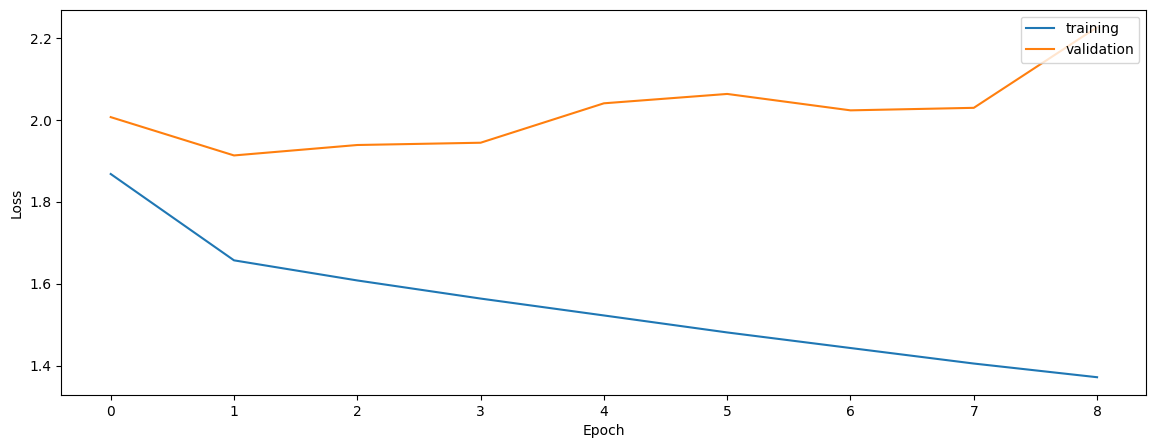

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.3506700914247996
0.2912507084707337
0.3266741771536108


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.45490466178496336
0.43913953855878635
0.4502164064396084


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.45358639396299844
0.44402166553825323
0.4542364624735671


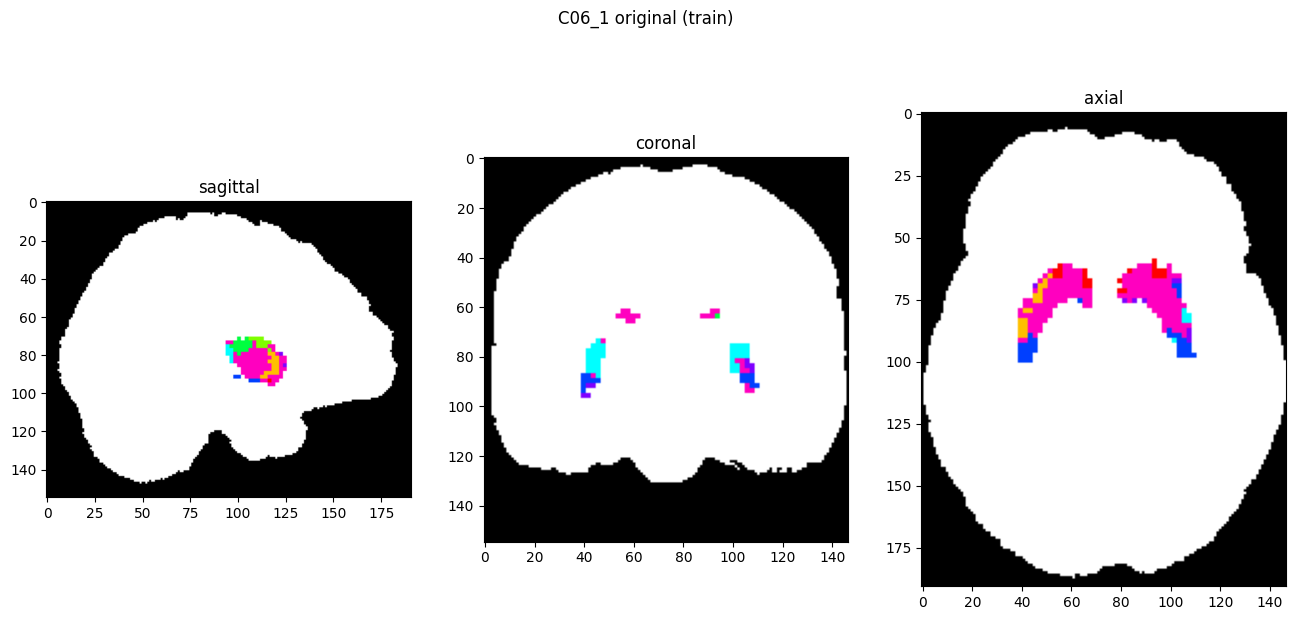

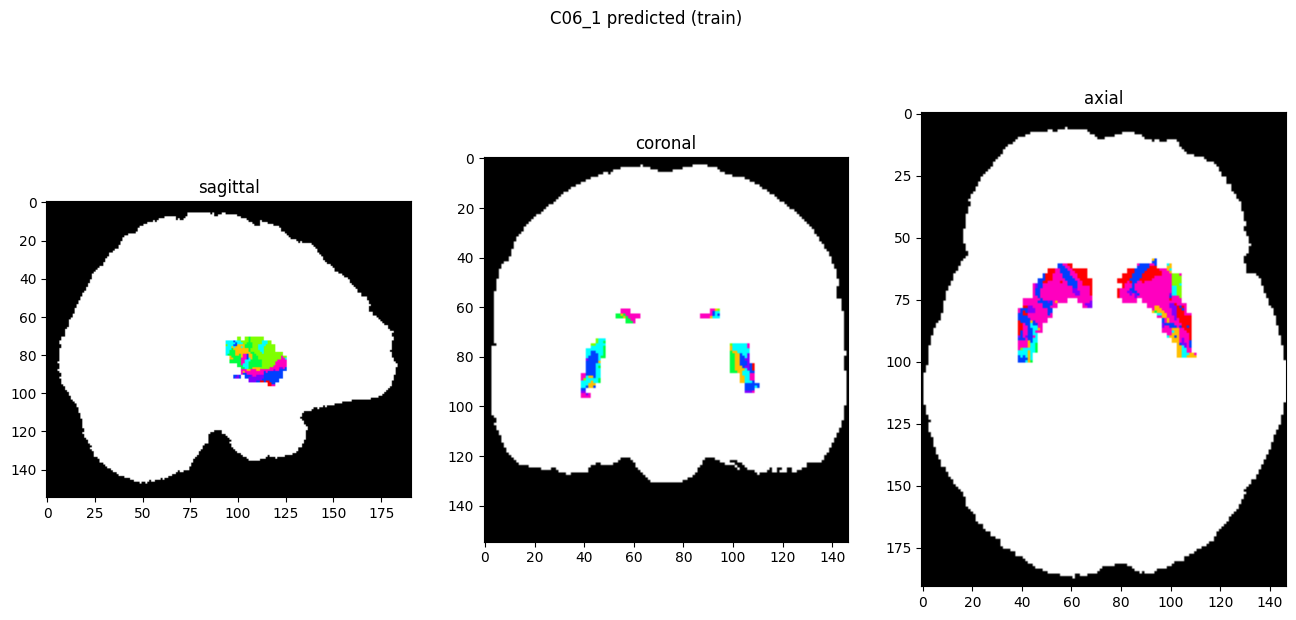

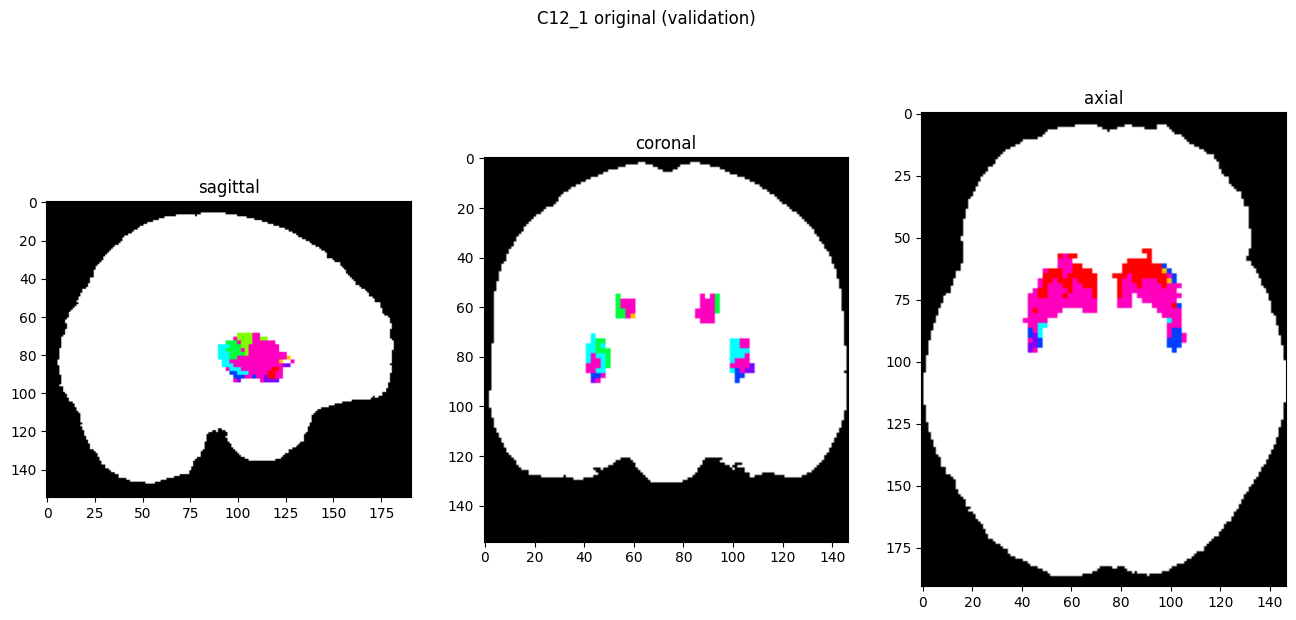

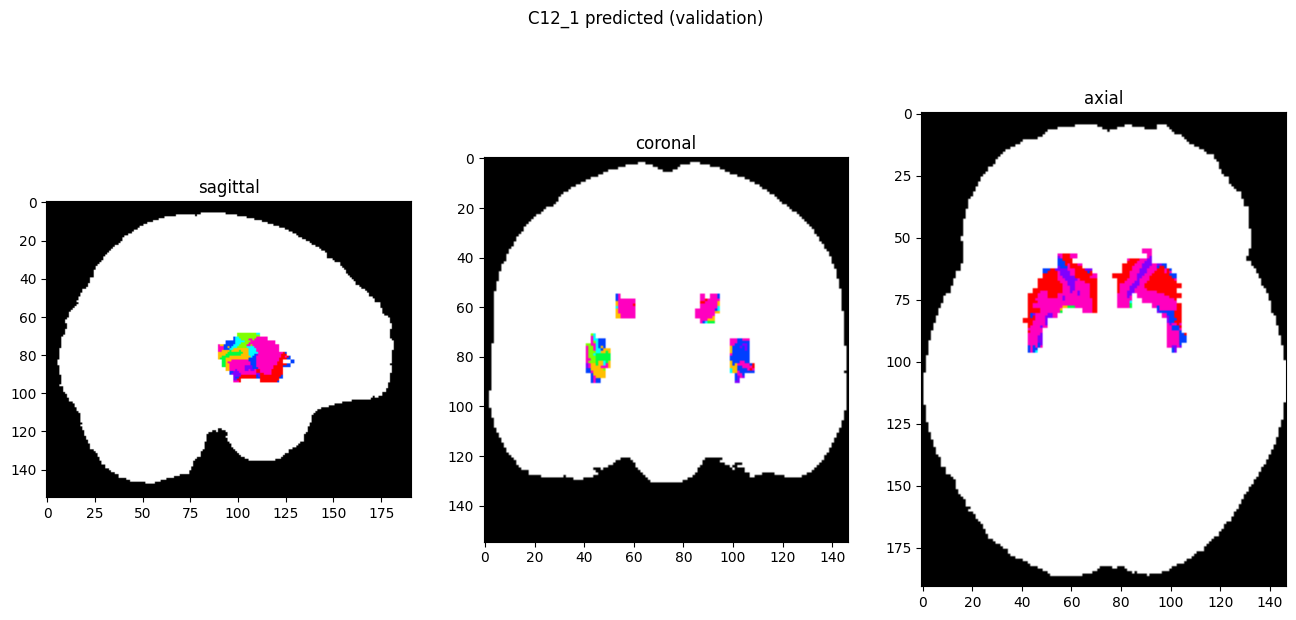

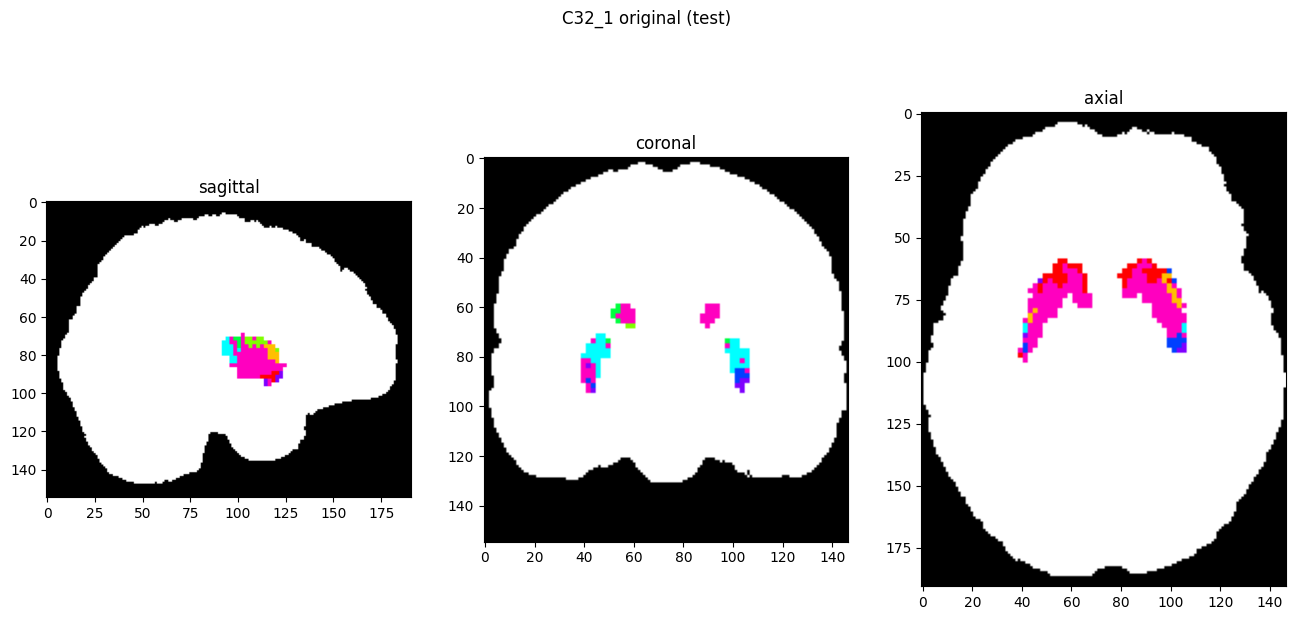

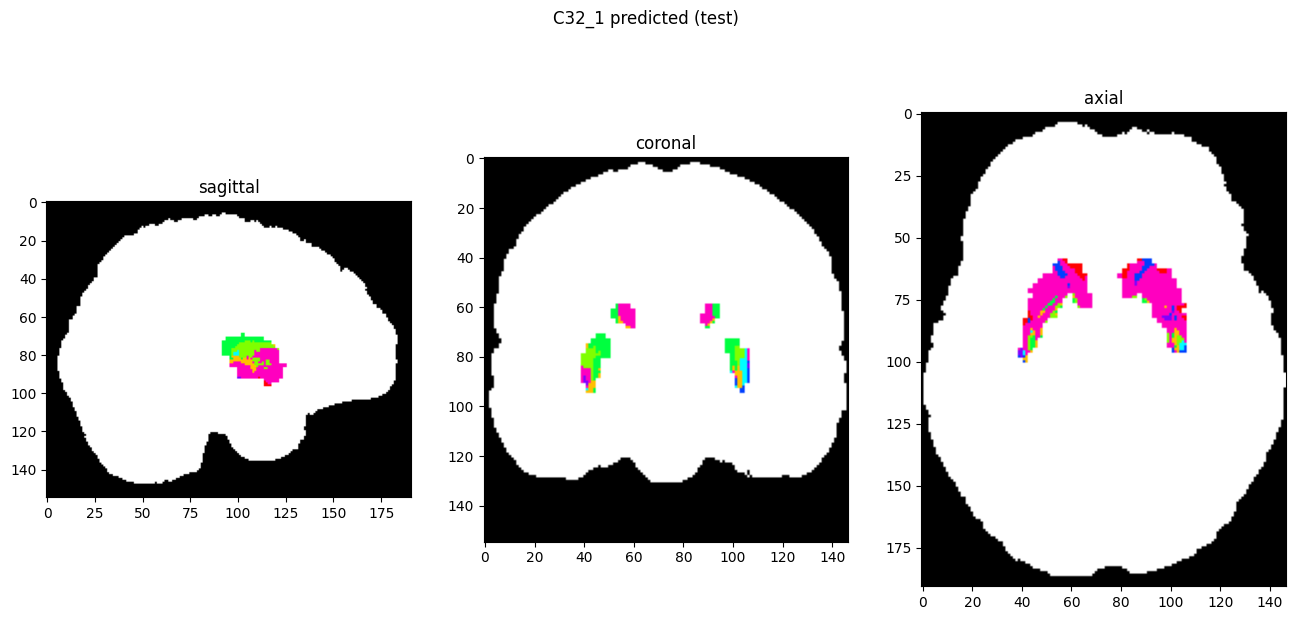

In [10]:
showResults(model, gen, threshold=0)